# Analisis exploratorio para scoring

In [140]:
# Importamos las librerias necesarias
import pandas as pd
import plotnine as p9
import numpy as np
import importlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optbinning import OptimalBinning
from feature_engine.encoding import WoEEncoder
import woe_encoding as we
from sklearn.linear_model import LogisticRegression
import feature_selection_functions as fsf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Funciones propias
import utils as ut

In [141]:
# Leemos la data
data_path  = '../data/german.csv'
data = pd.read_csv(data_path, sep=';',header=None)

# Renombramos columnas
col_names = ['status_account', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account', 
             'employee_time', 'installment_rate', 'personal_status', 'other_guarantors', 'time_present_residence',
             'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'number_of_dependants',
             'telephone', 'foreign_worker', 'target']

data.columns = col_names

In [142]:
# Revisamos estructura basica
data.head()

status_account  duration credit_history    purpose  credit_amount  \
0      (-inf, 0)         6      Very good   Radio/TV           1169   
1       [0, 200)        48        Average   Radio/TV           5951   
2     No account        12      Very good  Education           2096   
3      (-inf, 0)        42        Average  Furniture           7882   
4      (-inf, 0)        24           Good    New car           4870   

  savings_account employee_time  installment_rate  personal_status  \
0      No account      [7, inf)                 4      Male_Single   
1     (-inf, 100)        [1, 4)                 2  Female_Divorced   
2     (-inf, 100)        [4, 7)                 2      Male_Single   
3     (-inf, 100)        [4, 7)                 2      Male_Single   
4     (-inf, 100)        [1, 4)                 3      Male_Single   

  other_guarantors  ...           property age  other_installment_plans  \
0              NaN  ...        Real estate  67                      NaN   
1              NaN  ...        Real estate  22                      NaN   
2              NaN  ...        Real estate  49                      NaN   
3        Guarantor  ...  Savings agreement  45                      NaN   
4              NaN  ...        No property  53                      NaN   

    housing number_credits        job number_of_dependants  telephone  \
0       Own              2    Skilled                    1        Yes   
1       Own              1    Skilled                    1         No   
2       Own              1  Unskilled                    2         No   
3  For free              1    Skilled                    2         No   
4  For free              2    Skilled                    2         No   

  foreign_worker target  
0            Yes      1  
1            Yes      2  
2            Yes      1  
3            Yes      1  
4            Yes      2  

[5 rows x 21 columns]

In [143]:
# Revisamos info por columna
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status_account           1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employee_time            1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status          1000 non-null   object
 9   other_guarantors         93 non-null     object
 10  time_present_residence   1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  186 non-null    object
 14  housing                  1000 non-null   

Tenemos 21 columnas, 2 variables **'other_guarantors','other_installment_plans'** presentan missing data en algunas filas

Revisamos aquellas columnas que sean numericas, y las guardamos

In [144]:
cuantitative_col = data.select_dtypes(include = ['number']).columns.tolist()
cuantitative_col

['duration',
 'credit_amount',
 'installment_rate',
 'time_present_residence',
 'age',
 'number_credits',
 'number_of_dependants',
 'target']

La variable objetivo **'target'**, se debe reubicar dentro de las variables categóricas, a tener en cuenta para el resto del análisis.

Revisamos el resto de columnas que seran las discretas y las guardamos

In [145]:
discrete_col = [col for col in data.columns if col not in cuantitative_col]
discrete_col.append('target')
discrete_col

['status_account',
 'credit_history',
 'purpose',
 'savings_account',
 'employee_time',
 'personal_status',
 'other_guarantors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker',
 'target']

Actualizamos las variables cuantitativas

In [146]:
# Actualizamos las variables cuantitativas, y revisamos
cuantitative_col = [col for col in cuantitative_col if col !='target']
cuantitative_col

['duration',
 'credit_amount',
 'installment_rate',
 'time_present_residence',
 'age',
 'number_credits',
 'number_of_dependants']

### Primeras impresiones

Tenemos 21 variables, 7 cuantitativas, 14 discretas. La variable objetiva es discreta, solo 2 columnas presentas valores perdidos (nan).

## Análisis de correlación
Sacamos la matriz de correlación de todas las variables cuantitativas salvo de la variable objetivo **'target'**.

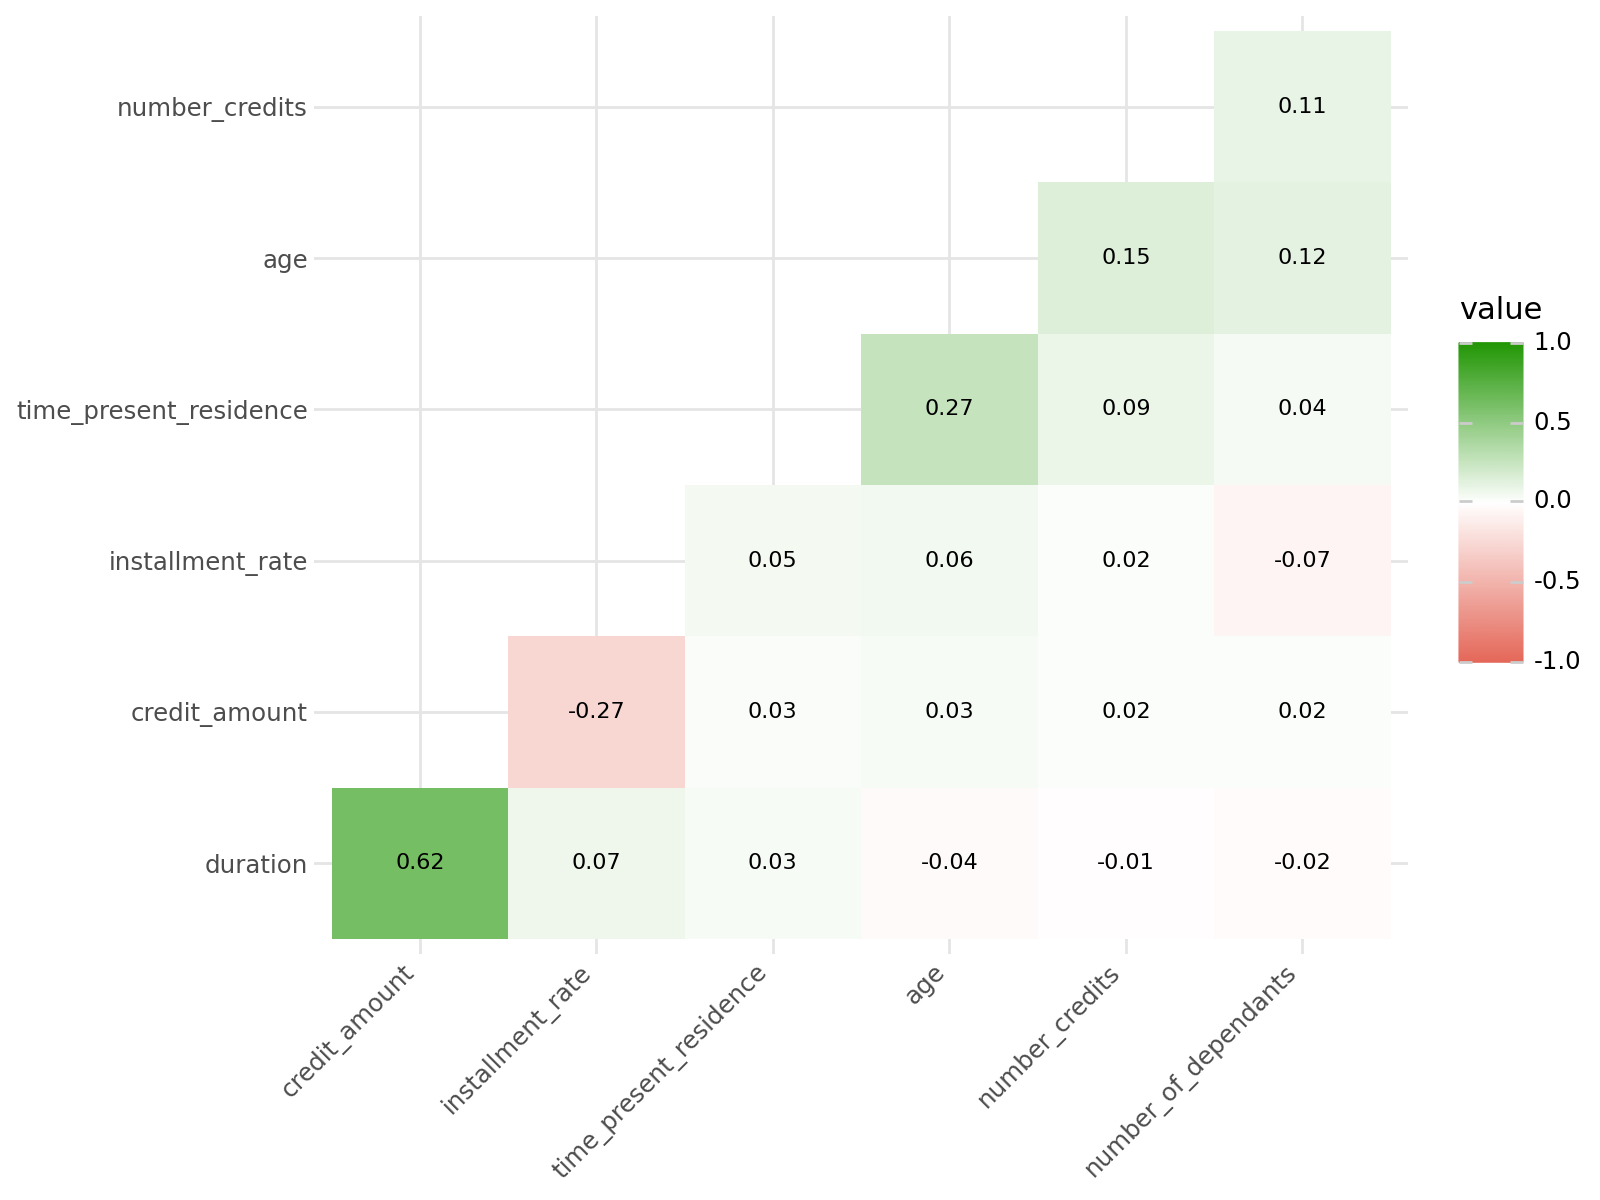

In [147]:
# Excluimos la variable objetivo
corr_matrix = data[cuantitative_col].corr()
col_order = corr_matrix.columns.tolist() # Keep the original order

# 2. Mask and Stack
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
mask[np.triu_indices_from(mask, k=1)] = True  # k=1 keeps the diagonal
# We use 'where' to keep the lower triangle and drop NaNs with stack

corr_matrix = corr_matrix.where(~mask).stack().reset_index()
corr_matrix.columns = ['var1', 'var2', 'value']

# 3. CRITICAL STEP: Force the order of the variables
# This prevents plotnine from alphabetizing the axes
corr_matrix['var1'] = pd.Categorical(corr_matrix['var1'], categories=col_order)
corr_matrix['var2'] = pd.Categorical(corr_matrix['var2'], categories=col_order)

# 4. Plot
(
    p9.ggplot(corr_matrix, p9.aes(x='var1', y='var2', fill='value'))
    + p9.geom_tile()
    + p9.geom_text(p9.aes(label='value.round(2)'), size=8)
    + p9.scale_fill_gradient2(low='#E46758', mid='white', high="#229605", limits=[-1, 1])
    + p9.theme_minimal()
    + p9.theme(
        axis_text_x=p9.element_text(rotation=45, hjust=1),
        figure_size=(8, 6),
        axis_title_x=p9.element_blank(), # Removes the X-axis title
        axis_title_y=p9.element_blank()  # Removes the Y-axis title    
    )
).show()

Basandonos en la matriz de correlación la unica relación significativa entre variables numericas es entre **'duration'** y **'credit_amount'**, algo totalmente razonable ya que mientras mayor es la cantidad prestada, tiene a ser mayor la duración del prestamo.

### Analisis univariante variables cuantitativas

A continuación revisaremos las variables cuantitativas una por una excluyendo la variable **'target'**

### duration
Duración del préstamo en meses

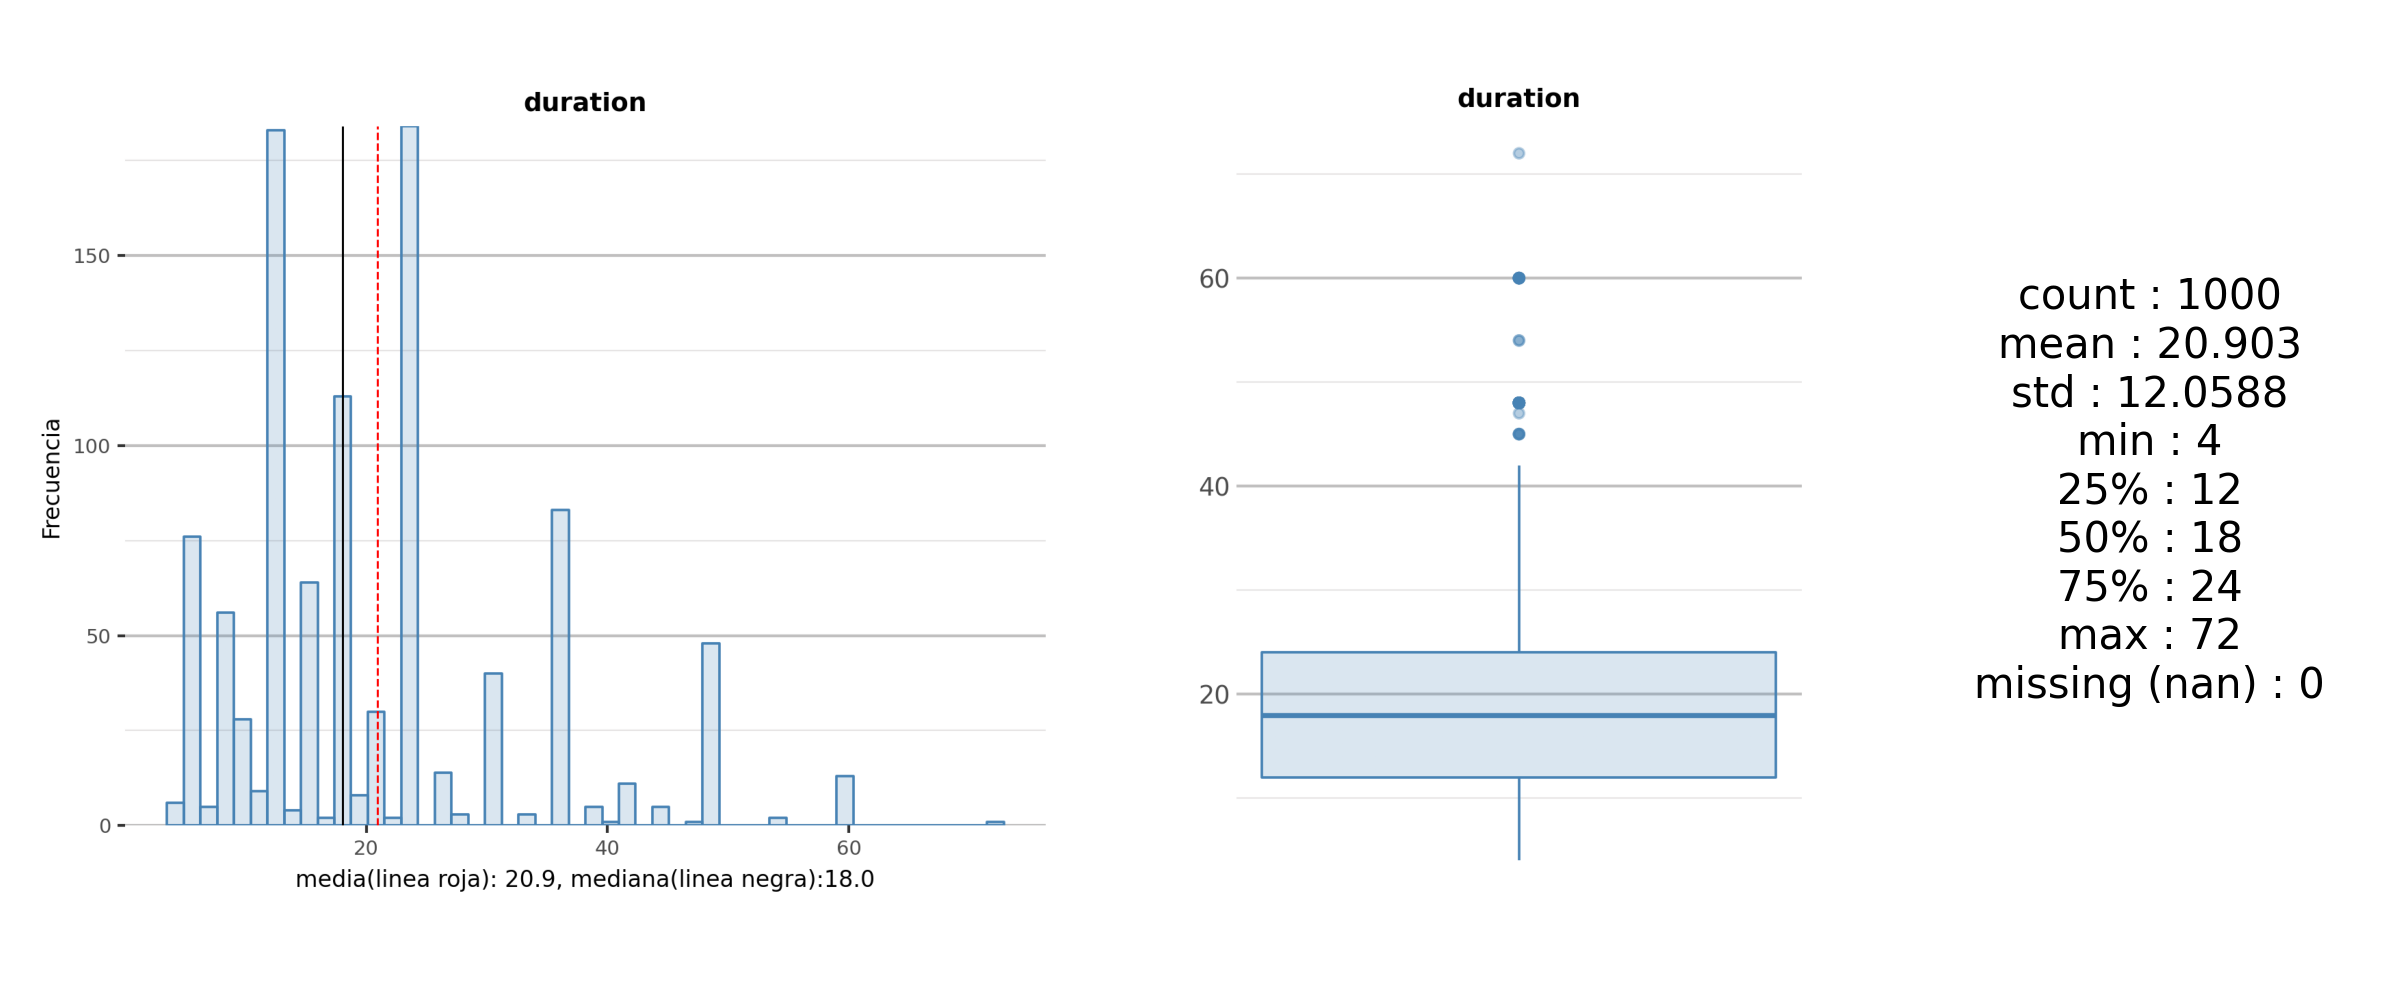

In [148]:
col = cuantitative_col[0]
histogram_plot = ut.histogram_plot(data,col,'steelblue',(5,4))
box_plot = ut.box_plot(data,col,'steelblue',(3,4))
desc_text = ut.desc_text(data,col)
plot_cuantitative = ut.plot_var_cuantitative(histogram_plot,box_plot,desc_text,(5,4),(3,4),(2,4))
plt.show()

La variable **'duration'** presenta una distribución simétrica, unos cuantos outliers en la parte superior, no presenta valores perdidos (nan), y un rango entre 4 y 72 meses para los prestamos.

### credit_amount
Cantidad prestada, se asumirá que es en EUR

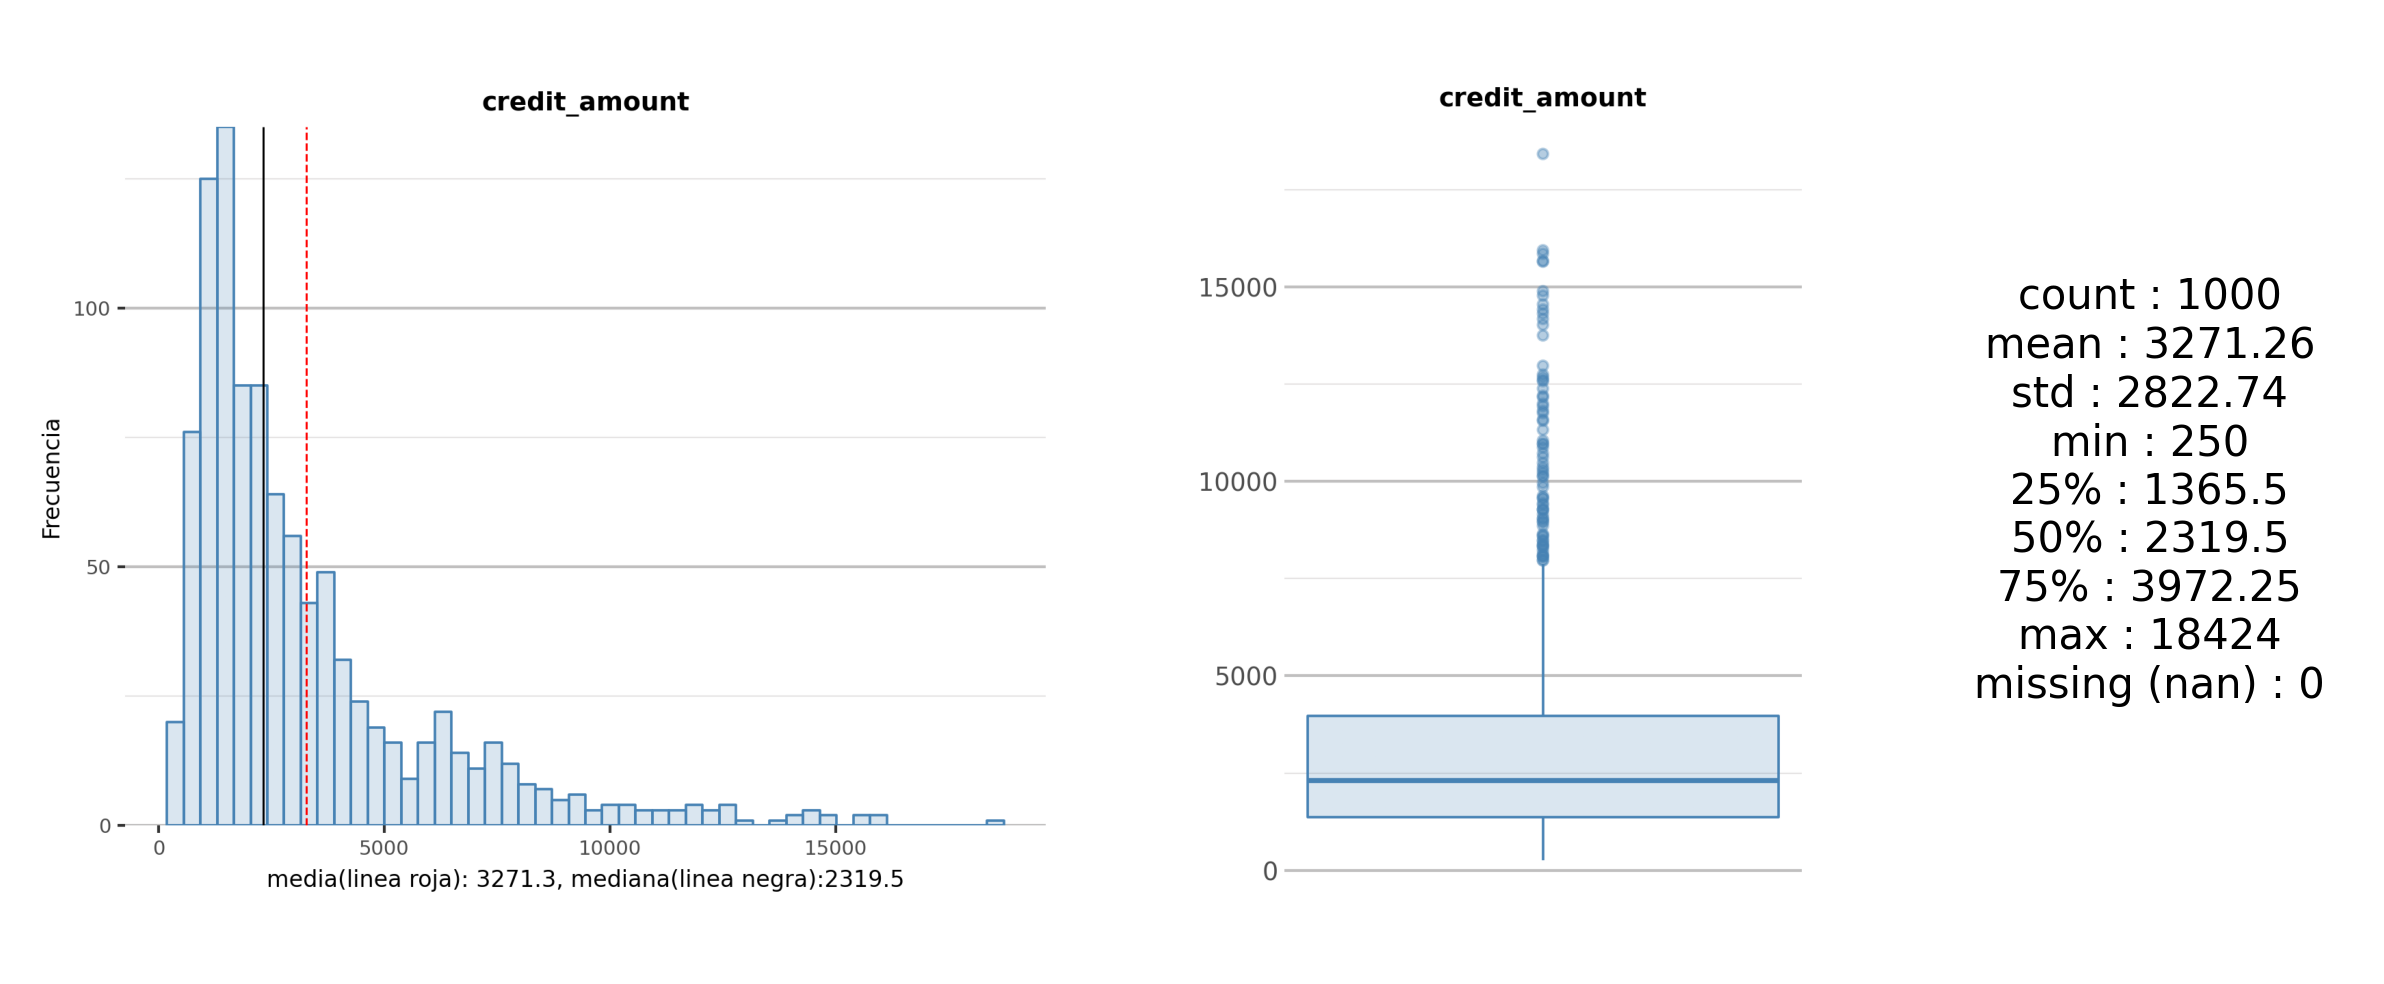

In [149]:
col = cuantitative_col[1]
histogram_plot = ut.histogram_plot(data,col,'steelblue',(5,4))
box_plot = ut.box_plot(data,col,'steelblue',(3,4))
desc_text = ut.desc_text(data,col)
plot_cuantitative = ut.plot_var_cuantitative(histogram_plot,box_plot,desc_text,(5,4),(3,4),(2,4))
plt.show()

La variable **'credit_amount'** presenta una asimetría positiva, unos cuantos outliers en la parte superior, no presenta valores perdidos (nan), y un rango entre 250 y 18k euros para los prestamos.

### Installment_rate
Tasa de pago a plazos en porcentaje de los ingresos disponibles

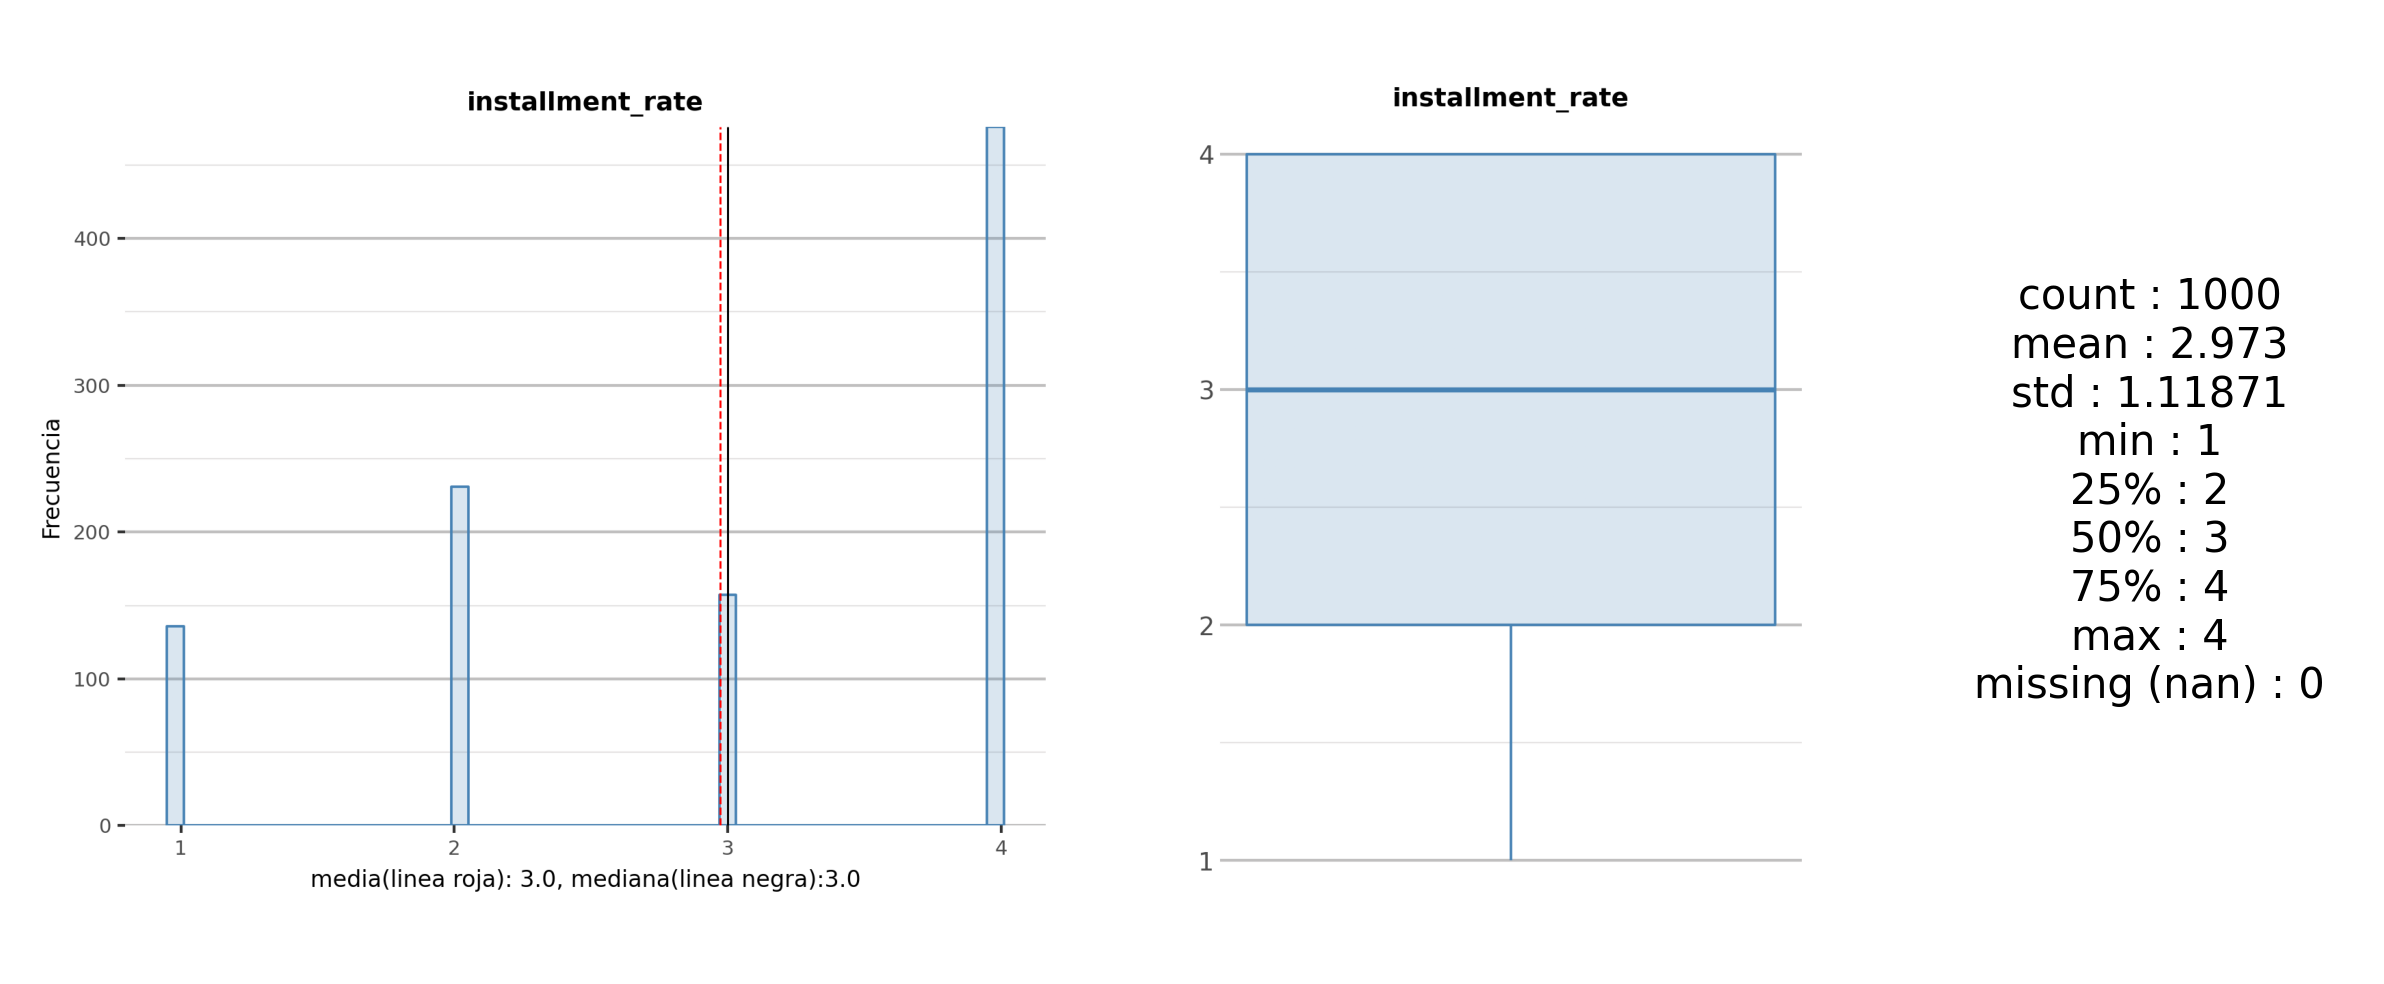

In [150]:
col = cuantitative_col[2]
histogram_plot = ut.histogram_plot(data,col,'steelblue',(5,4))
box_plot = ut.box_plot(data,col,'steelblue',(3,4))
desc_text = ut.desc_text(data,col)
plot_cuantitative = ut.plot_var_cuantitative(histogram_plot,box_plot,desc_text,(5,4),(3,4),(2,4))
plt.show()

**'Installment_rate'** si bien es numérica, presenta solo 4 valores posibles (1,2,3,4), no presenta valores perdidos (nan), probablemente se pueda utilizar como discreta.

### time_present_residence
Tiempo en la residencia actual

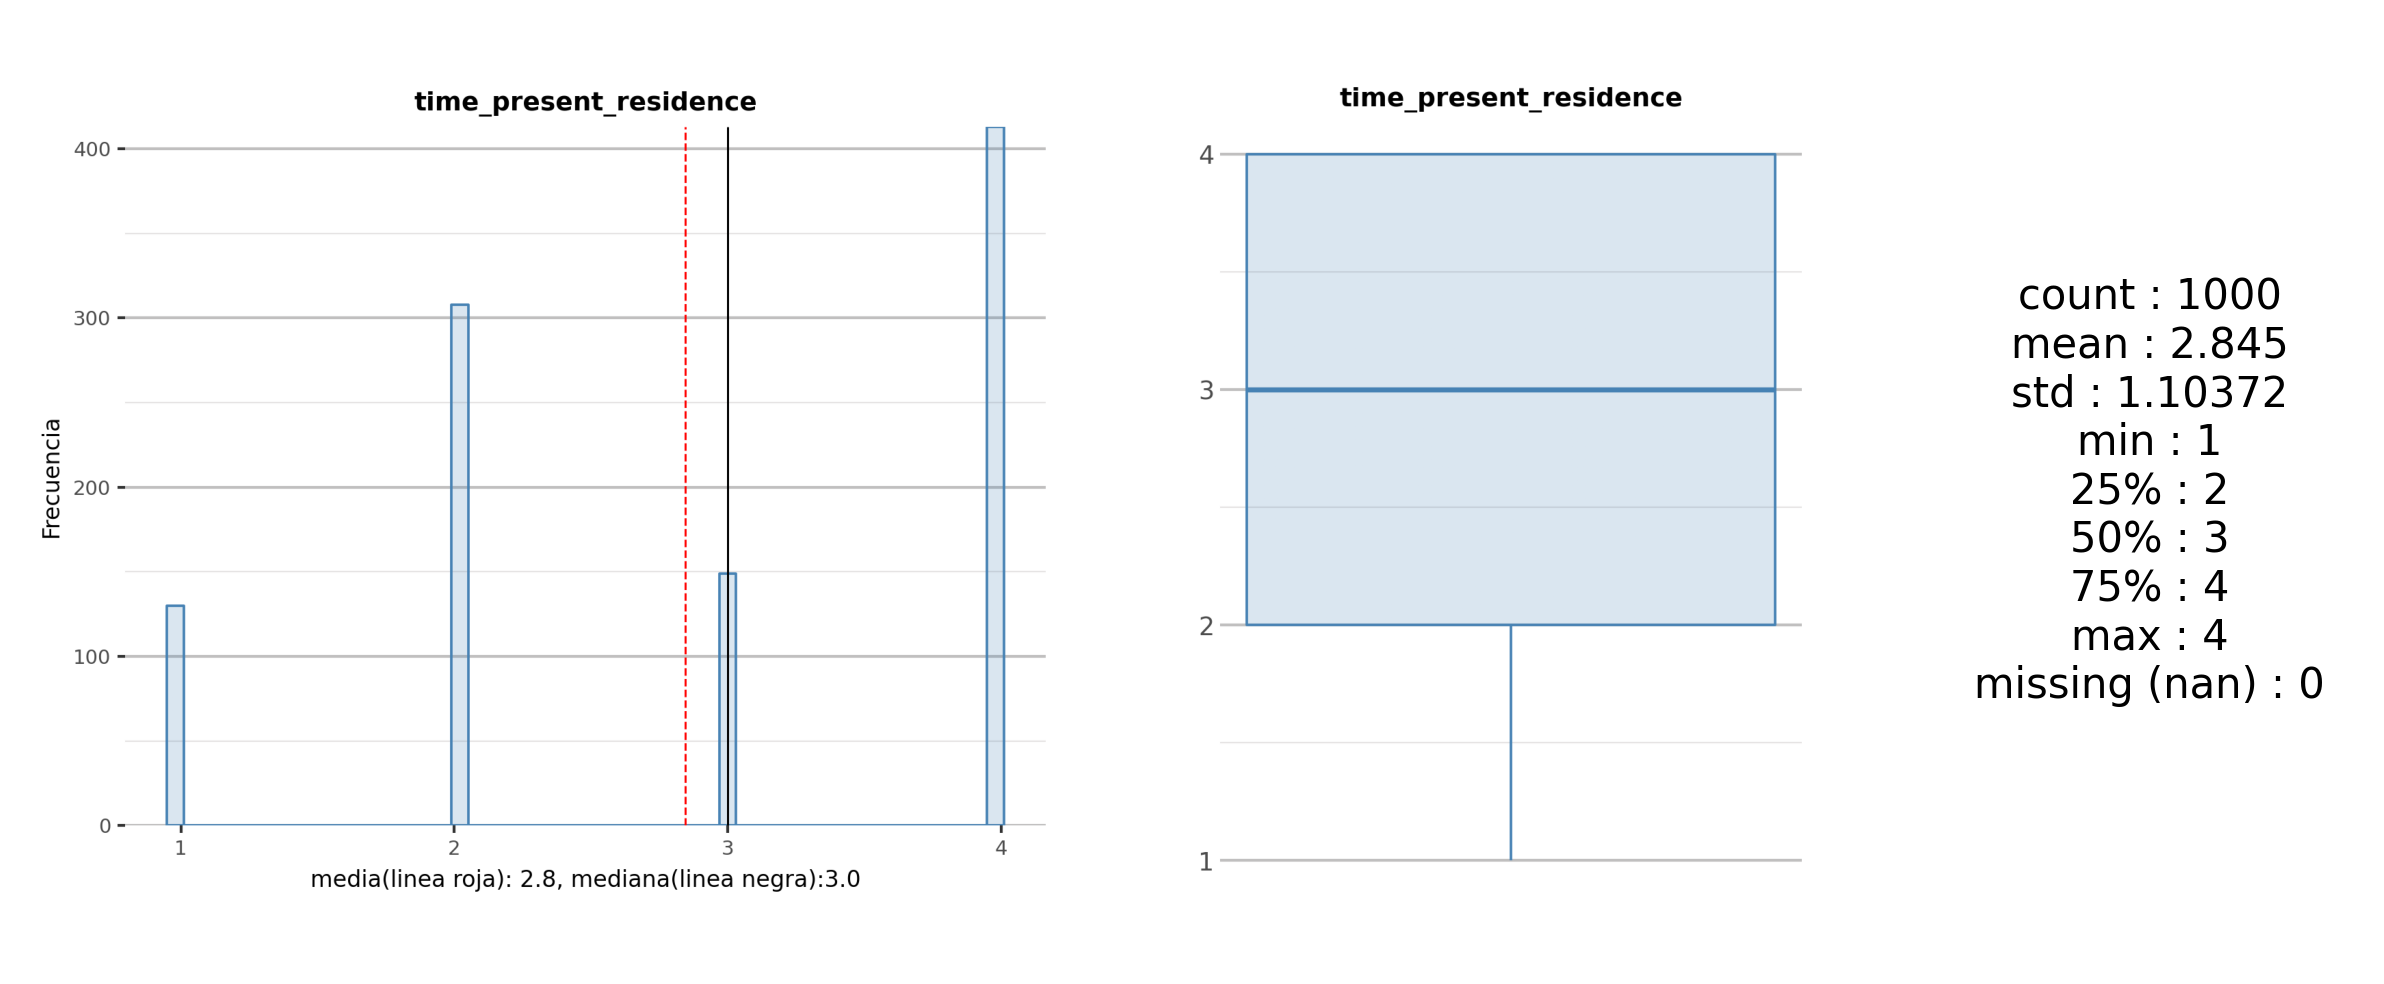

In [151]:
col = cuantitative_col[3]
histogram_plot = ut.histogram_plot(data,col,'steelblue',(5,4))
box_plot = ut.box_plot(data,col,'steelblue',(3,4))
desc_text = ut.desc_text(data,col)
plot_cuantitative = ut.plot_var_cuantitative(histogram_plot,box_plot,desc_text,(5,4),(3,4),(2,4))
plt.show()

**'time_present_residence'** si bien es numérica, presenta solo 4 valores posibles (1,2,3,4), no presenta valores perdidos (nan), probablemente se pueda utilizar como discreta.

### age
Edad en años

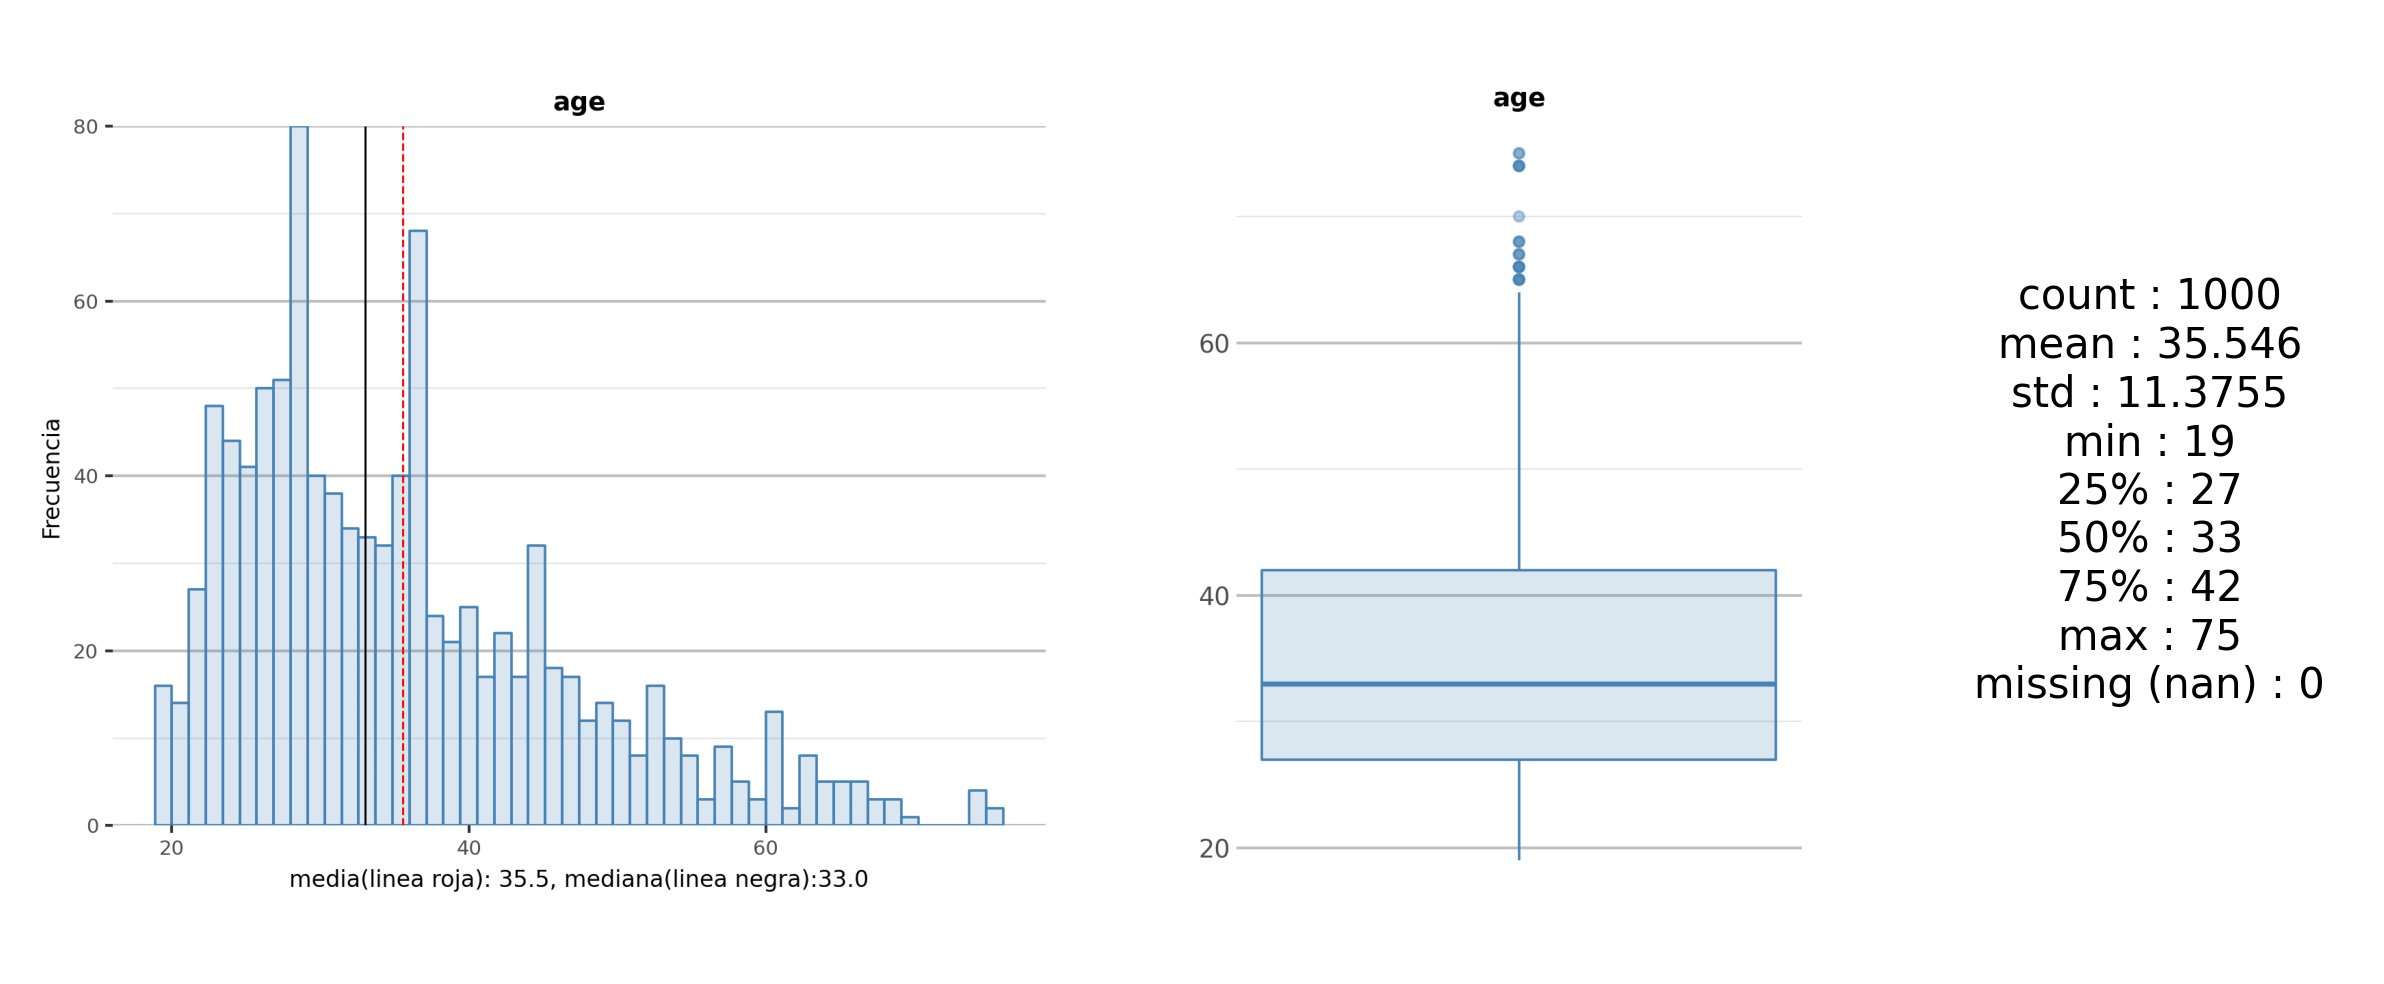

In [152]:
#importlib.reload(ut)
col = cuantitative_col[4]
histogram_plot = ut.histogram_plot(data,col,'steelblue',(5,4))
box_plot = ut.box_plot(data,col,'steelblue',(3,4))
desc_text = ut.desc_text(data,col)
plot_cuantitative = ut.plot_var_cuantitative(histogram_plot,box_plot,desc_text,(5,4),(3,4),(2,4))
plt.show()

**'age'** presenta una asimetría positiva, unos cuantos outliers en la parte superior, no presenta valores perdidos (nan), un rango razonable entre 19 y 75. 

### number_credits
Número de créditos existentes en este banco

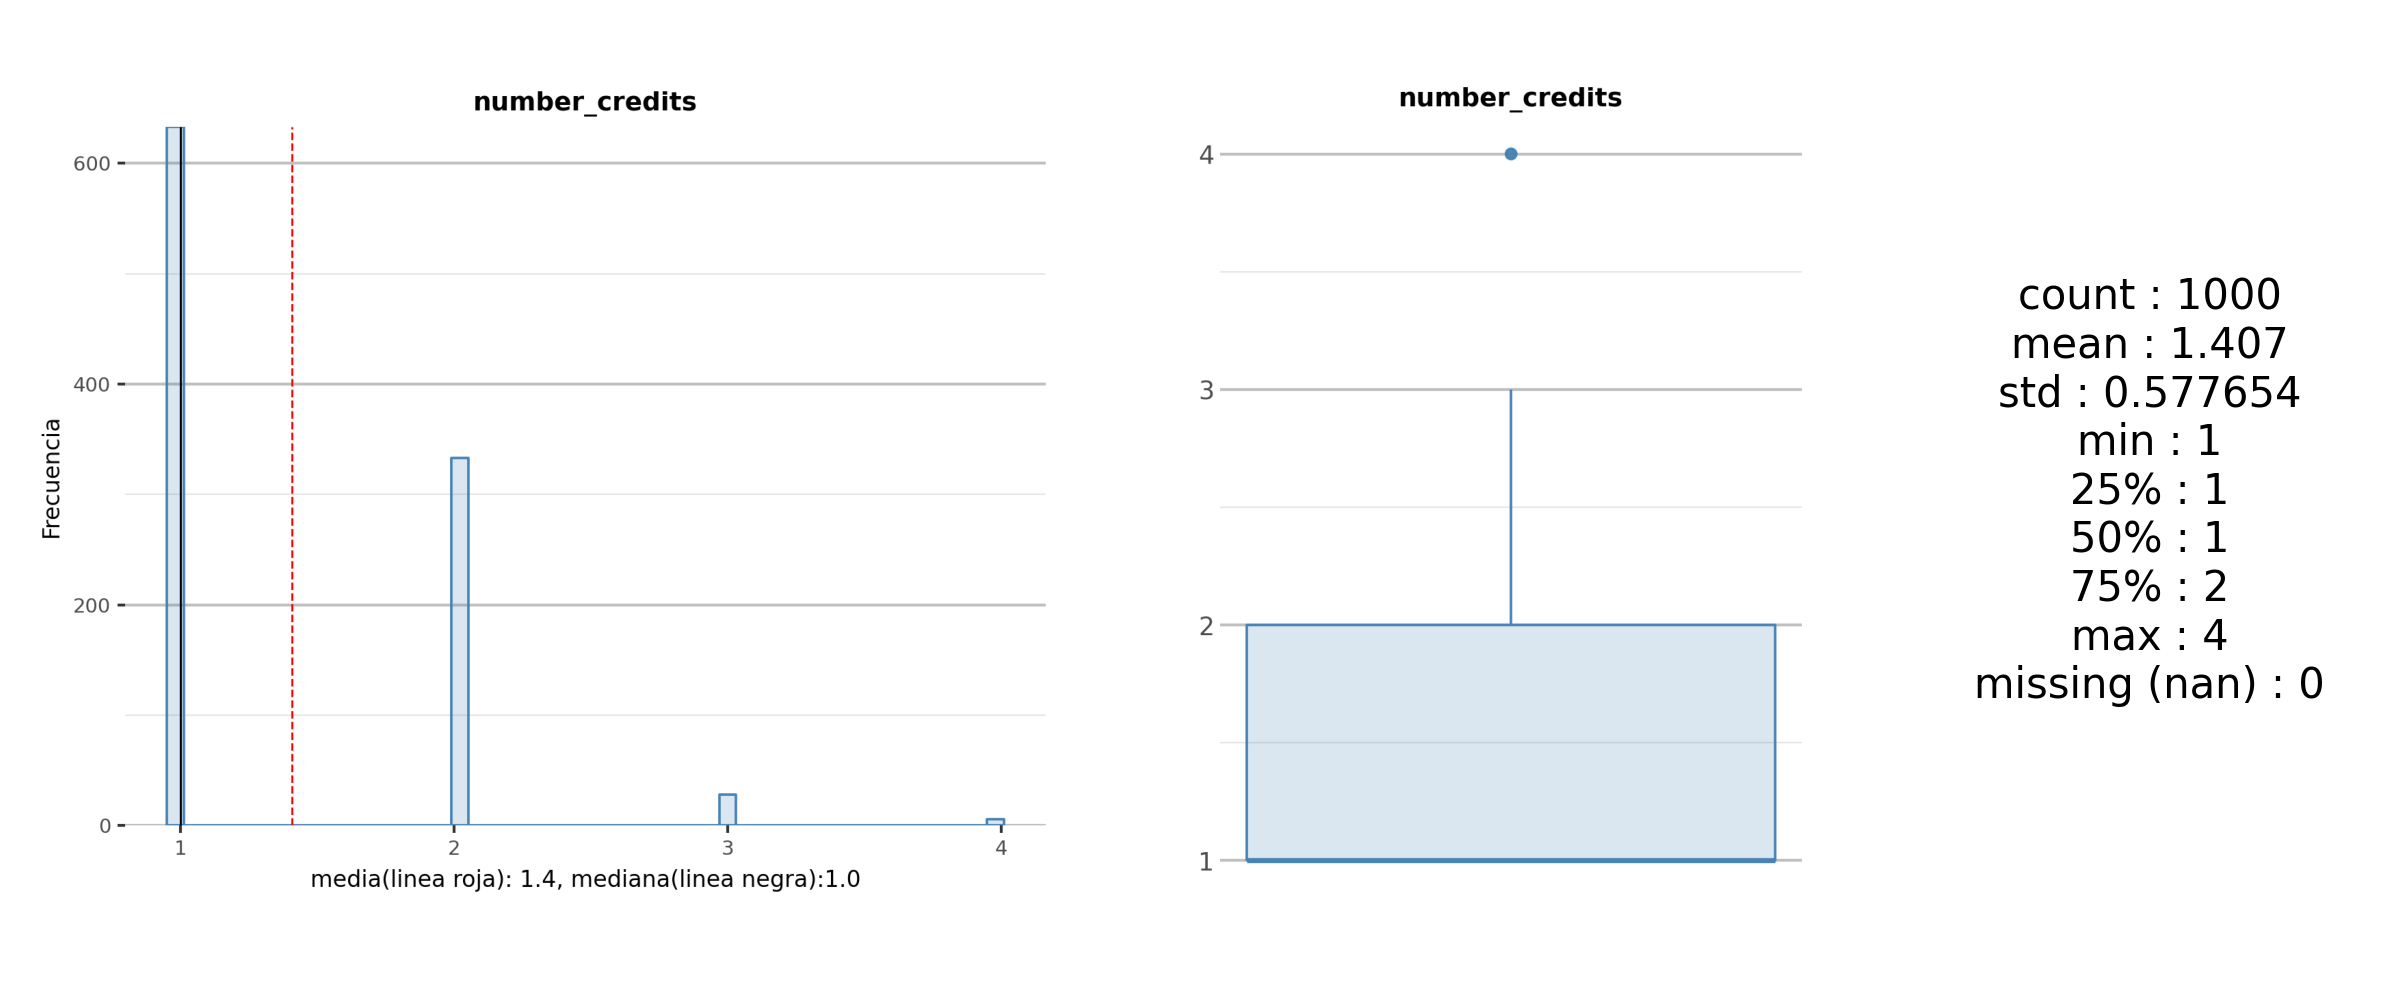

In [153]:
col = cuantitative_col[5]
histogram_plot = ut.histogram_plot(data,col,'steelblue',(5,4))
box_plot = ut.box_plot(data,col,'steelblue',(3,4))
desc_text = ut.desc_text(data,col)
plot_cuantitative = ut.plot_var_cuantitative(histogram_plot,box_plot,desc_text,(5,4),(3,4),(2,4))
plt.show()

**'number_credits'** si bien es numérica, presenta solo 4 valores posibles (1,2,3,4), no presenta valores perdidos (nan), probablemente se pueda utilizar como discreta.

### number_of_dependants
Número de personas a su cargo

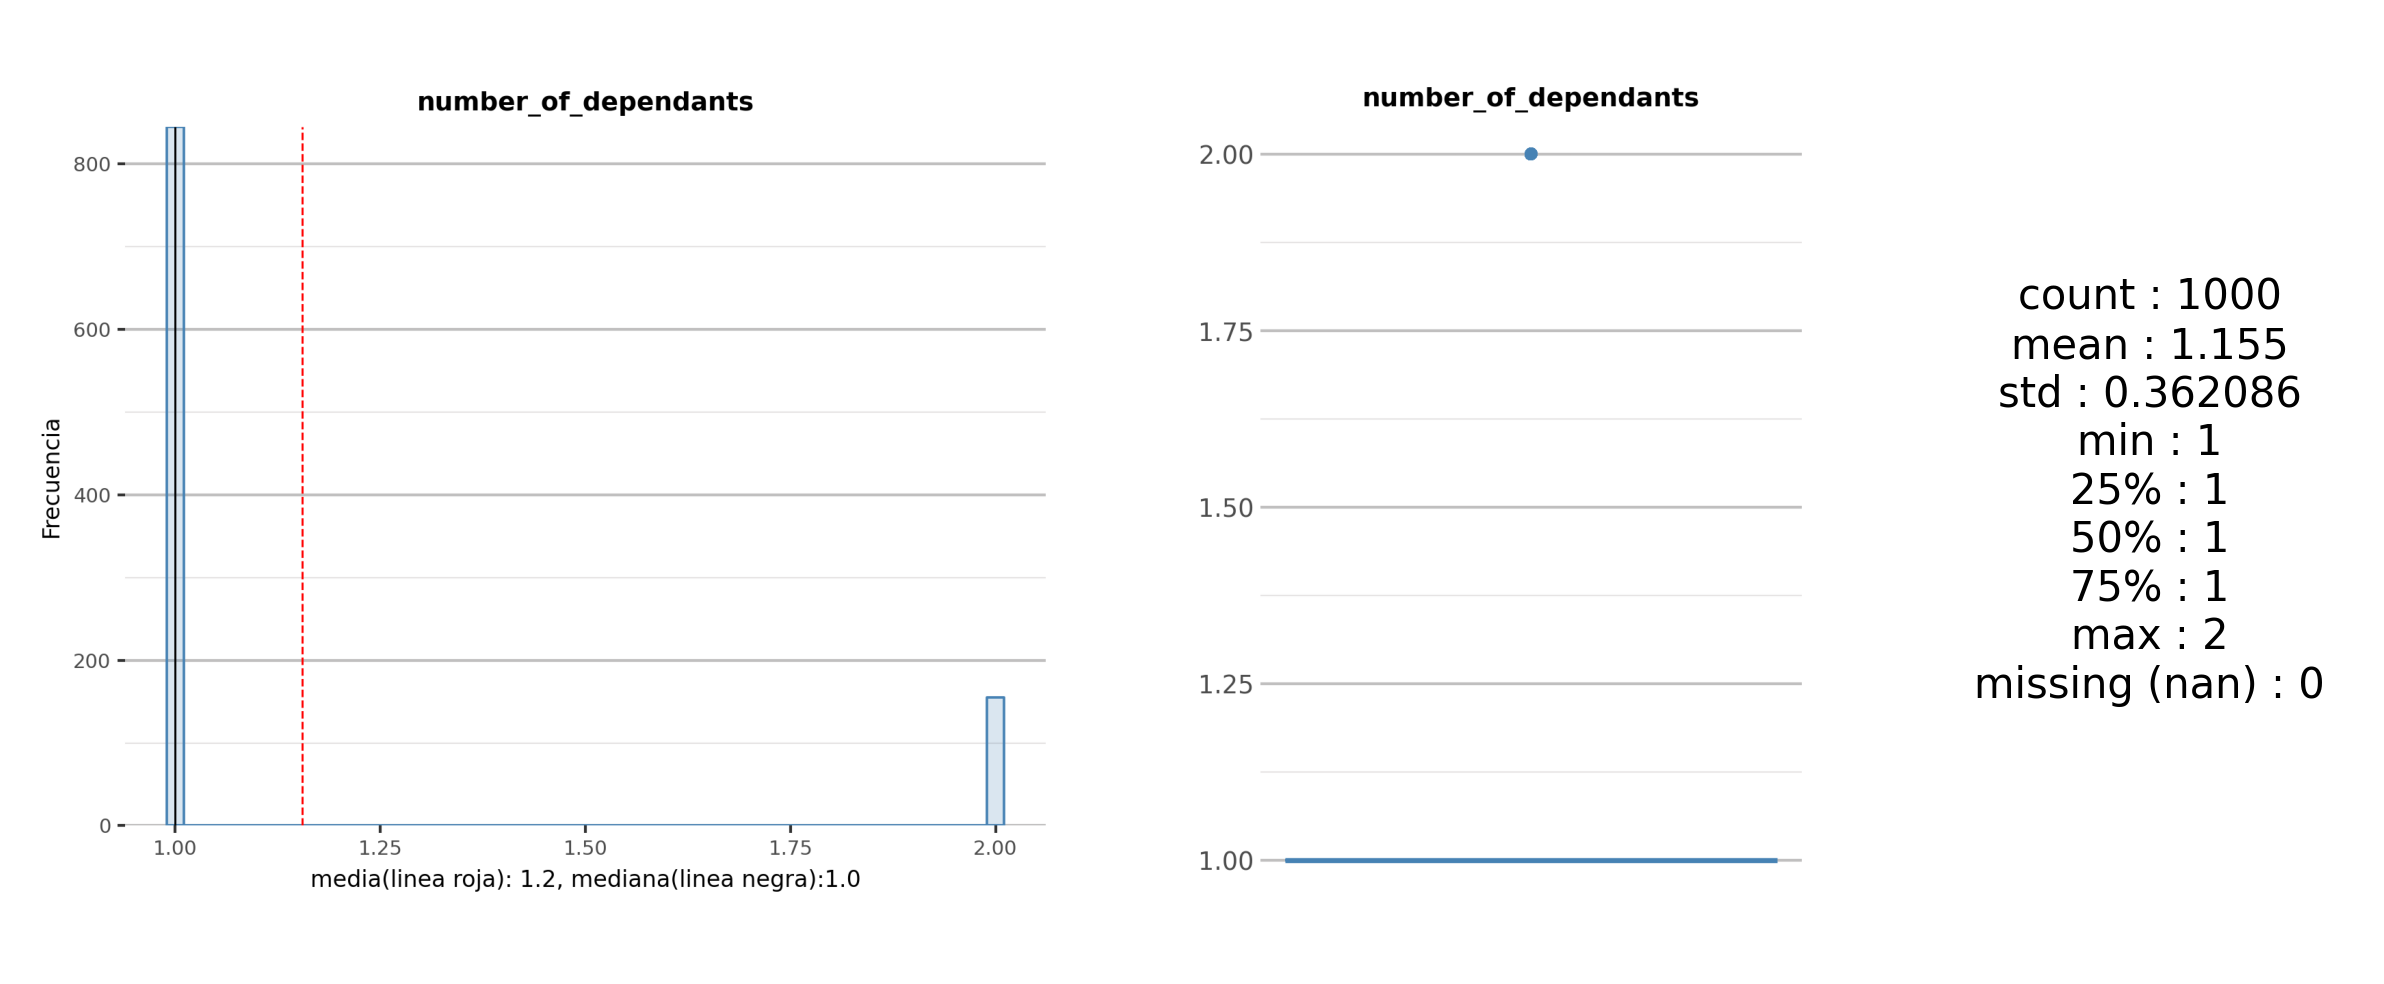

In [154]:
col = cuantitative_col[6]
histogram_plot = ut.histogram_plot(data,col,'steelblue',(5,4))
box_plot = ut.box_plot(data,col,'steelblue',(3,4))
desc_text = ut.desc_text(data,col)
plot_cuantitative = ut.plot_var_cuantitative(histogram_plot,box_plot,desc_text,(5,4),(3,4),(2,4))
plt.show()

**'number_of_dependants'** si bien es numérica, presenta solo 2 valores posibles (1,2), no presenta valores perdidos (nan), probablemente se pueda utilizar como discreta.

### Análisis univariante variables discretas

A continuación revisaremos las variables discretas una por una excluyendo la variable **'target'**

In [155]:
discrete_col

['status_account',
 'credit_history',
 'purpose',
 'savings_account',
 'employee_time',
 'personal_status',
 'other_guarantors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker',
 'target']

### status_account
Saldo de la cuenta existente

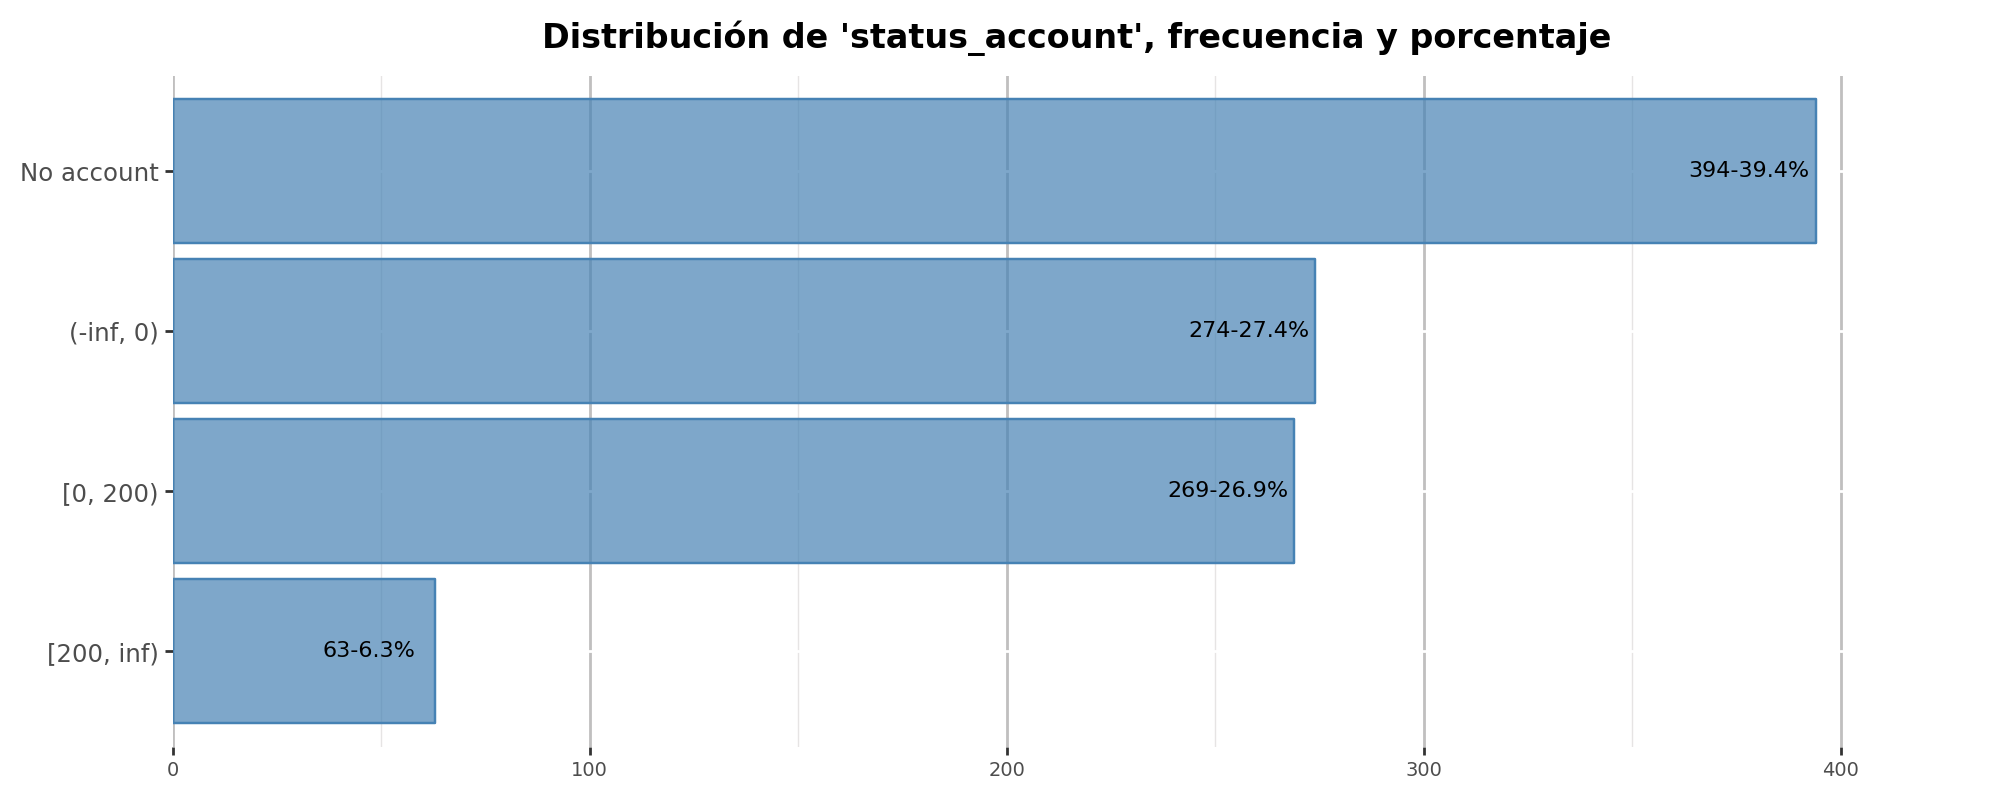

In [156]:
col = discrete_col[0]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),-16)
bar_plot.show()

**'status_account'**, presenta 4 valores posibles respecto al saldo de la cuenta existente, no presenta valores perdidos (nan), lo que se puede remarcar es que aproximadamente el 40% no tiene una cuenta al momento de solicitar el préstamo.

### credit_history
Historial crediticio

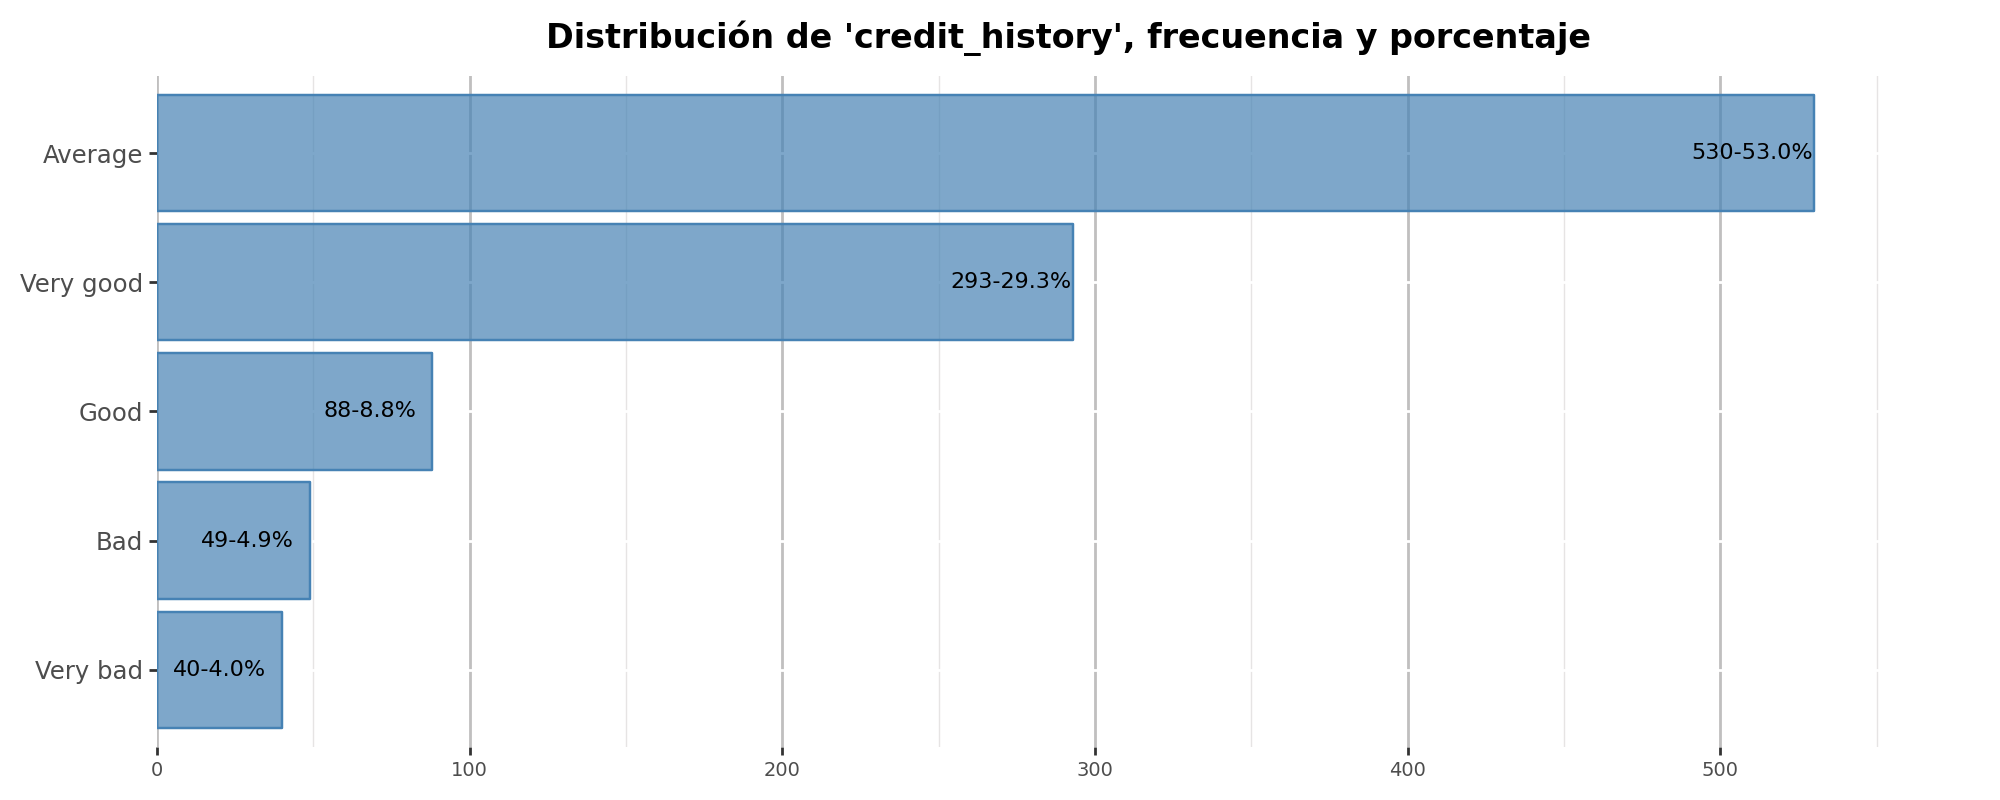

In [157]:
col = discrete_col[1]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),-20)
bar_plot.show()

**'credit_history'**, presenta 5 valores posibles respecto al historial crediticio, no presenta valores perdidos (nan), lo que se puede remarcar es que **'Average'** representa el 53% de las observaciones pero no hace sentido con el resto de categorías.

### purpose
Propósito del préstamo

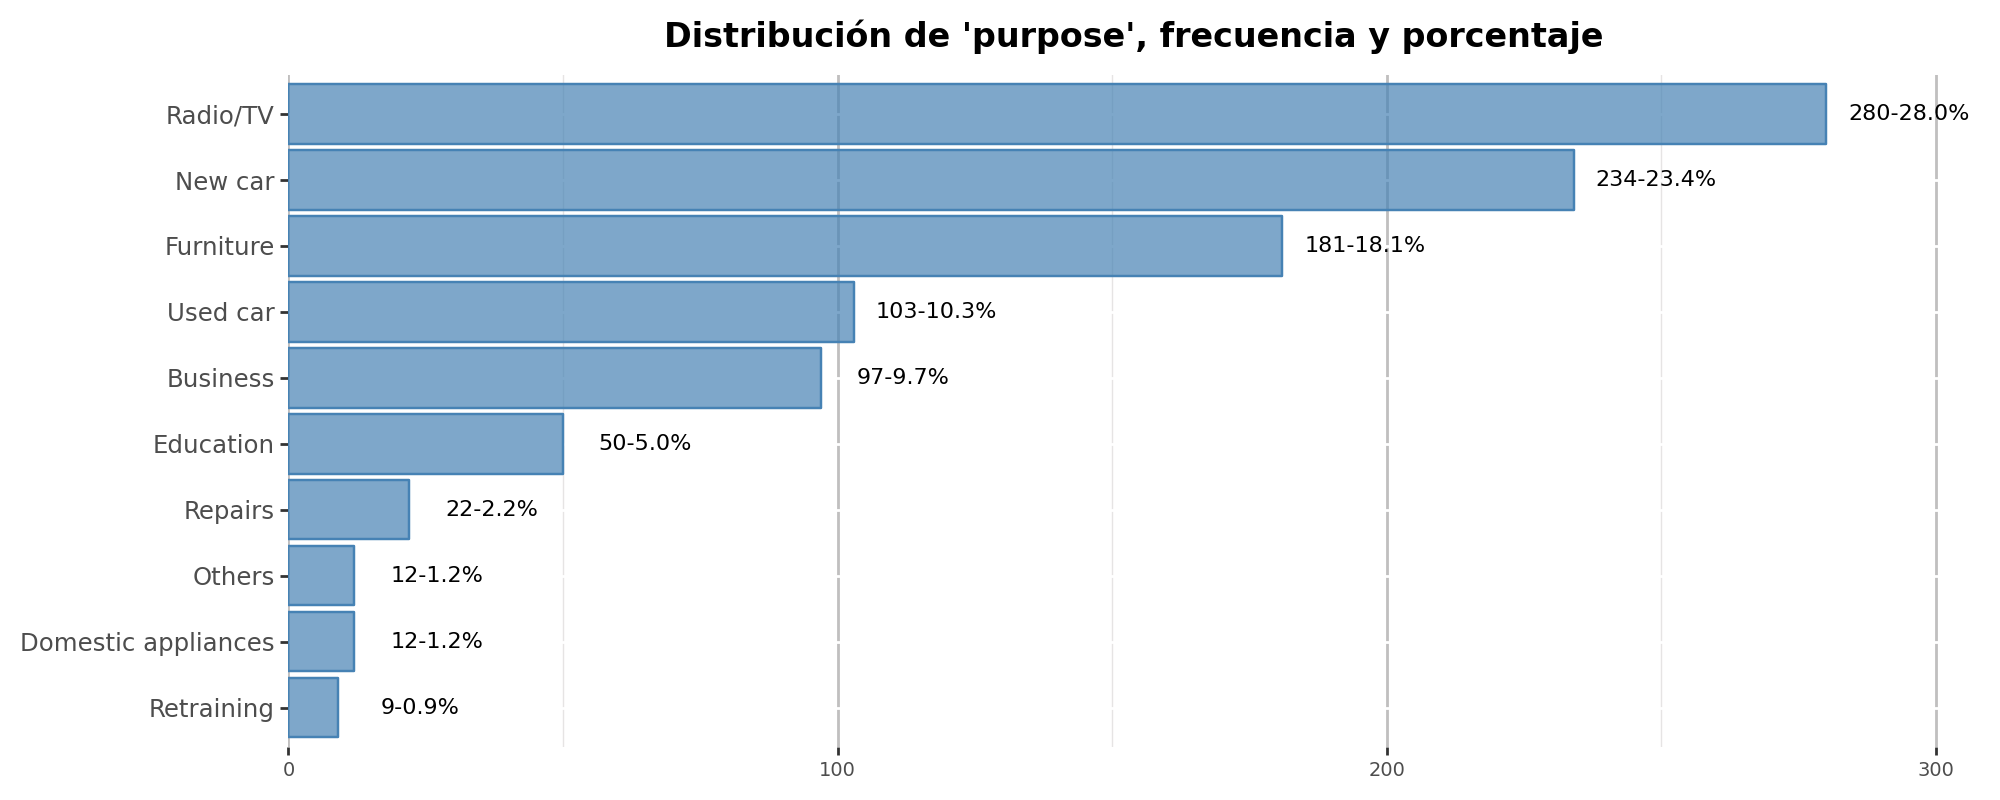

In [158]:
col = discrete_col[2]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),15)
bar_plot.show()

**'purpose'**, presenta 10 valores posibles respecto al propósito del préstamo, no presenta valores perdidos (nan), 69% de los prestamos están concentrados en las 3 siguientes categorías (Radio/TV, New car, Used car), probablemente sea necesario un nuevo label encoding manteniendo el top 3 y el resto como otros.

### savings_account
Cuentas de ahorro/bonos

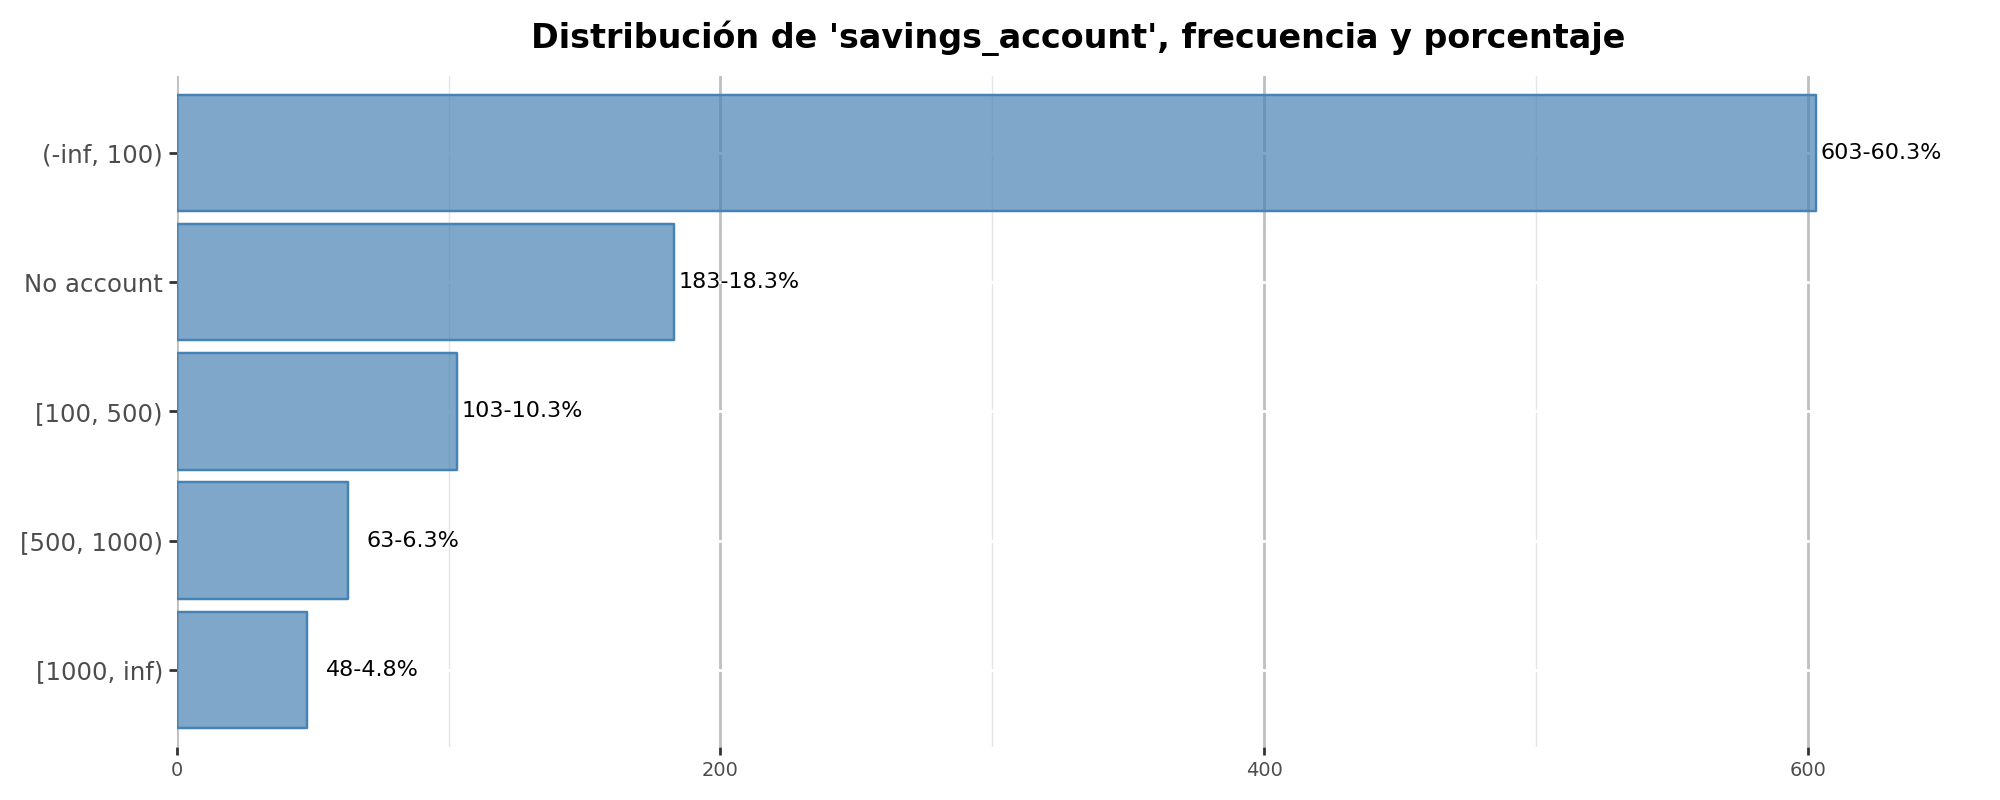

In [159]:
col = discrete_col[3]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),24)
bar_plot.show()

**'saving_account'**, presenta 5 valores posibles respecto a la información sobre las cuentas de ahorro/bonos, no presenta valores perdidos (nan), aproximadamente el 60% de los prestamos están concentrados en la categoría (menor a 100).

### employee_time
Tiempo de empleo del solicitante  

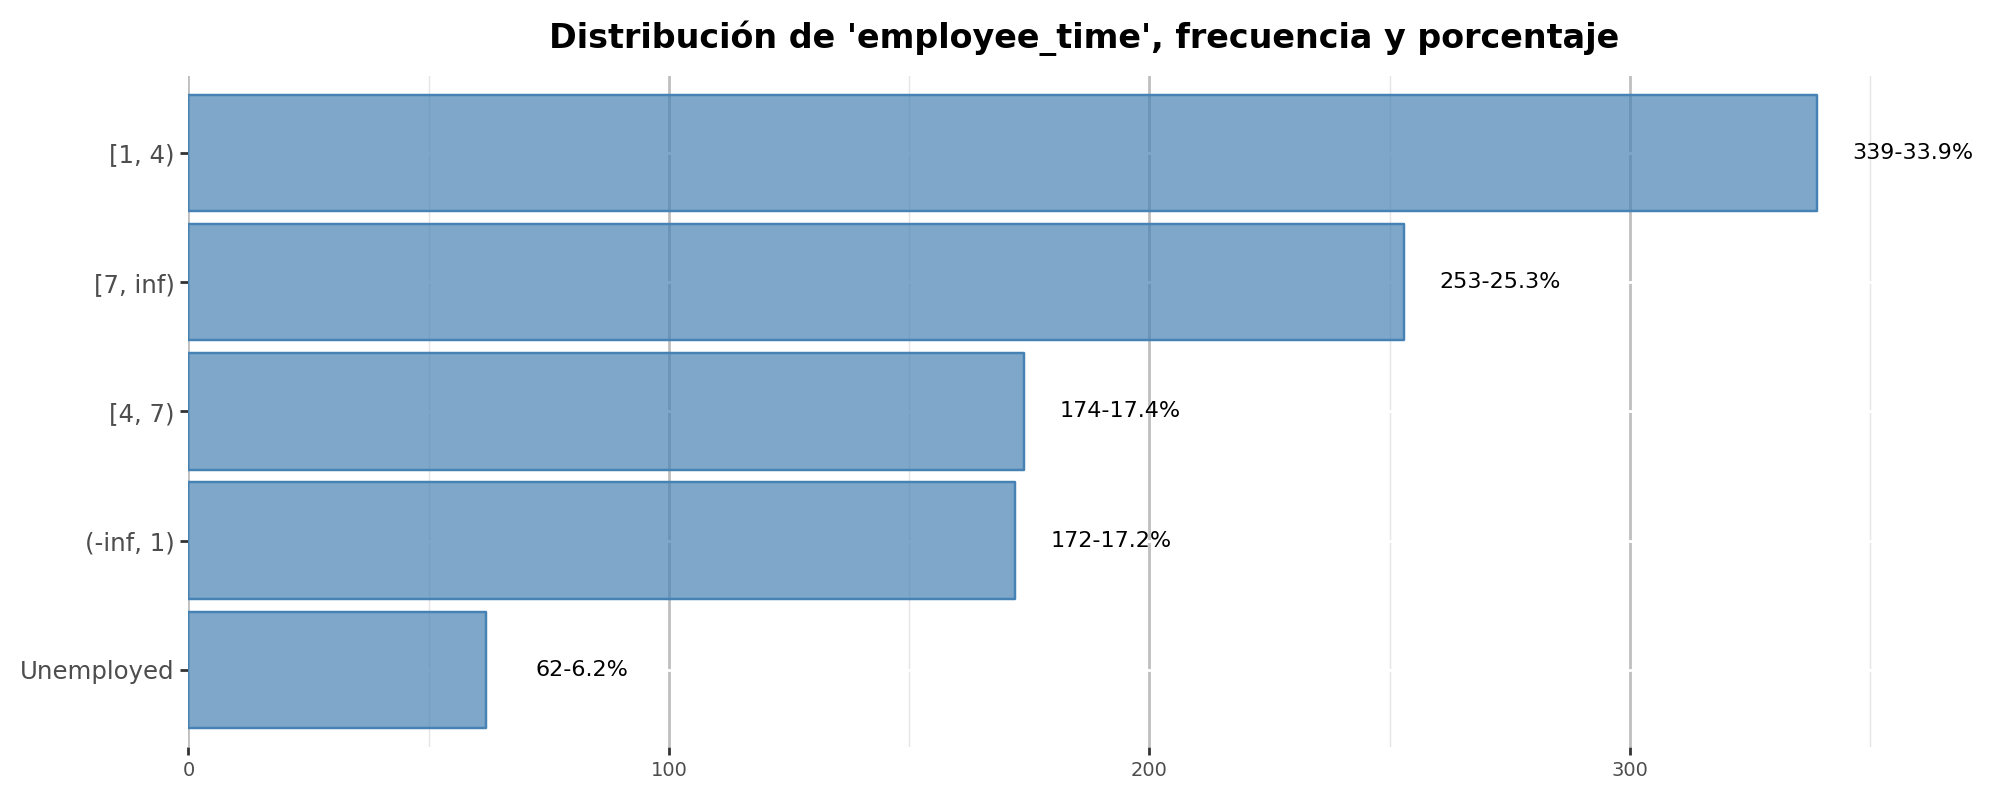

In [160]:
col = discrete_col[4]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),20)
bar_plot.show()

**'employee_time'**, presenta 5 valores posibles respecto a la información sobre el tiempo que lleva trabajando el solicitante, no presenta valores perdidos (nan), presenta una distribución razonable.

### personal_status
Estado civil y sexo

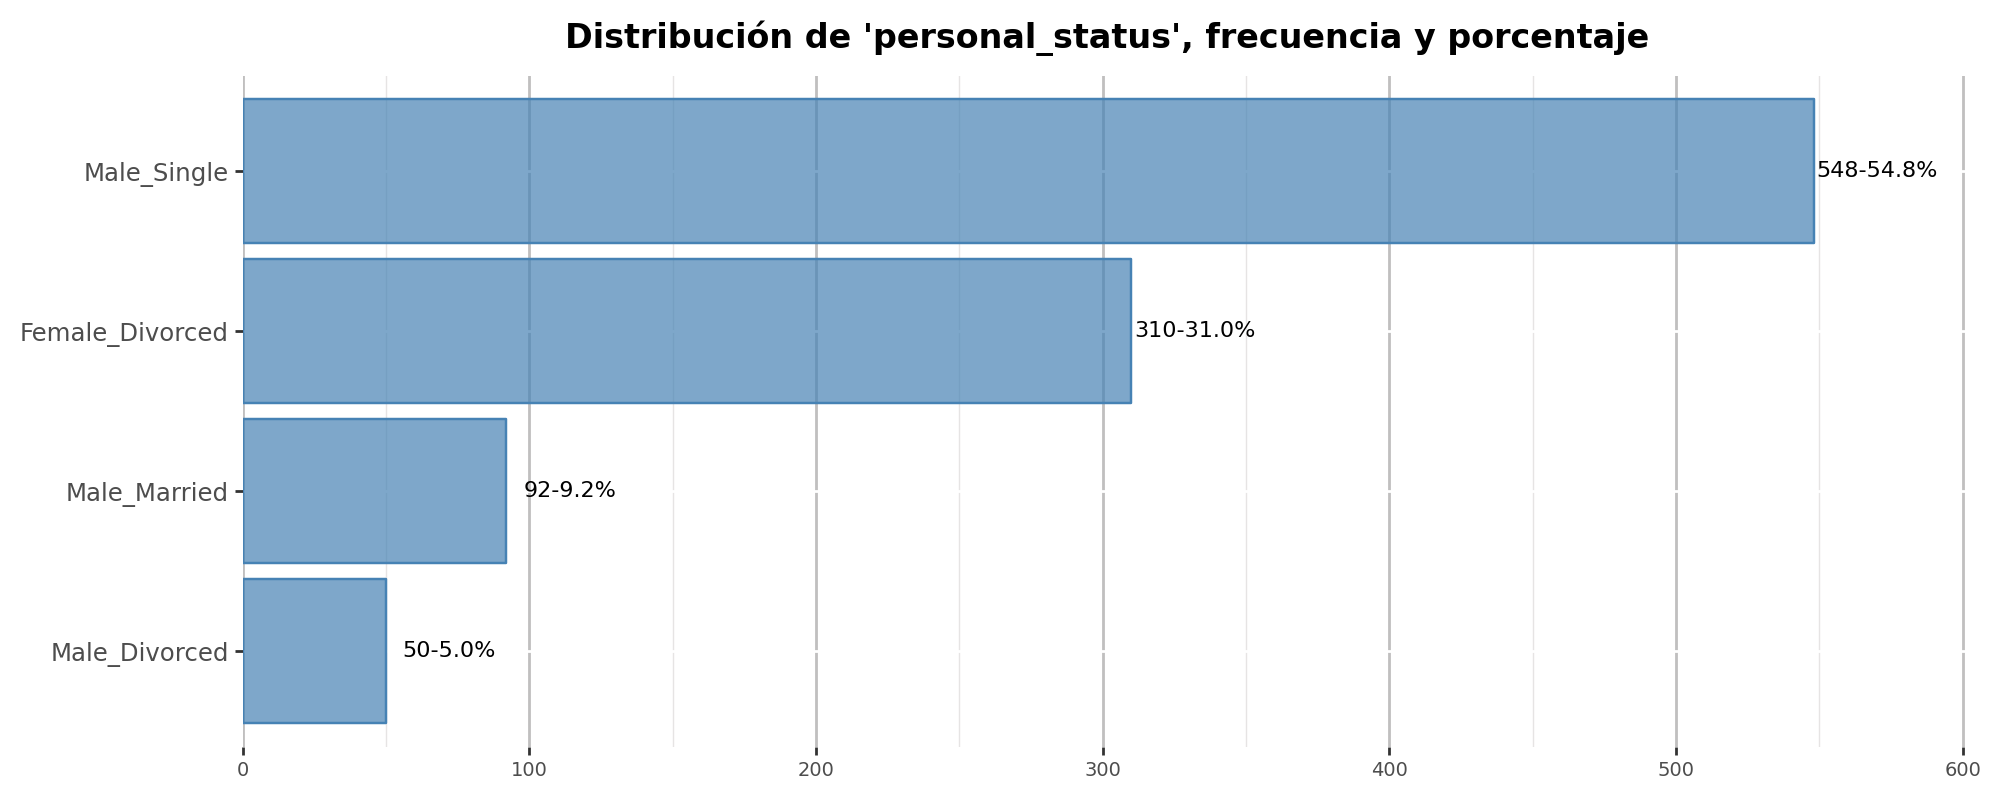

In [161]:
col = discrete_col[5]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),22)
bar_plot.show()

**'personal_status'**, presenta 4 valores posibles respecto a la información sobre el estado civil y el sexo.
Llama la atención que solo haya detalle del estado civil para 'Male' y que 'Female' solo este 'Divorced', Explorar la posibilidad de dividir esta información, cosa de tener una variable solo para el sexo (Male, Female) y otra para el estado civil (Single,Divorced,Married). No presenta valores perdidos (nan).

### other_guarantors
otros avalistas

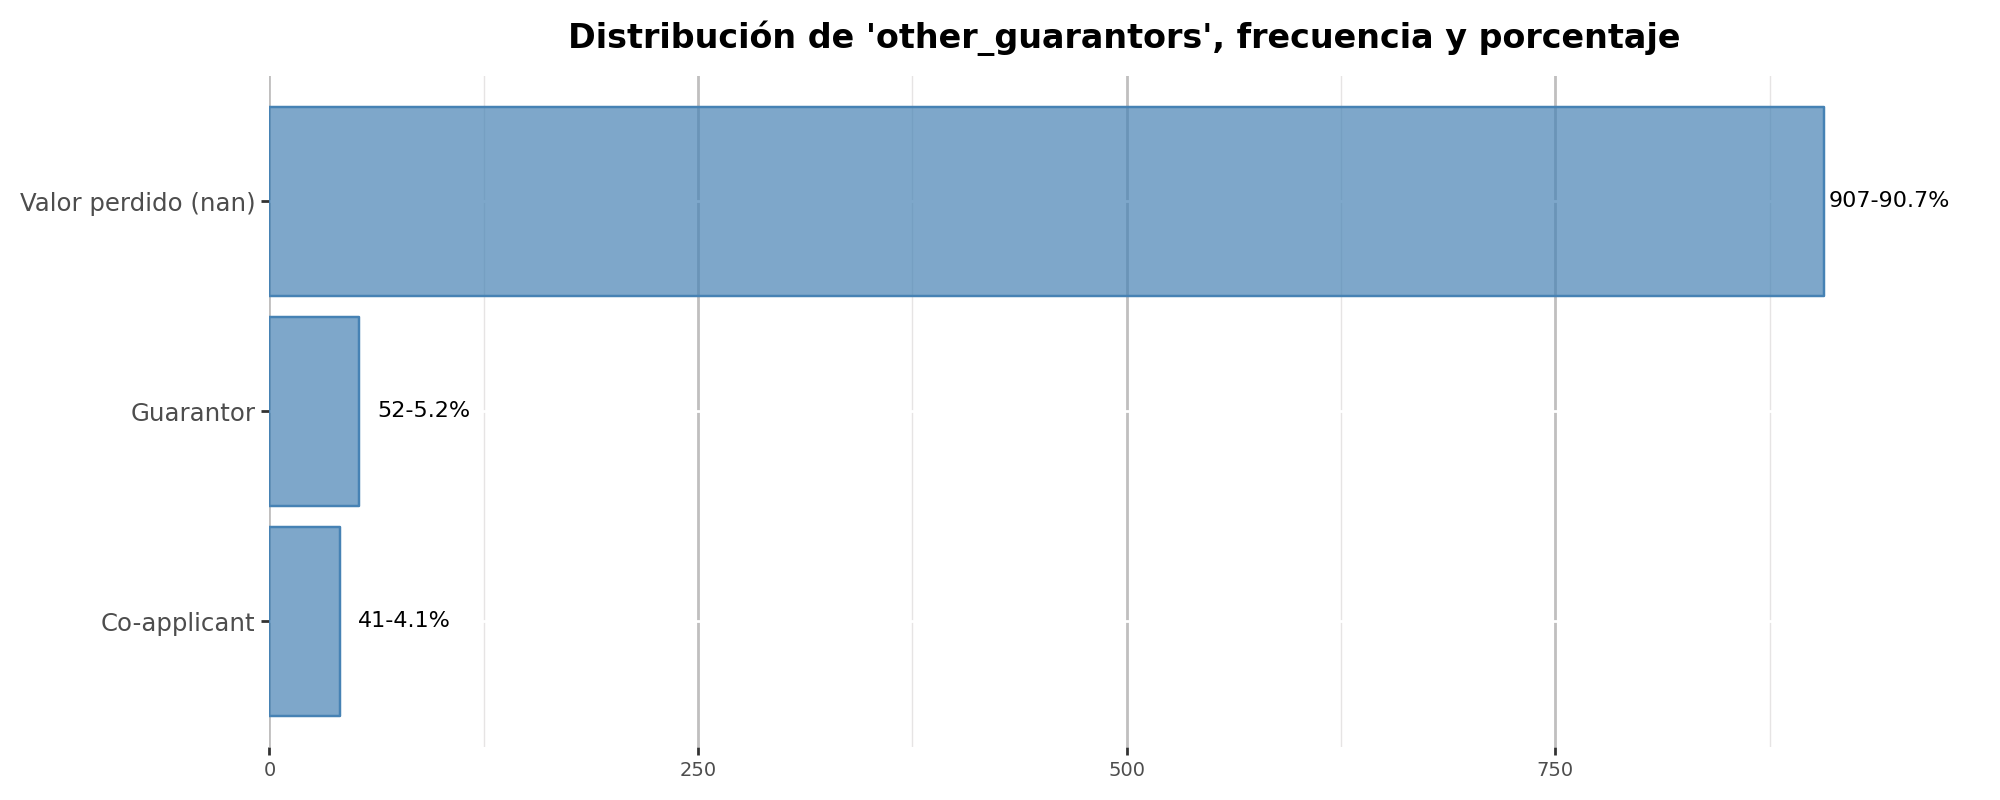

In [162]:
col = discrete_col[6]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),38)
bar_plot.show()

**'other_guarantors'**, presenta 2 valores posibles respecto a la información sobre otros avalistas.
Solo un 9.3% presenta información al respecto, el resto solo presenta valores perdidos (nan). Lo cual se puede interpretar como que esas personas solicitan el préstamo totalmente individual, sin aval o co-aplicante.

### property
Propiedad

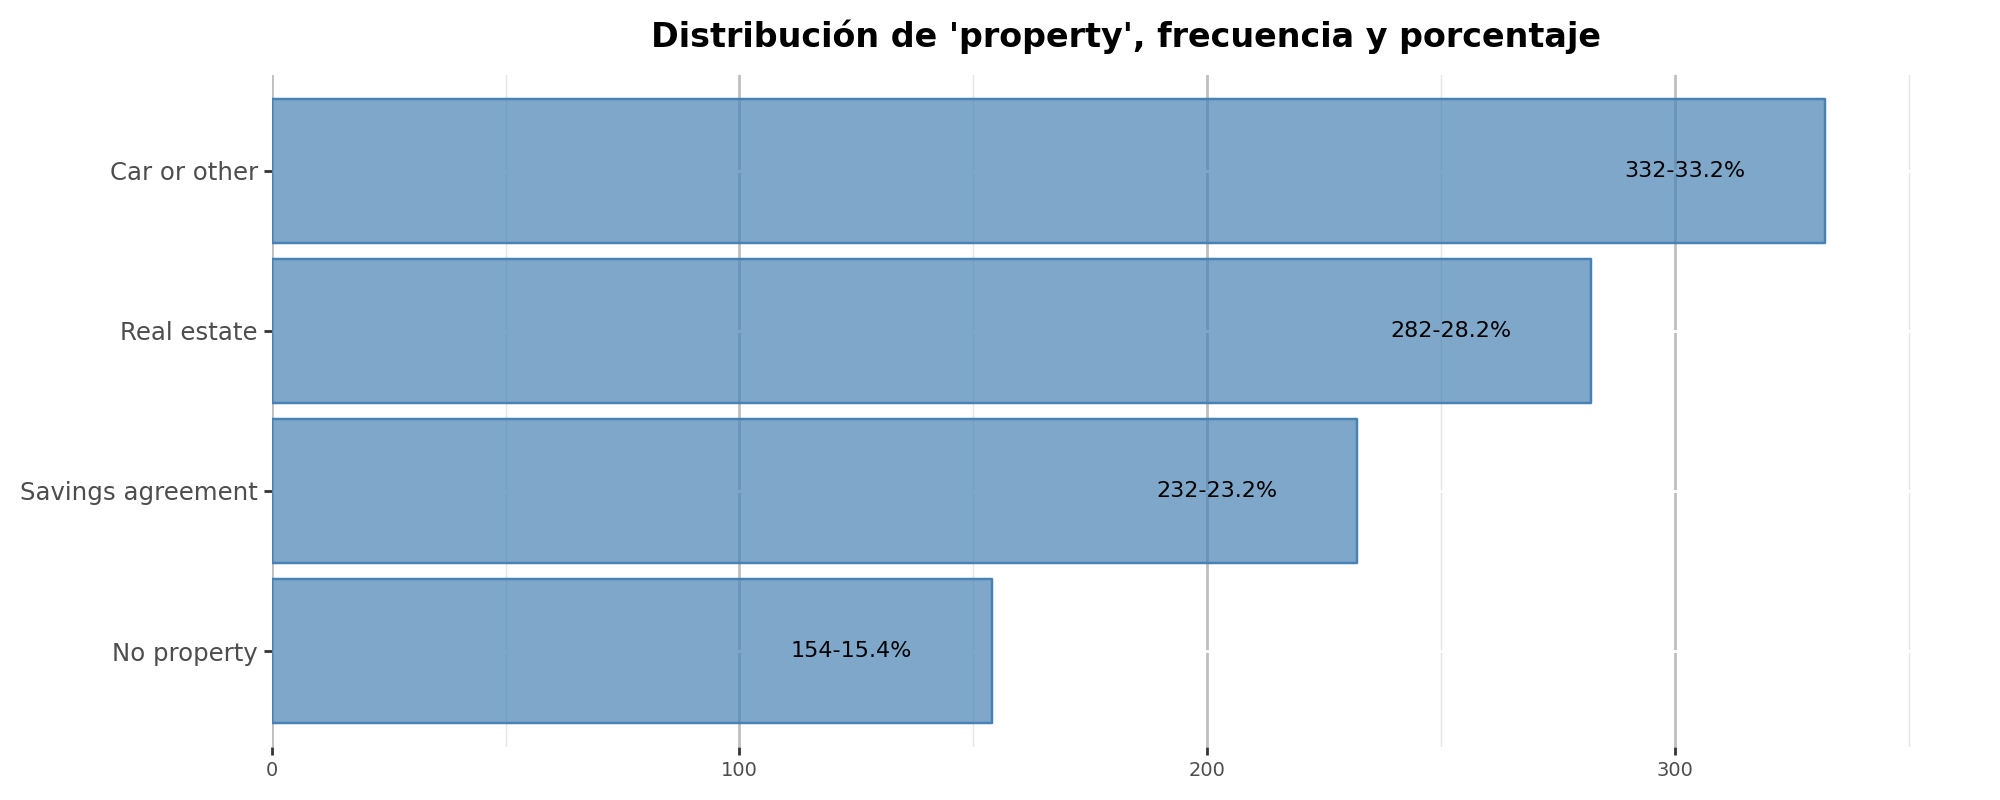

In [163]:
col = discrete_col[7]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),-30)
bar_plot.show()

**'property'**, presenta 4 valores posibles respecto a la información sobre si el solicitante posee alguna propiedad.
Presenta una distribución razonable. No presenta valores perdidos (nan).

### other_installment_plans
Otros planes de pago a plazos

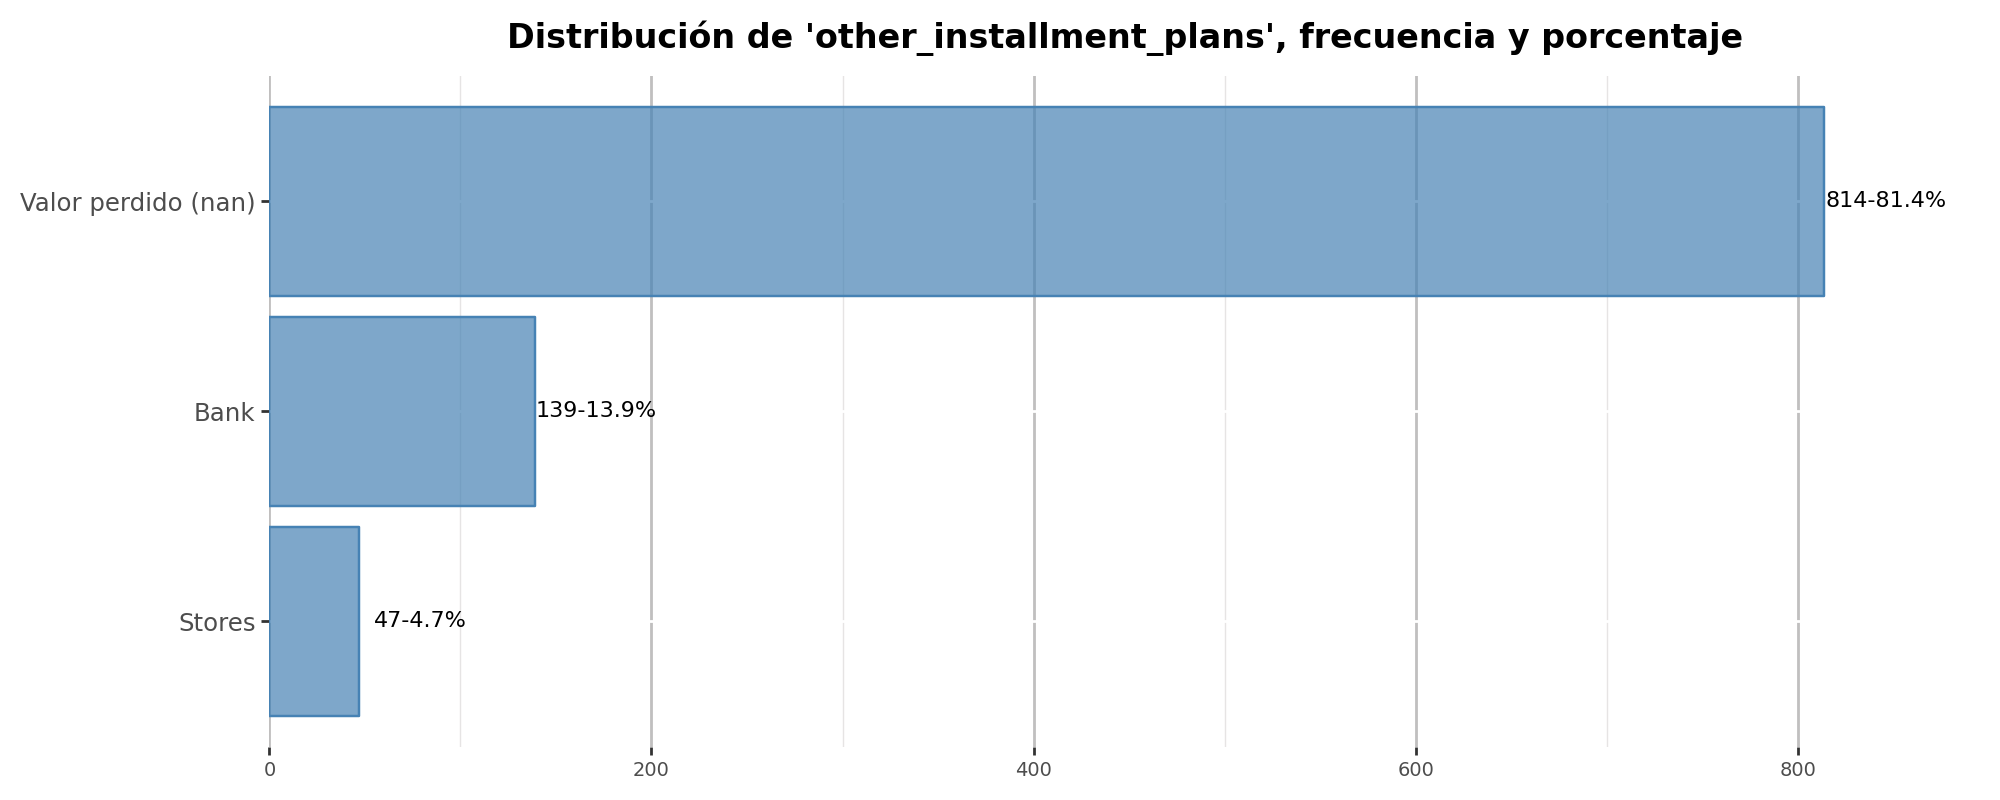

In [164]:
col = discrete_col[8]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),32)
bar_plot.show()

**'other_installment_plans'**, presenta 2 valores posibles respecto a la información sobre otros avalistas.
Solo un 18.6% presenta información al respecto, el resto solo presenta valores perdidos (nan). Lo cual se puede interpretar como que la persona no tenga prestamos/créditos en otras instituciones.

### housing
Tipología de hogar (alquiler, propio...)

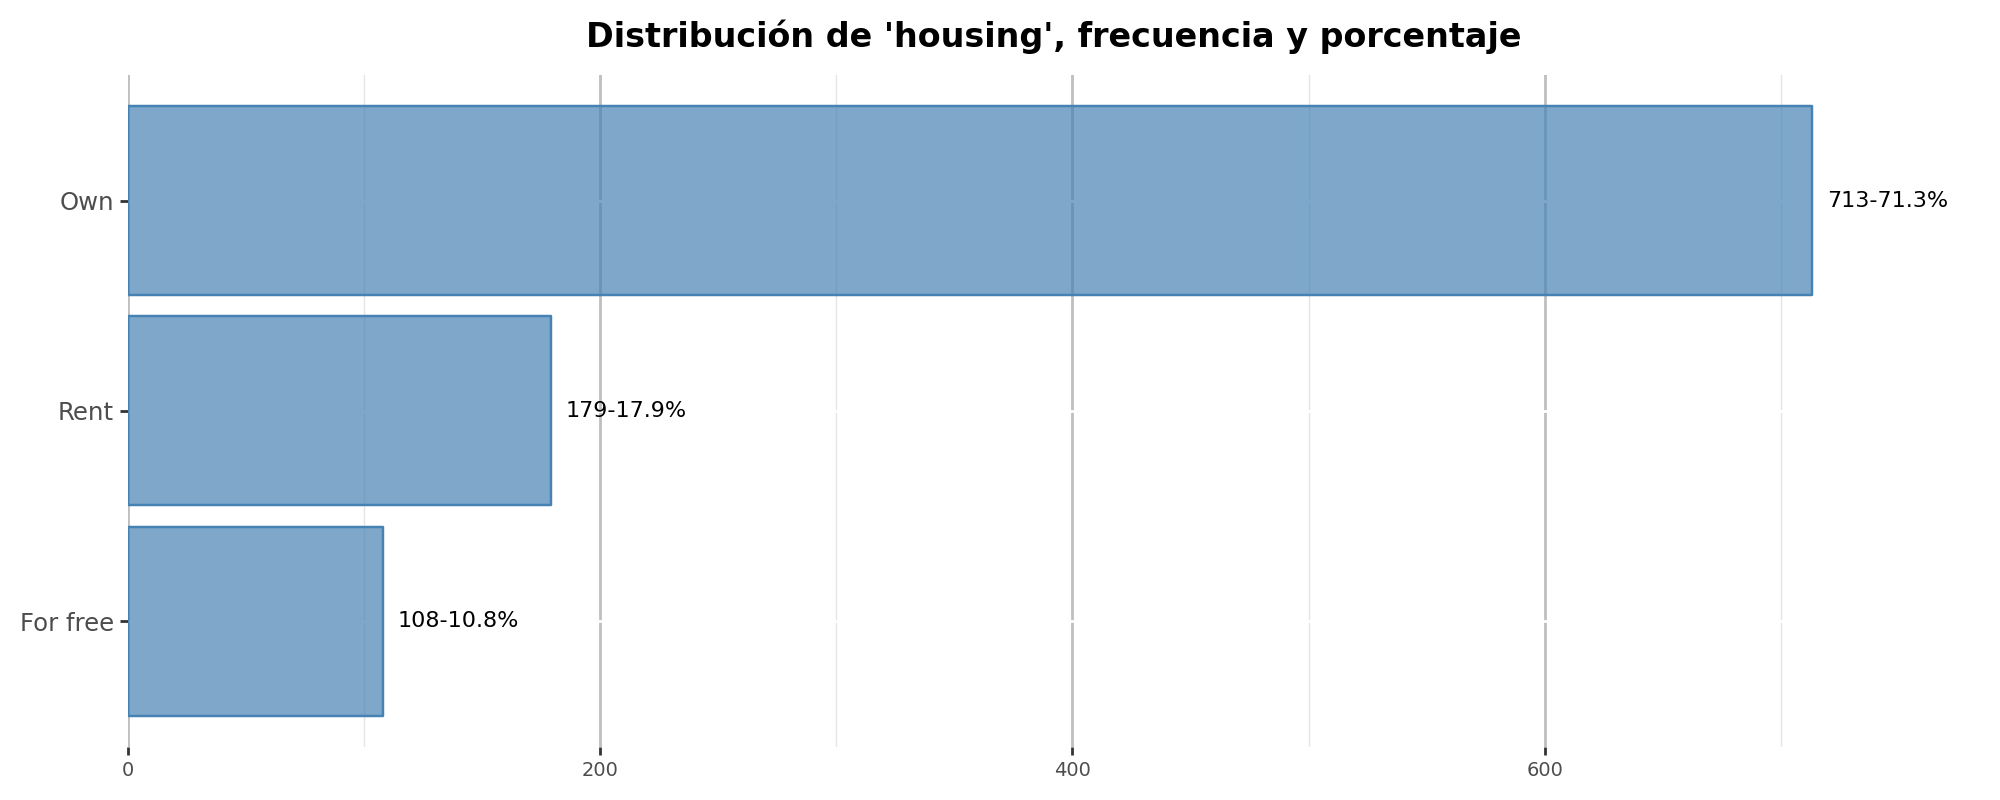

In [165]:
col = discrete_col[9]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),32)
bar_plot.show()

**'housing'**, presenta 3 valores posibles respecto a la información sobre donde vive. Gran parte de los solicitantes (71.3%), son propietarios de su vivienda. No presenta valores perdidos (nan).

### job
Tipo de empleo

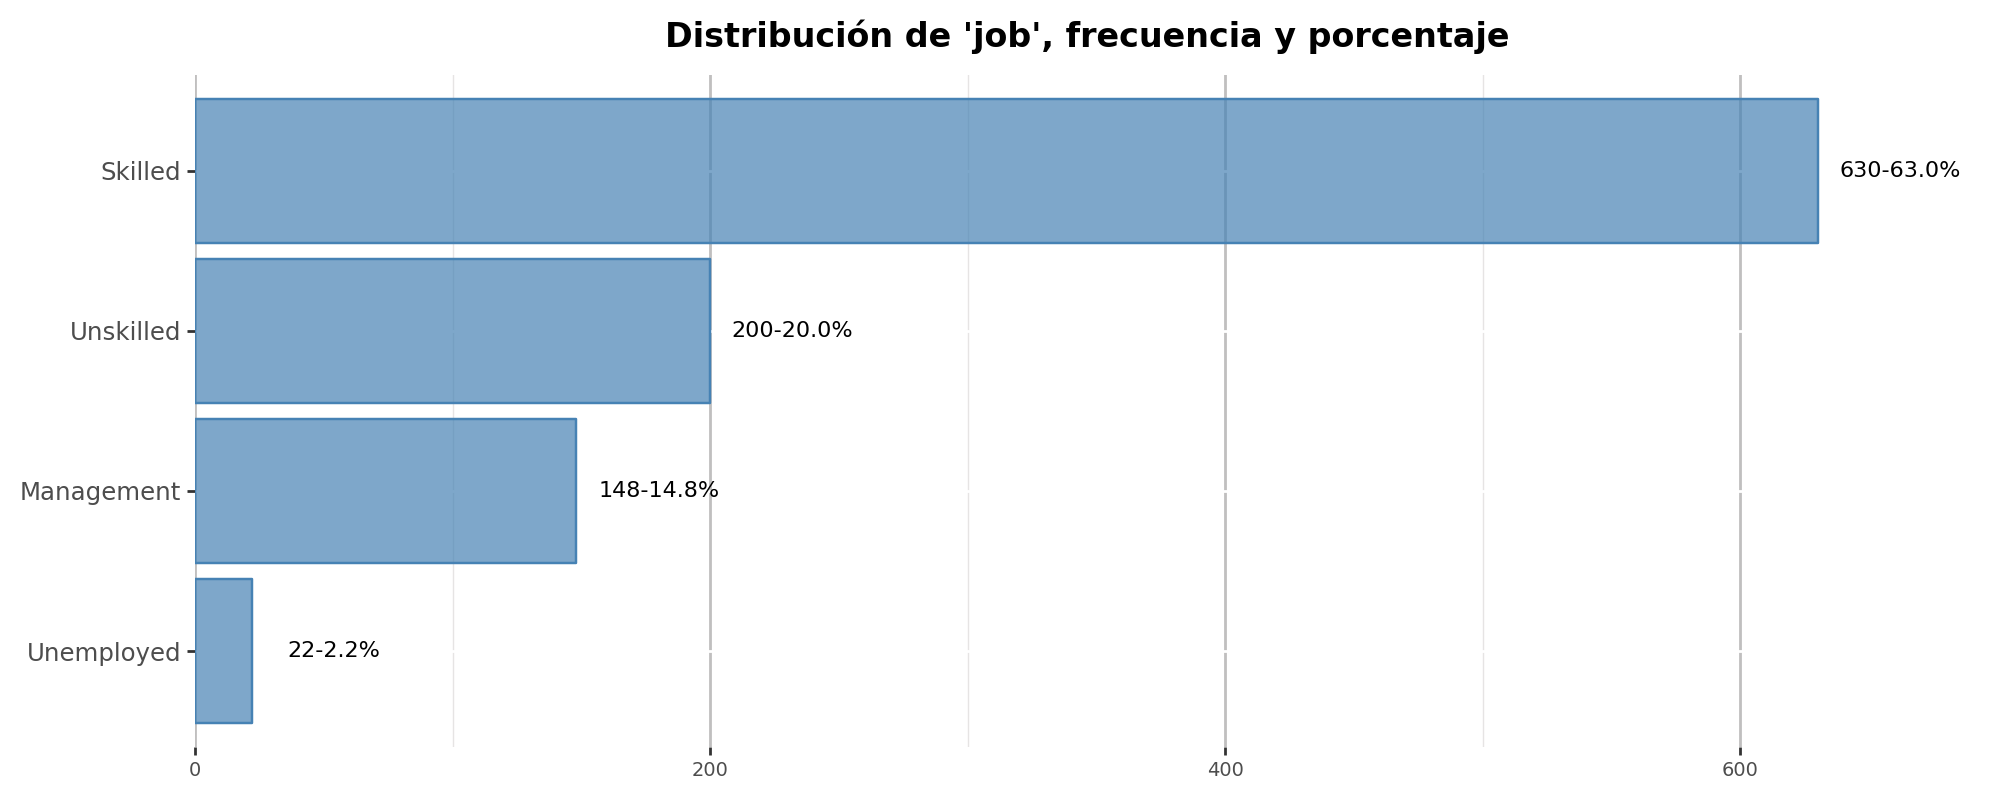

In [166]:
col = discrete_col[10]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),32)
bar_plot.show()

**'job'**, presenta 4 valores posibles respecto a la información sobre su empleo. Gran parte de los solicitantes (63%), de ellos son empleados cualificados. Lo que indicaría un nivel de ingresos estable. No presenta valores perdidos (nan).

### telephone
La persona solicitante posee o no un teléfono

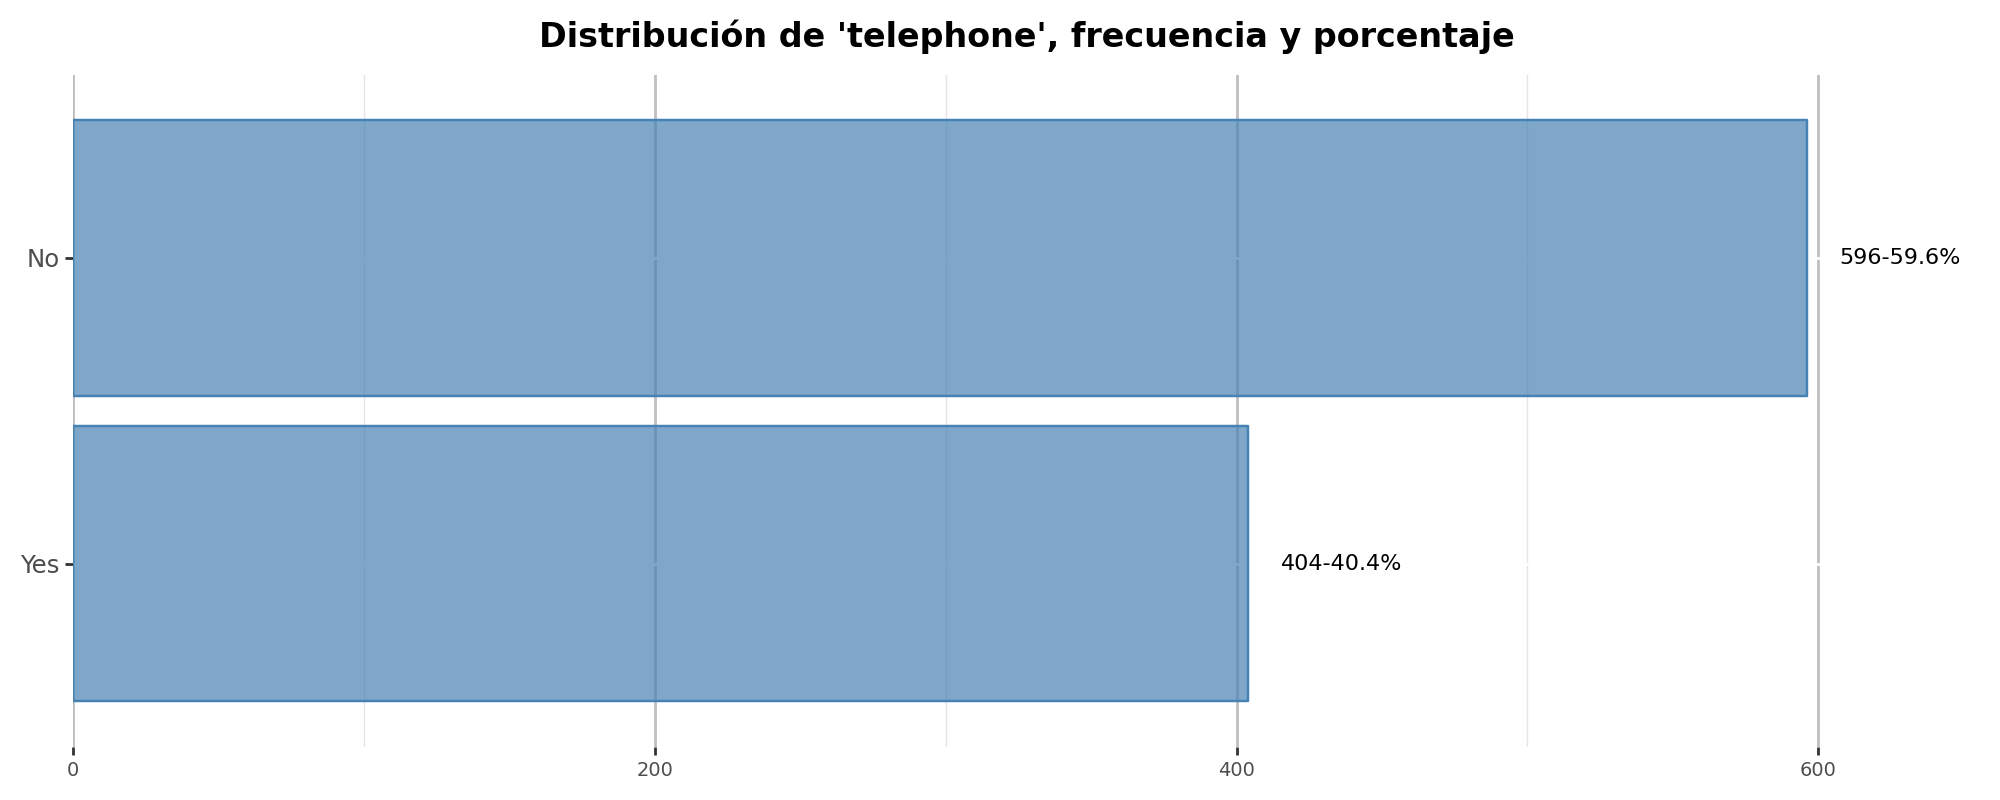

In [167]:
col = discrete_col[11]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),32)
bar_plot.show()

**'telephone'**, presenta 2 valores posibles respecto a si el solicitante posee o no un teléfono. No presenta valores perdidos (nan).

### foreign_worker
Trabajador extranjero

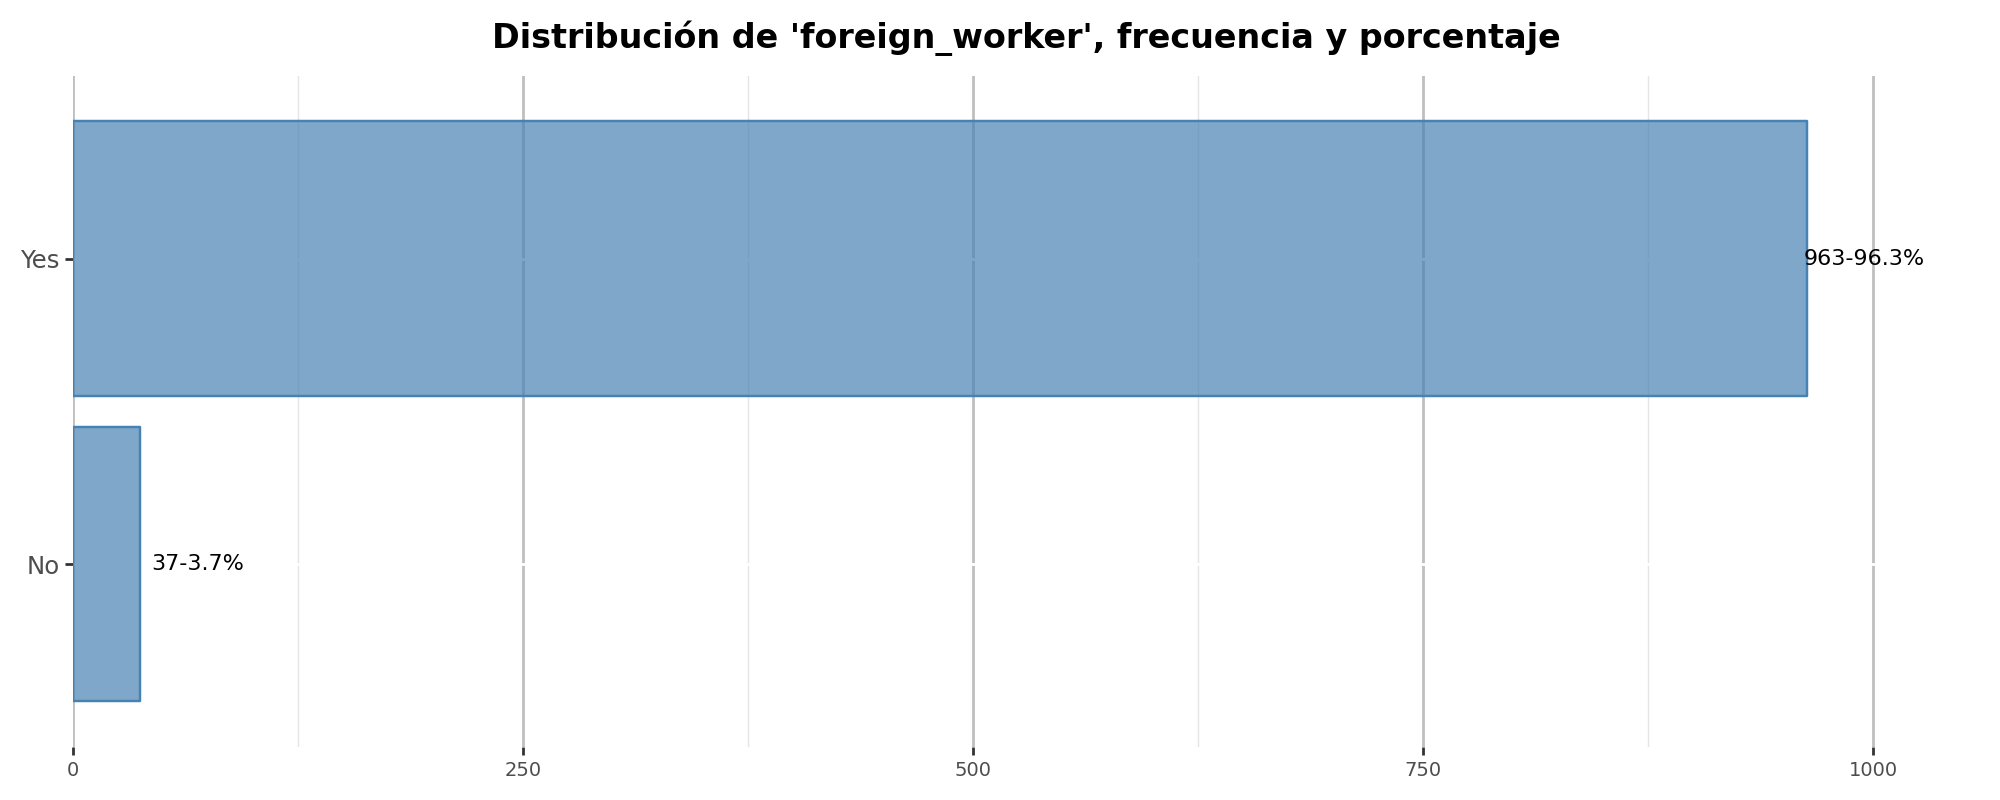

In [168]:
col = discrete_col[12]
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),32)
bar_plot.show()

**'foreign_worker'**, presenta 2 valores posibles respecto a si el solicitante es o no extranjero. No presenta valores perdidos (nan).

### target
- 1: Cliente cumplidor
- 2: Cliente que incumplió

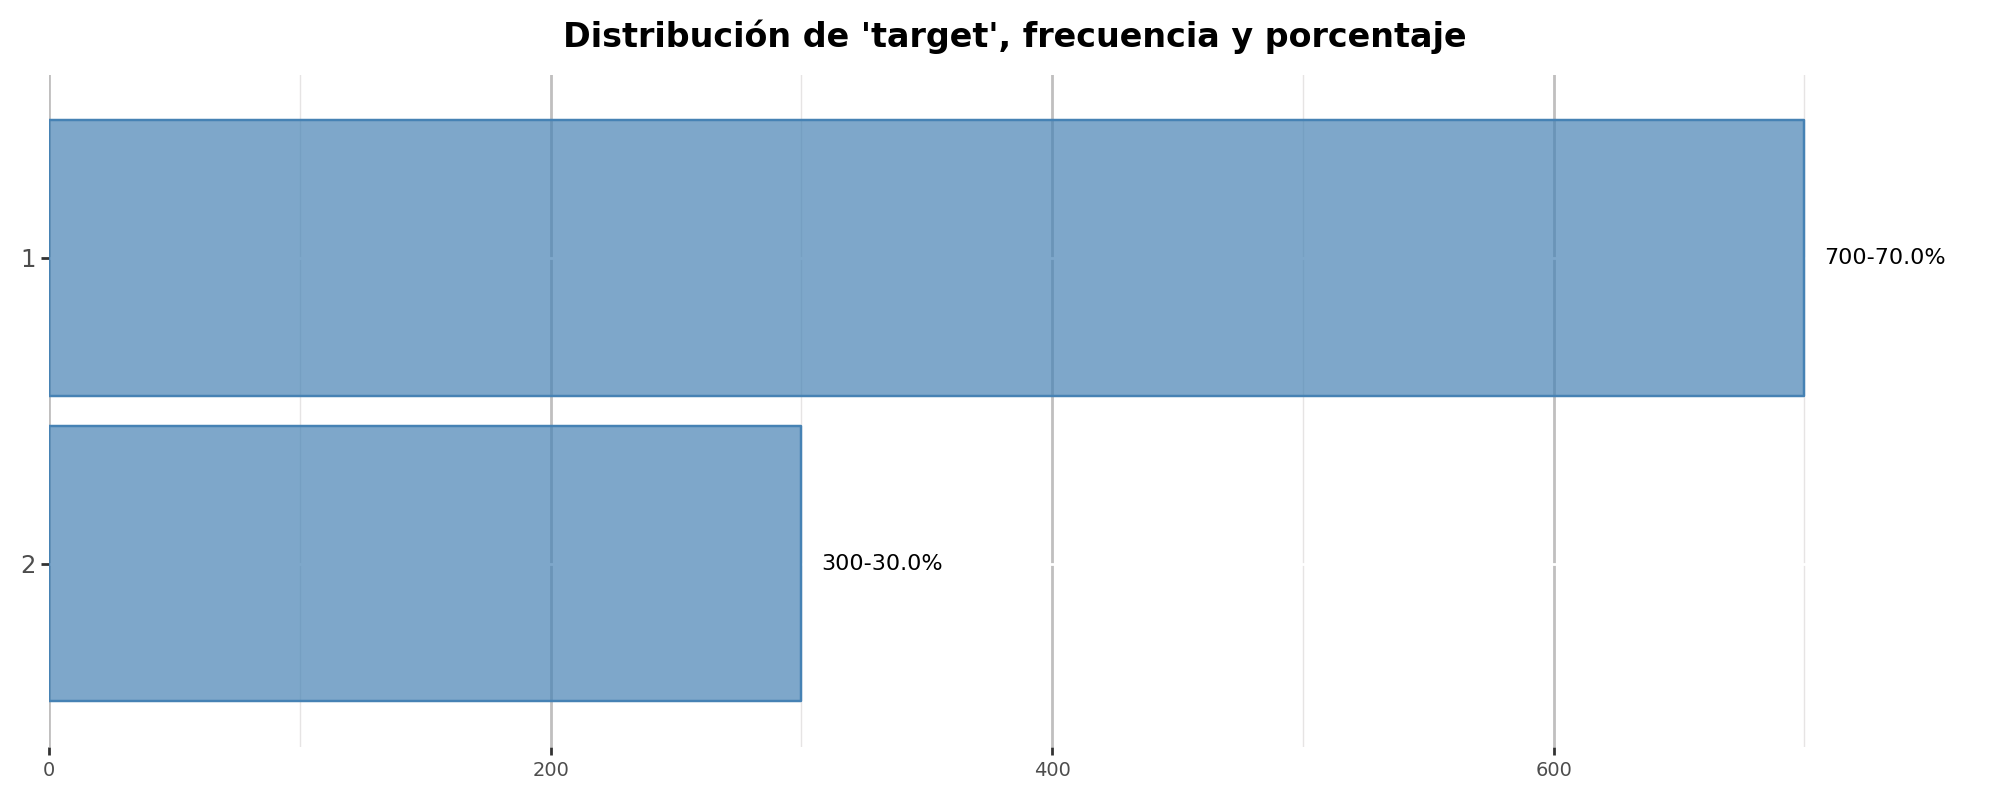

In [169]:
col = discrete_col[13]
# Transformamos a string antes de graficar
data[col] = data[col].astype(str)
bar_plot = ut.bar_plot(data, col,'steelblue',(10,4),32)
bar_plot.show()

**'target'**, presenta 2 valores posibles respecto a si el solicitante cumplió o incumplió con los pagos.

# Acciones a realizar luego del análisis univariante

Se mueven las variables **'installment_rate','time_present_residence','number_credit','number_of_dependant'** a variables categóricas.

In [170]:
cols_to_move = ['installment_rate','time_present_residence','number_credits','number_of_dependants']

# Actualizamos las variables discretas
discrete_col = discrete_col + cols_to_move

# Actualizamos las variables continuas
cuantitative_col = [col for col in cuantitative_col if col not in cols_to_move]

# Analisis bivariante
Comparamos, para cada variable, las distribuciones de los buenos (continuan siendo clientes) y de los malos (exclientes).

Establecemos el código de colores por variable target

In [171]:
colors_per_group = {'1':'seagreen','2':'red'}

## Variables continuas

In [172]:
discrete_col

['status_account',
 'credit_history',
 'purpose',
 'savings_account',
 'employee_time',
 'personal_status',
 'other_guarantors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker',
 'target',
 'installment_rate',
 'time_present_residence',
 'number_credits',
 'number_of_dependants']

In [173]:
cuantitative_col

['duration', 'credit_amount', 'age']

### duration

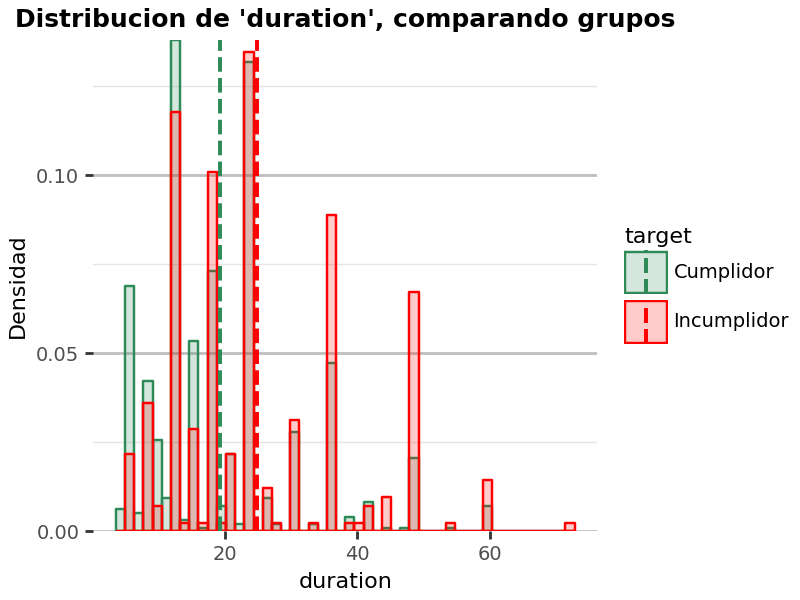

In [175]:
col=cuantitative_col[0]
hist_pre_target_plot = ut.hist_per_target_plot(data,col,'target',colors_per_group,(4,3))
hist_pre_target_plot.show()

### credit_amount

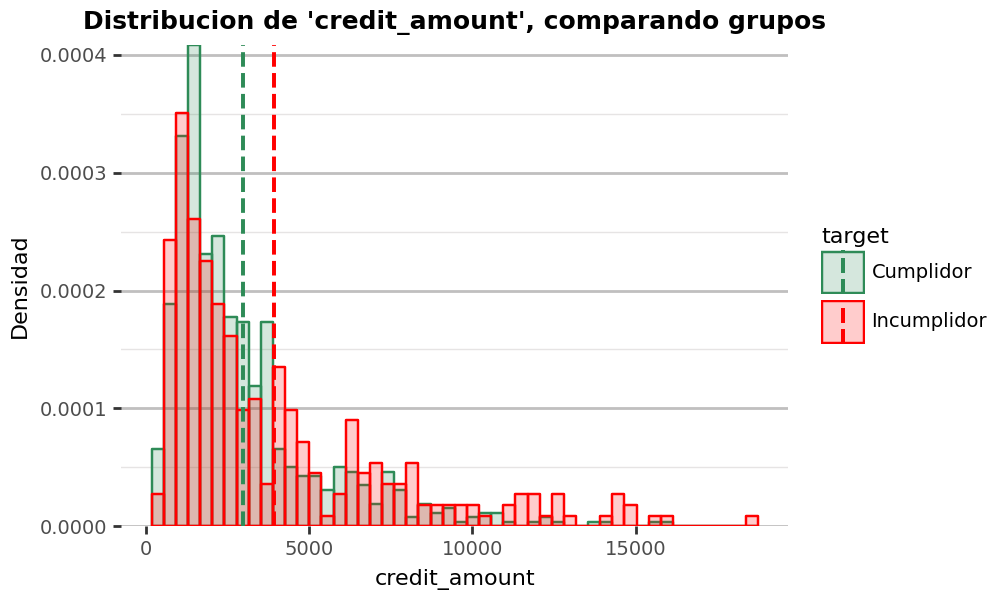

In [180]:
col=cuantitative_col[1]
hist_pre_target_plot = ut.hist_per_target_plot(data,col,'target',colors_per_group,(5,3))
hist_pre_target_plot.show()

### age

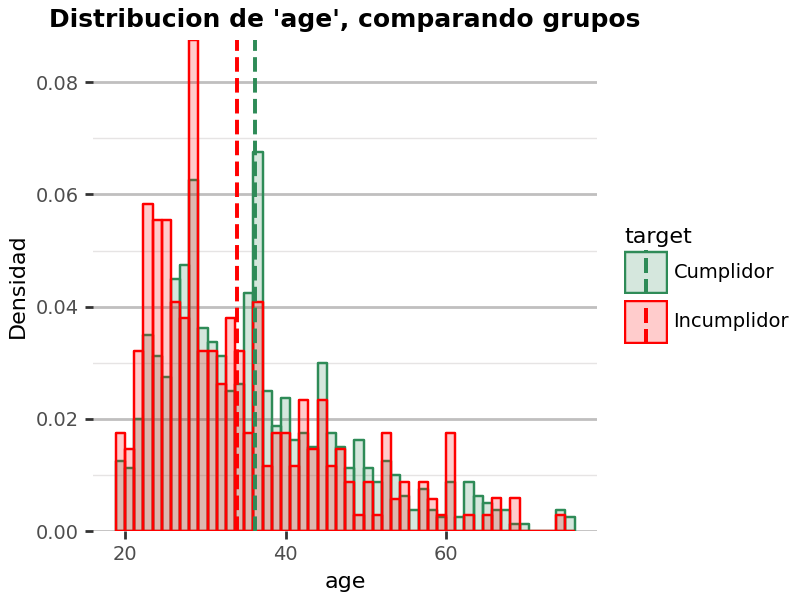

In [178]:
col=cuantitative_col[2]
hist_pre_target_plot = ut.hist_per_target_plot(data,col,'target',colors_per_group,(4,3))
hist_pre_target_plot.show()

## Variables categóricas

### status_account

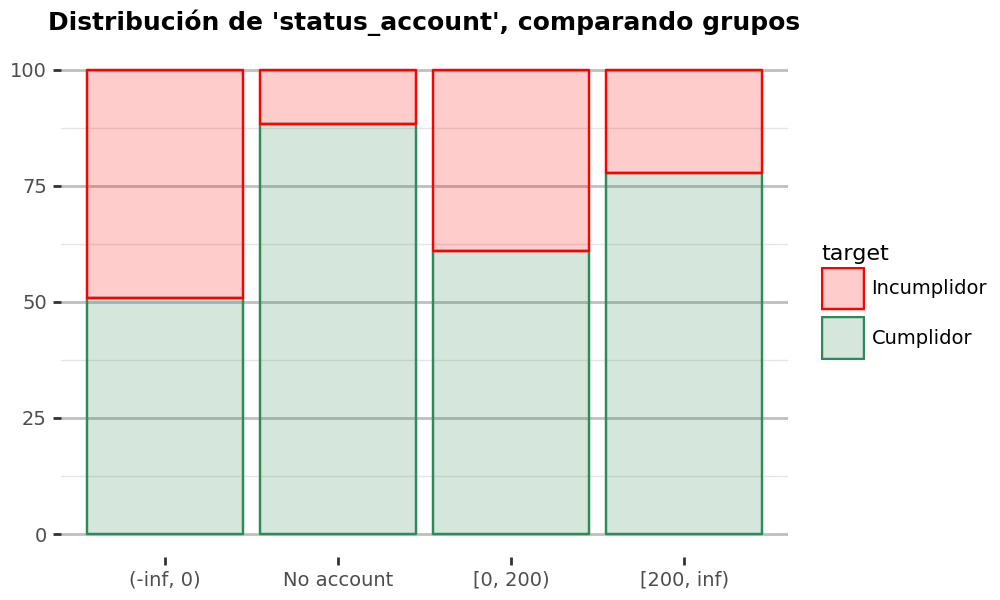

In [182]:
col = discrete_col[0]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### credit_history

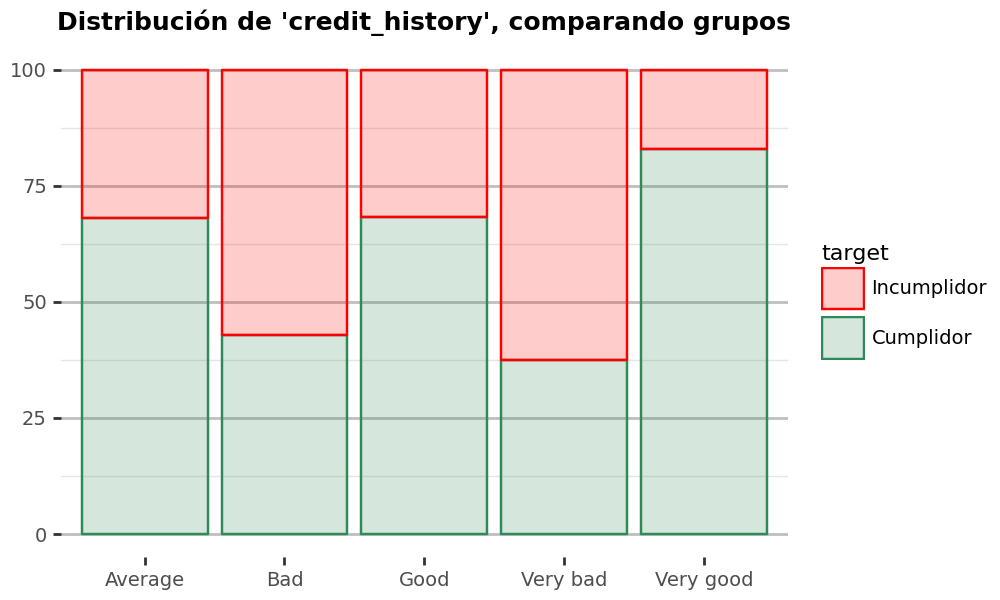

In [183]:
col = discrete_col[1]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### purpose

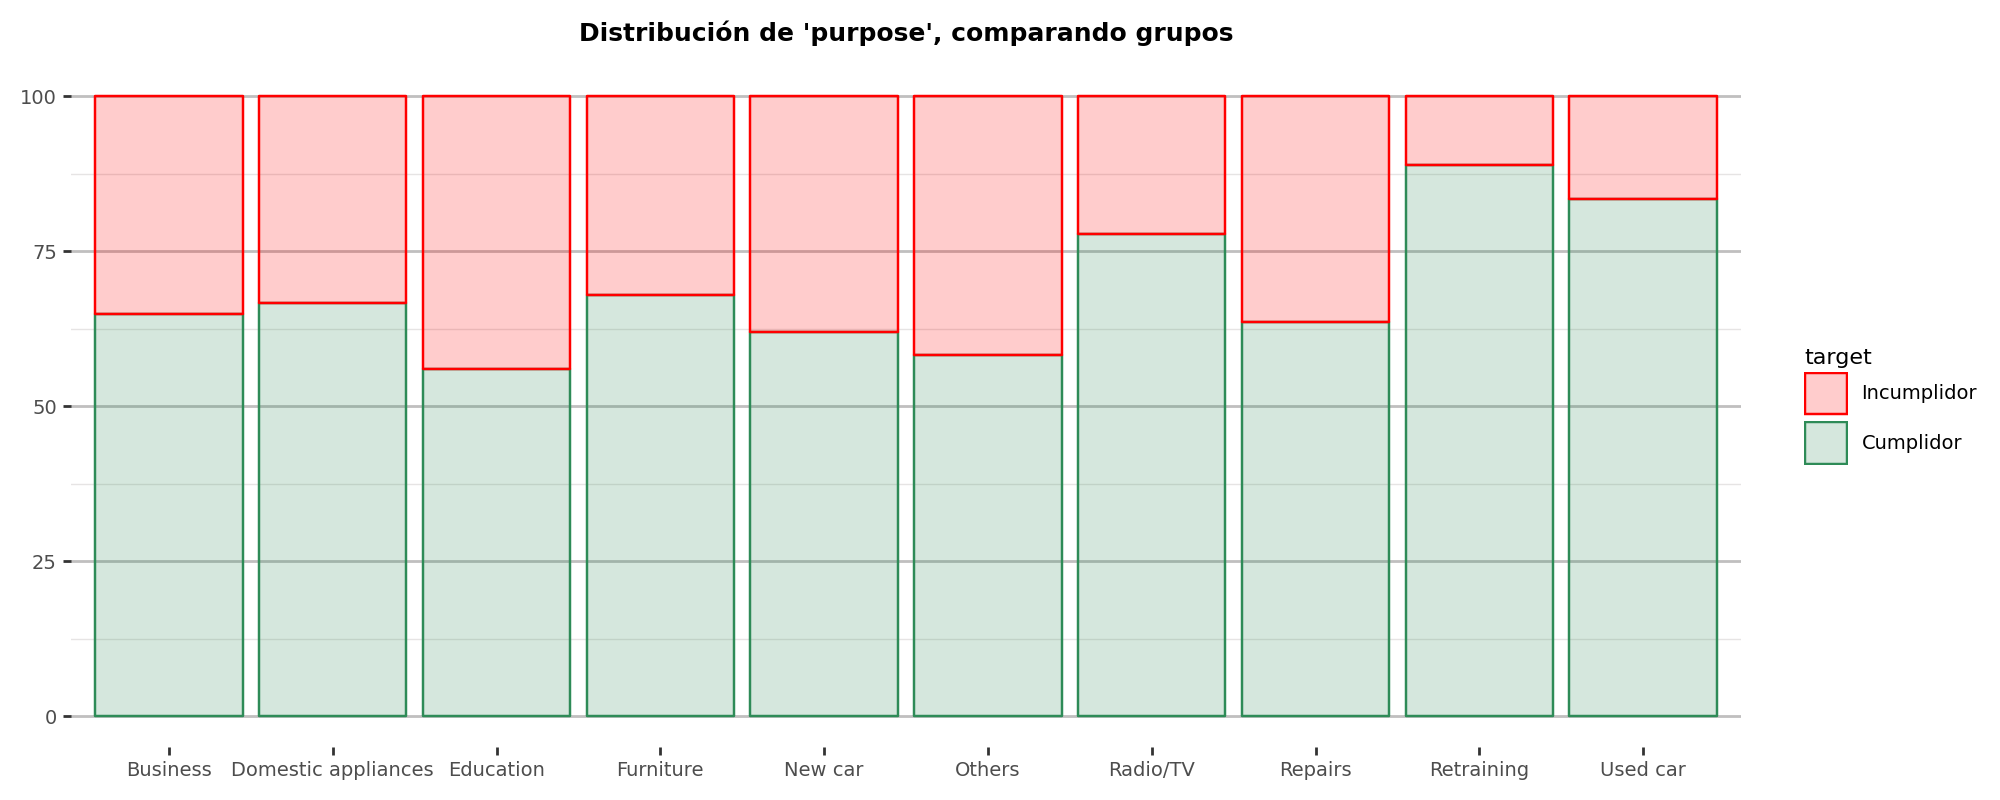

In [115]:
col = discrete_col[2]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(10,4))
cat_variables_per_group.show()

### savings_account

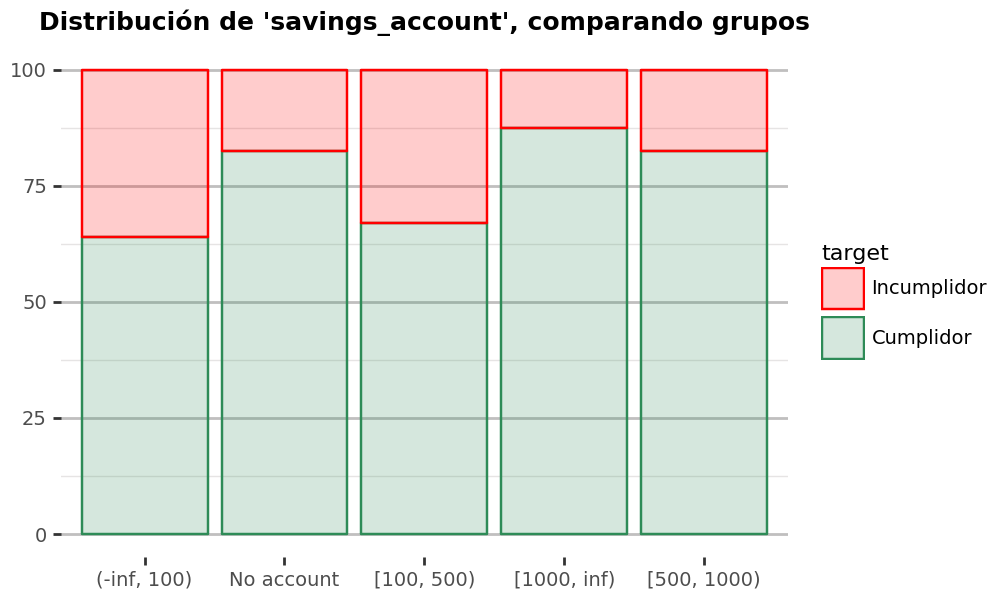

In [184]:
col = discrete_col[3]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### employee_time

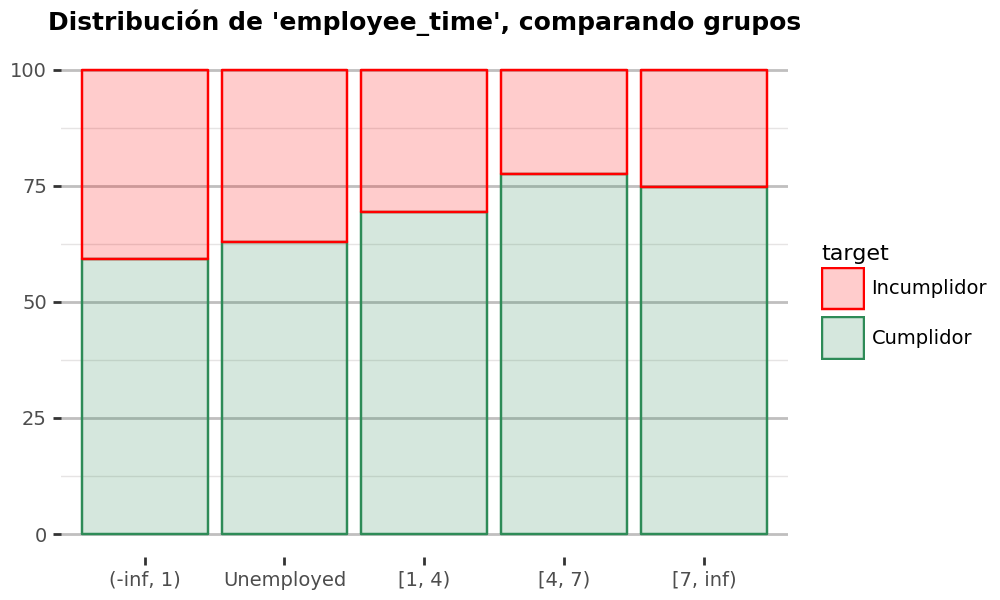

In [185]:
col = discrete_col[4]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### personal_status

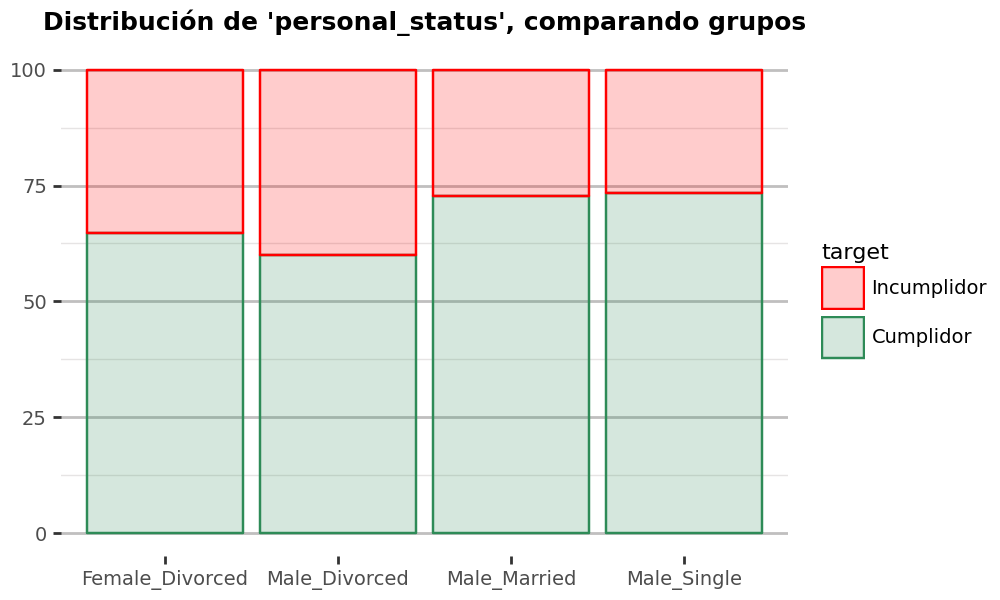

In [187]:
col = discrete_col[5]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### other_guarantors

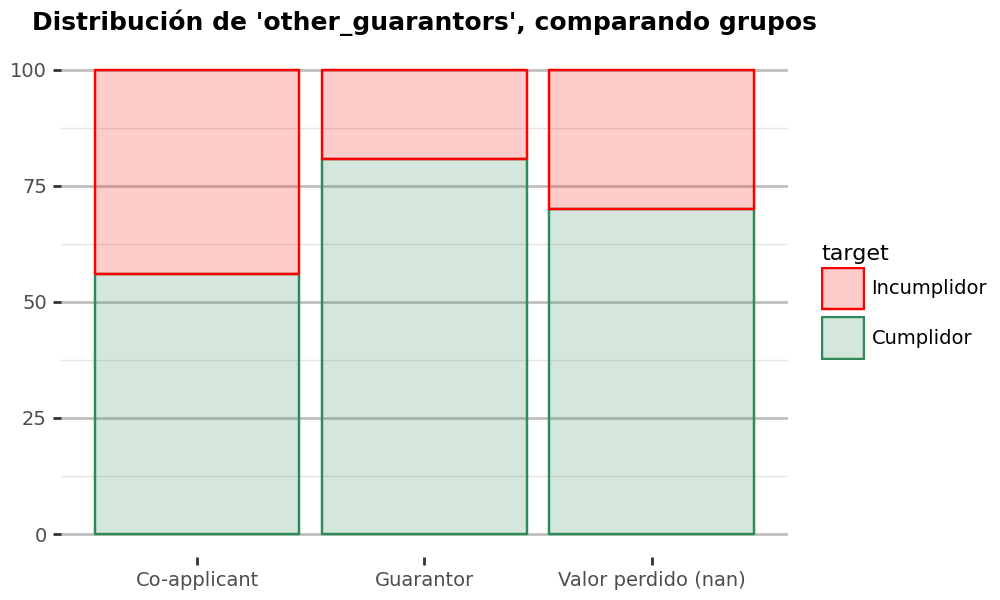

In [188]:
col = discrete_col[6]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### property

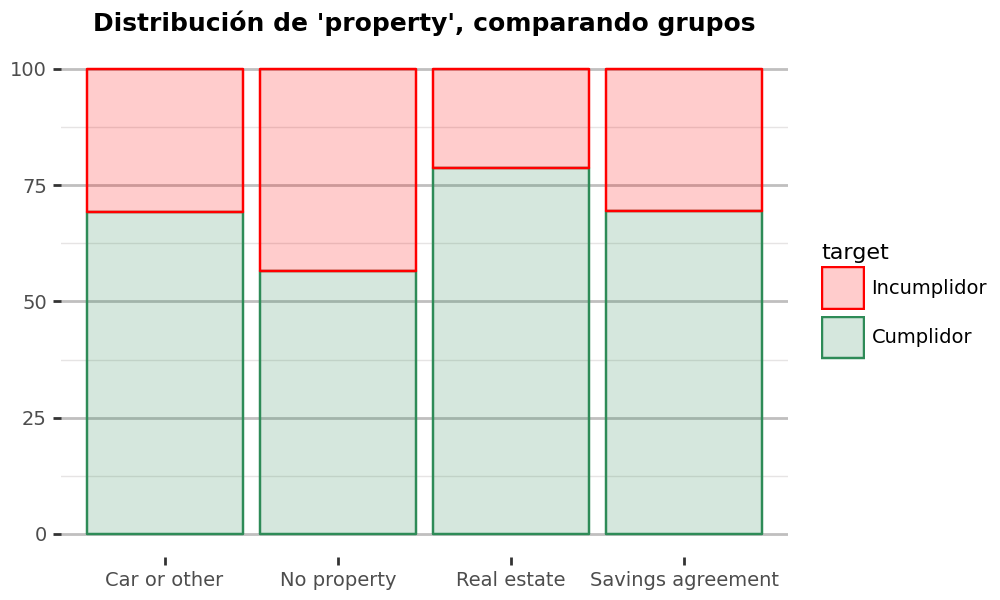

In [189]:
col = discrete_col[7]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### other_installment_plans

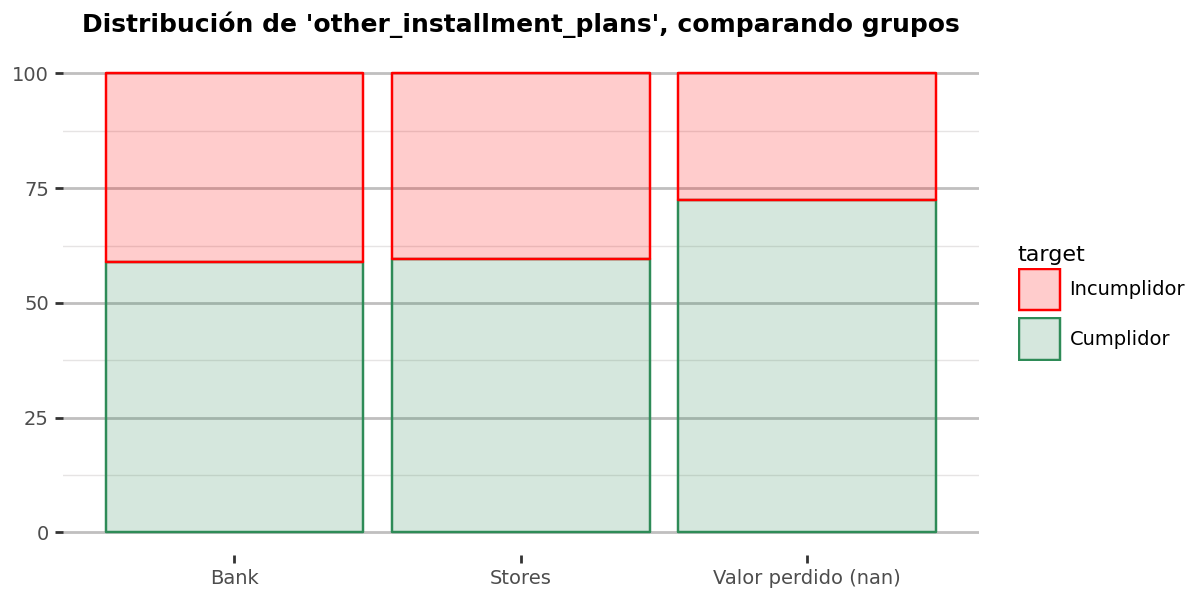

In [191]:
col = discrete_col[8]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(6,3))
cat_variables_per_group.show()

### housing

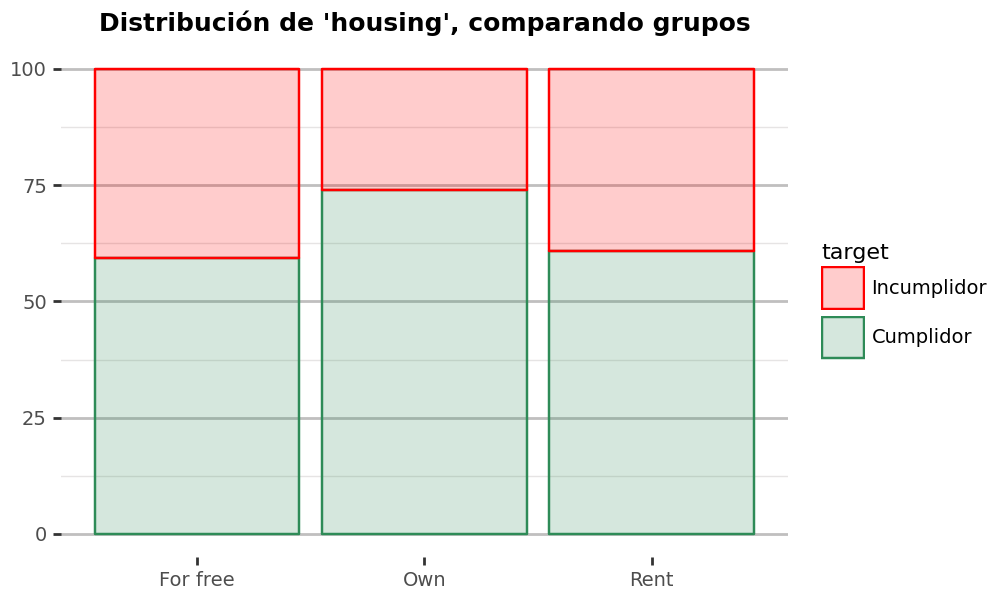

In [192]:
col = discrete_col[9]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### job

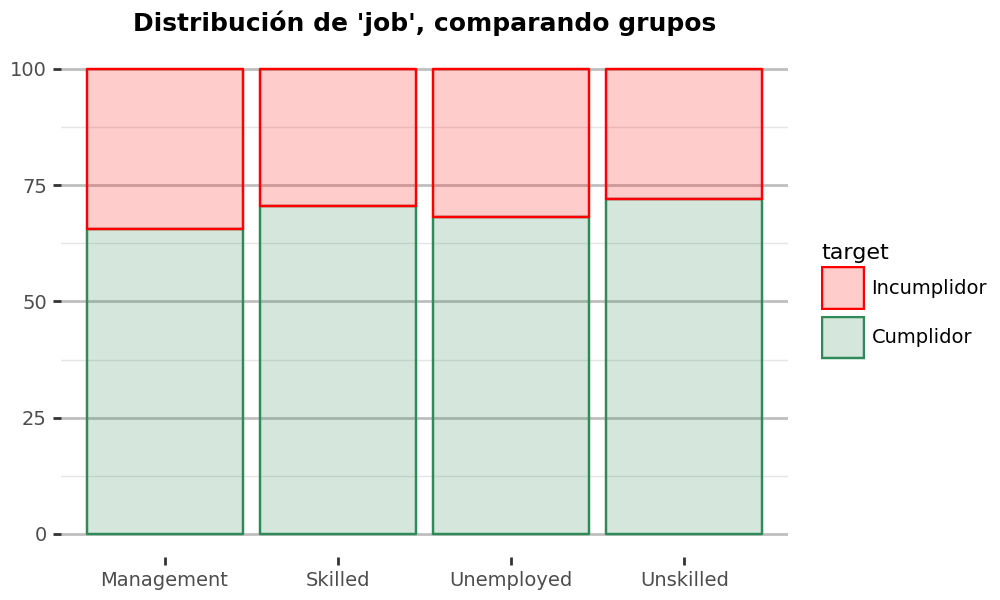

In [193]:
col = discrete_col[10]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### telephone

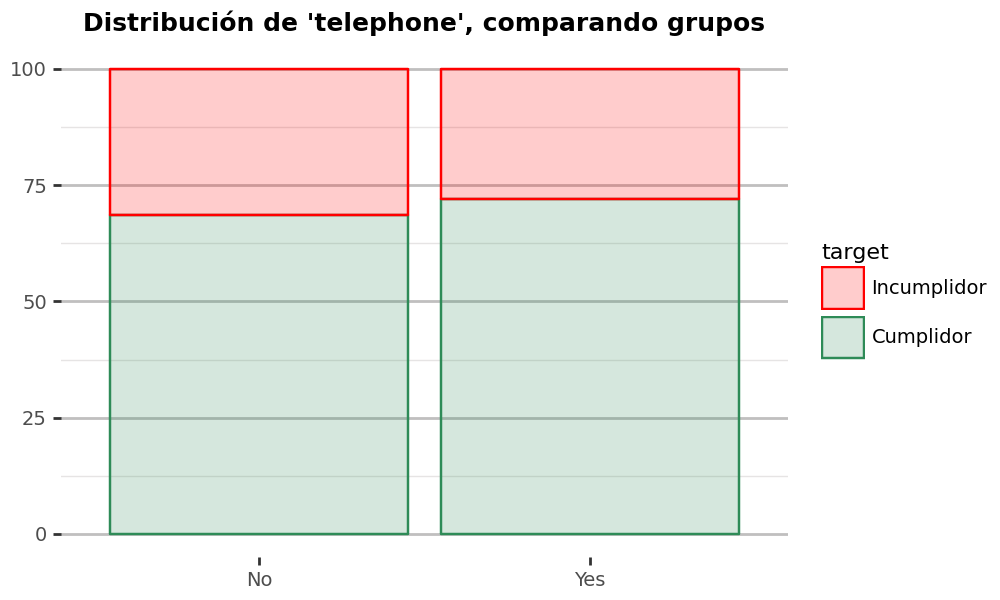

In [194]:
col = discrete_col[11]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### foreing_worker

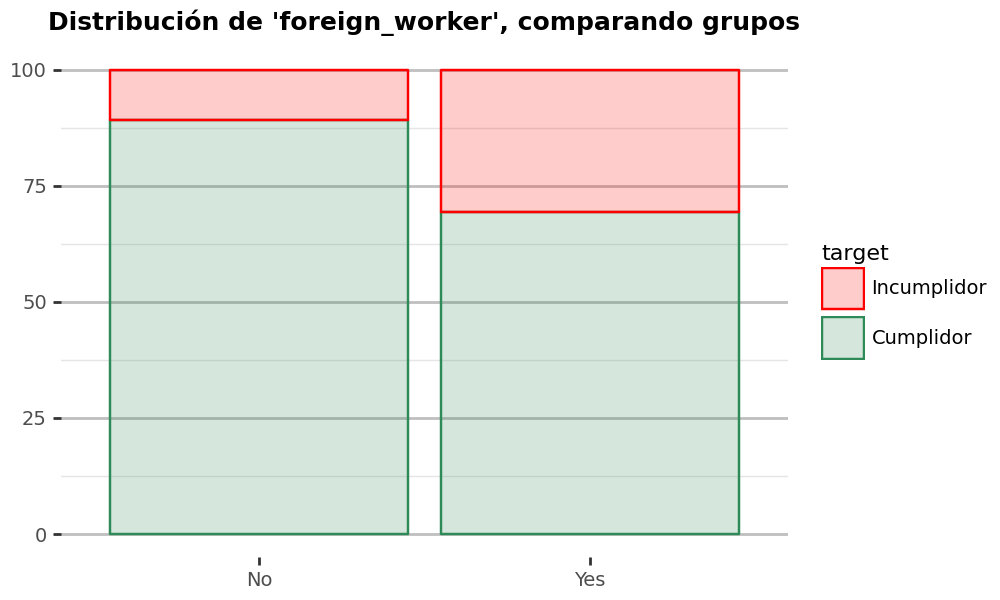

In [195]:
col = discrete_col[12]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### installment_rate

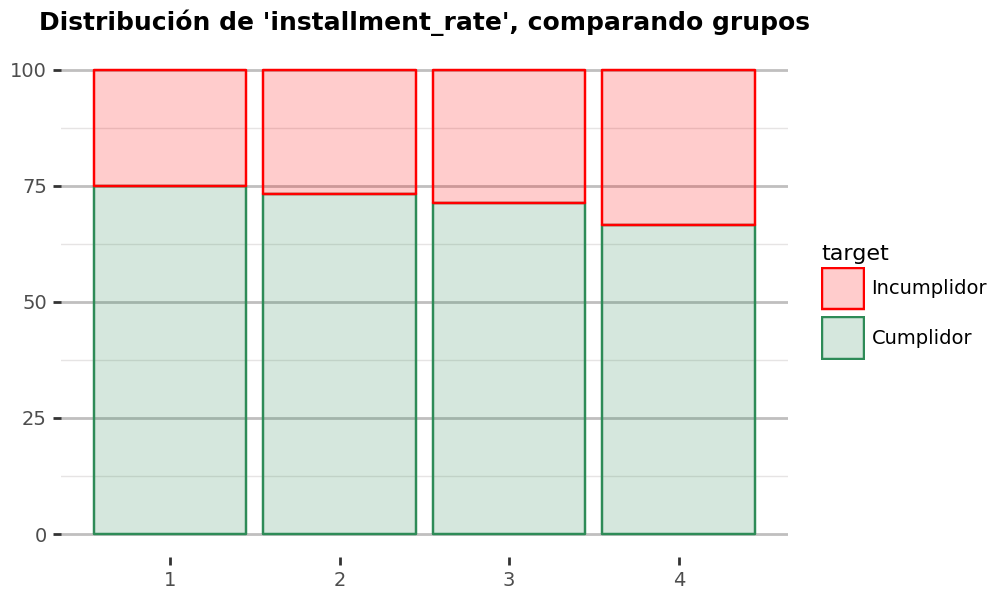

In [196]:
col = discrete_col[14]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### time_present_residence

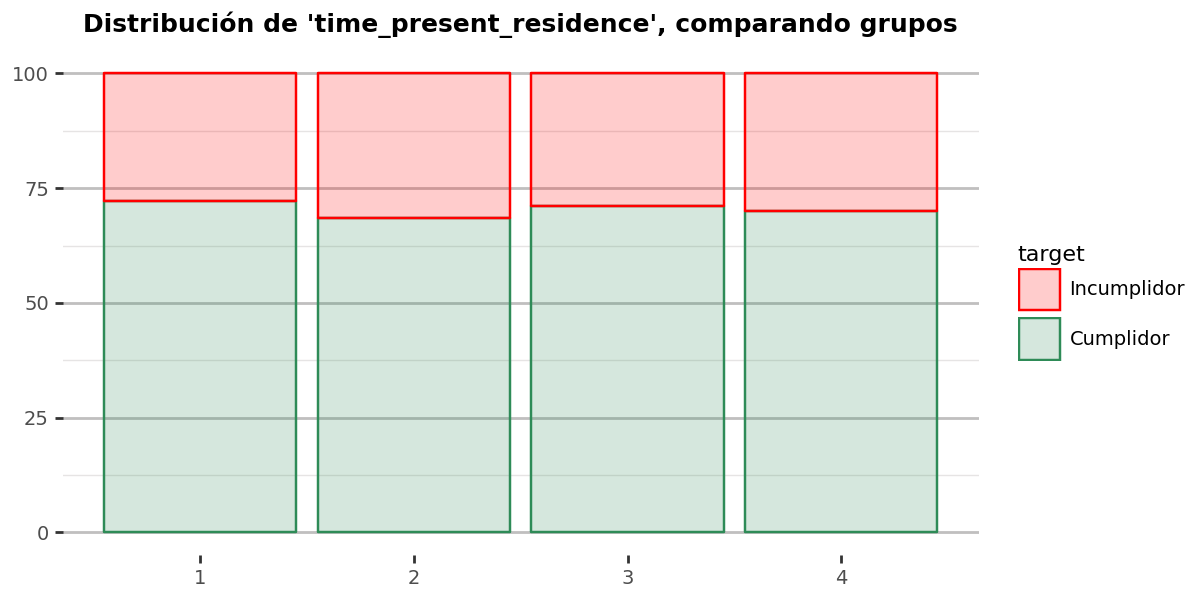

In [198]:
col = discrete_col[15]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(6,3))
cat_variables_per_group.show()

### number_credits

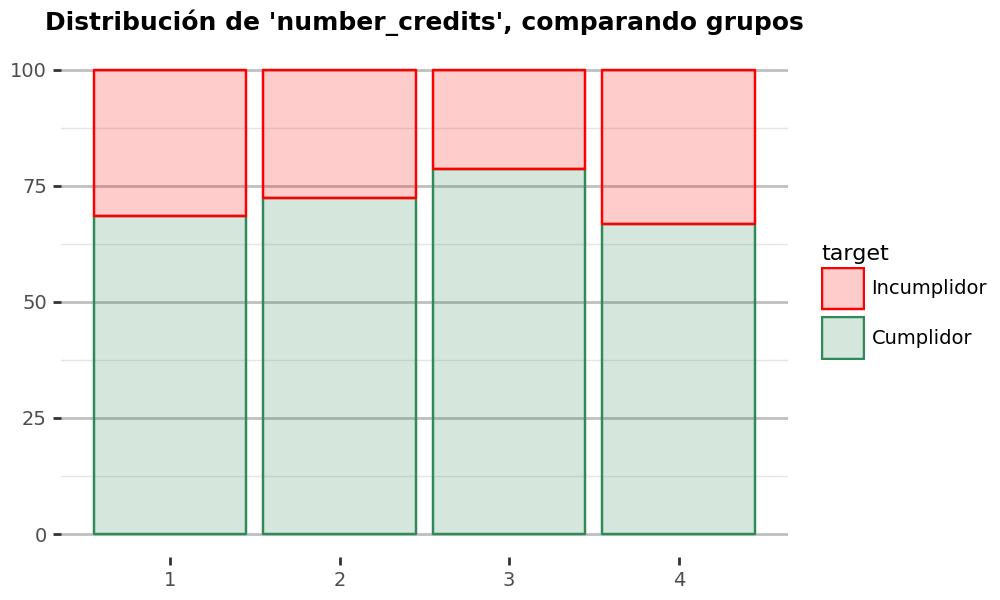

In [199]:
col = discrete_col[16]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(5,3))
cat_variables_per_group.show()

### number_of_dependants

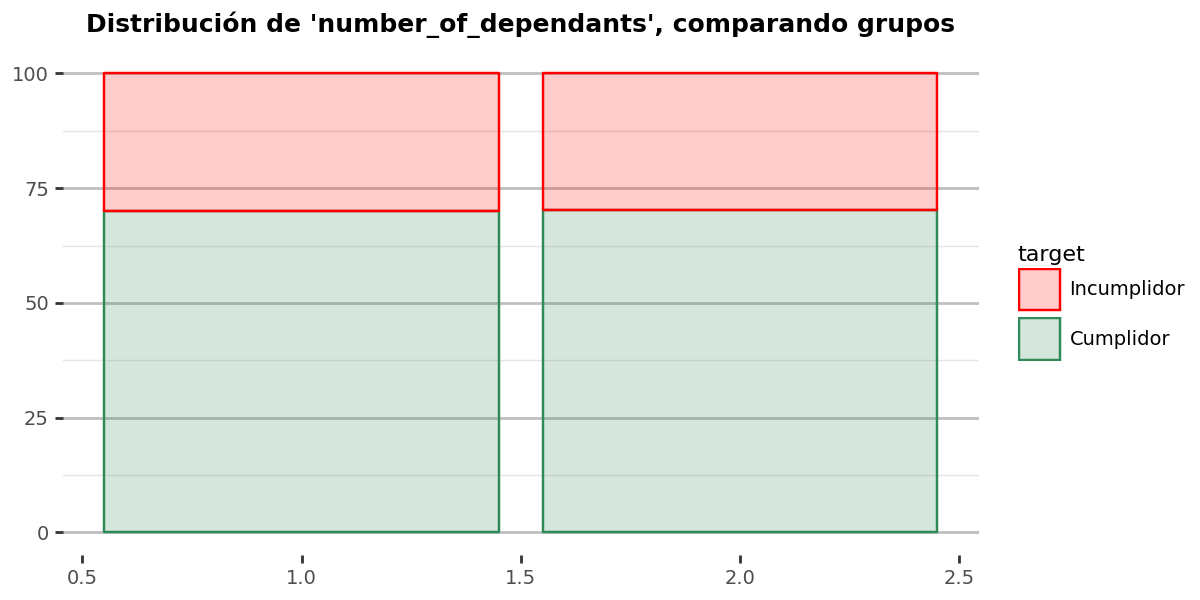

In [201]:
col = discrete_col[17]
cat_variables_per_group = ut.cat_variables_per_group(data,col,'target',colors_per_group,(6,3))
cat_variables_per_group.show()

# Tratamiento de datos

Para las variables categóricas que tienen nan, se completa con MISSING

In [202]:
for col in discrete_col:
    data[col] = data[col].fillna('MISSING')

Transformamos la variable target en 0 y 1.

In [203]:
data['target'] = data['target'].map({'1':0,'2':1})

# Selección de variables

Fijamos la semilla para asegurar la reproducibilidad de los resultados.

In [204]:
seed = 42

Separación en train-test.

In [205]:
df_train, df_test = train_test_split(data, test_size=0.3, random_state=seed, stratify=data['target'])

Revisamos el balance de la variable objetivo en train

In [206]:
df_train['target'].value_counts(normalize = True)

target
0    0.7
1    0.3
Name: proportion, dtype: float64

### Discretización

Generamos una copia sobre la cual trabajaremos

In [207]:
data[cuantitative_col].describe()

duration  credit_amount          age
count  1000.000000    1000.000000  1000.000000
mean     20.903000    3271.258000    35.546000
std      12.058814    2822.736876    11.375469
min       4.000000     250.000000    19.000000
25%      12.000000    1365.500000    27.000000
50%      18.000000    2319.500000    33.000000
75%      24.000000    3972.250000    42.000000
max      72.000000   18424.000000    75.000000

In [231]:
data_train = df_train.copy()

### Variables Categóricas, exceptuando el target

In [232]:
categorical_cols = [col for col in discrete_col if col!='target']

### Análisis de WOE e IV, variables categóricas

### status_account

In [233]:
var = categorical_cols[0]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
(-inf, 0)   0.204082  0.438095 -0.763916  0.178767   27.99
[0, 200)    0.232653  0.352381 -0.415165  0.049707    7.78
[200, inf)  0.065306  0.057143  0.133531  0.001090    0.17
No account  0.497959  0.152381  1.184134  0.409211   64.06
Total       1.000000  1.000000       NaN  0.638775  100.00

### credit_history

In [234]:
var = categorical_cols[1]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Very bad   0.024490  0.076190 -1.134980  0.058679   23.07
Bad        0.034694  0.100000 -1.058607  0.069134   27.18
Good       0.091837  0.104762 -0.131678  0.001702    0.67
Average    0.504082  0.547619 -0.082842  0.003607    1.42
Very good  0.344898  0.171429  0.699082  0.121269   47.67
Total      1.000000  1.000000       NaN  0.254391  100.00

### purpose

In [235]:
var = categorical_cols[2]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Education            0.034694  0.085714 -0.904456  0.046146   34.89
Repairs              0.020408  0.028571 -0.336472  0.002747    2.08
Business             0.091837  0.114286 -0.218689  0.004909    3.71
New car              0.230612  0.276190 -0.180353  0.008220    6.22
Others               0.008163  0.009524 -0.154151  0.000210    0.16
Furniture            0.173469  0.195238 -0.118219  0.002573    1.95
Domestic appliances  0.014286  0.014286  0.000000  0.000000    0.00
Radio/TV             0.293878  0.200000  0.384846  0.036128   27.32
Retraining           0.008163  0.004762  0.538997  0.001833    1.39
Used car             0.124490  0.071429  0.555526  0.029477   22.29
Total                1.000000  1.000000       NaN  0.132244  100.00

### savings_account

In [236]:
var = categorical_cols[3]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
(-inf, 100)  0.538776  0.728571 -0.301787  0.057278   24.53
[100, 500)   0.112245  0.123810 -0.098061  0.001134    0.49
[500, 1000)  0.069388  0.033333  0.733153  0.026433   11.32
No account   0.214286  0.090476  0.862224  0.106751   45.72
[1000, inf)  0.065306  0.023810  1.009000  0.041870   17.93
Total        1.000000  1.000000       NaN  0.233467  100.00

### employee_time

In [237]:
var = categorical_cols[4]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Unemployed  0.040816  0.080952 -0.684779  0.027484   19.59
(-inf, 1)   0.138776  0.247619 -0.579034  0.063024   44.93
[1, 4)      0.359184  0.333333  0.074691  0.001931    1.38
[7, inf)    0.277551  0.228571  0.194156  0.009510    6.78
[4, 7)      0.183673  0.109524  0.517018  0.038337   27.33
Total       1.000000  1.000000       NaN  0.140286  100.00

### personal_status

In [238]:
var = categorical_cols[5]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Male_Divorced    0.048980  0.066667 -0.308301  0.005453   13.91
Female_Divorced  0.275510  0.352381 -0.246088  0.018917   48.26
Male_Married     0.097959  0.090476  0.079464  0.000595    1.52
Male_Single      0.577551  0.490476  0.163420  0.014230   36.31
Total            1.000000  1.000000       NaN  0.039194  100.00

### other_guarantors

In [239]:
var = categorical_cols[6]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Co-applicant  0.034694  0.061905 -0.579034  0.015756   58.94
MISSING       0.910204  0.904762  0.005997  0.000033    0.12
Guarantor     0.055102  0.033333  0.502629  0.010942   40.93
Total         1.000000  1.000000       NaN  0.026730  100.00

### property

In [240]:
var = categorical_cols[7]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
No property        0.122449  0.242857 -0.684779  0.082453   58.81
Car or other       0.326531  0.338095 -0.034804  0.000402    0.29
Savings agreement  0.230612  0.219048  0.051449  0.000595    0.42
Real estate        0.320408  0.200000  0.471278  0.056746   40.48
Total              1.000000  1.000000       NaN  0.140196  100.00

### other_installment_plans

In [241]:
var = categorical_cols[8]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Bank     0.106122  0.223810 -0.746202  0.087818   75.12
Stores   0.048980  0.066667 -0.308301  0.005453    4.66
MISSING  0.844898  0.709524  0.174622  0.023639   20.22
Total    1.000000  1.000000       NaN  0.116911  100.00

### housing

In [242]:
var = categorical_cols[9]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
For free  0.089796  0.147619 -0.497095  0.028744   28.17
Rent      0.148980  0.238095 -0.468861  0.041783   40.95
Own       0.761224  0.614286  0.214468  0.031514   30.88
Total     1.000000  1.000000       NaN  0.102040  100.00

### job

In [243]:
var = categorical_cols[10]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Unemployed  0.012245  0.028571 -0.847298  0.013833   60.71
Management  0.132653  0.161905 -0.199271  0.005829   25.58
Skilled     0.648980  0.623810  0.039556  0.000996    4.37
Unskilled   0.206122  0.185714  0.104261  0.002128    9.34
Total       1.000000  1.000000       NaN  0.022786  100.00

### telephone

In [244]:
var = categorical_cols[11]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
No     0.587755  0.614286 -0.044150  0.001171   39.89
Yes    0.412245  0.385714  0.066521  0.001765   60.11
Total  1.000000  1.000000       NaN  0.002936  100.00

### foreign_worker

In [245]:
var = categorical_cols[12]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
Yes    0.946939  0.990476 -0.044951  0.001957    2.55
No     0.053061  0.009524  1.717651  0.074782   97.45
Total  1.000000  1.000000       NaN  0.076739  100.00

### installment_rate

In [246]:
var = categorical_cols[13]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
4      0.438776  0.509524 -0.149489  0.010576   31.32
3      0.155102  0.171429 -0.100083  0.001634    4.84
2      0.253061  0.204762  0.211784  0.010229   30.29
1      0.153061  0.114286  0.292136  0.011328   33.55
Total  1.000000  1.000000       NaN  0.033767  100.00

### time_present_residence

In [247]:
var = categorical_cols[14]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
1      0.128571  0.138095 -0.071459  0.000681   37.12
3      0.157143  0.166667 -0.058841  0.000560   30.57
2      0.314286  0.309524  0.015267  0.000073    3.97
4      0.400000  0.385714  0.036368  0.000520   28.34
Total  1.000000  1.000000       NaN  0.001833  100.00

### number_credits

In [248]:
var = categorical_cols[15]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
4      0.004082  0.004762 -0.154151  0.000105    3.01
3      0.020408  0.023810 -0.154151  0.000524   15.04
1      0.620408  0.642857 -0.035545  0.000798   22.88
2      0.355102  0.328571  0.077651  0.002060   59.08
Total  1.000000  1.000000       NaN  0.003487  100.00

### number_of_dependants

In [249]:
var = categorical_cols[16]
tabla = pd.crosstab(data_train[var], data_train['target'], normalize='columns')
tabla['WoE'] = np.log(tabla[0] / tabla[1])
tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
tabla['IV_%'] = (tabla['IV']*100/tabla['IV'].sum()).round(2)
tabla = tabla.sort_values('WoE',ascending = True)
totals = {
    0: tabla[0].sum(),
    1: tabla[1].sum(),
    'WoE': np.nan,  # WOE for total is not meaningful
    'IV': tabla['IV'].sum(),
    'IV_%': 100.0   # Total IV% = 100%
}

tabla = pd.concat([tabla, pd.DataFrame(totals, index=['Total'])])
tabla

0         1       WoE        IV    IV_%
2      0.157143  0.161905 -0.029853  0.000142   84.05
1      0.842857  0.838095  0.005666  0.000027   15.95
Total  1.000000  1.000000       NaN  0.000169  100.00

Juntamos la información del **Information Value** para las variables discretas, en una sola tabla.

In [250]:
inf_values_disc = {}
for col in categorical_cols:
    tabla = pd.crosstab(data_train[col], data_train['target'], normalize='columns')
    tabla['WoE'] = np.log(tabla[0] / tabla[1])
    tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
    inf_values_disc[col]=tabla['IV'].sum()

inf_values_disc = pd.DataFrame([inf_values_disc]).T.reset_index()
inf_values_disc.columns=['variable','IV']
inf_values_disc = inf_values_disc.sort_values('IV', ascending=False).reset_index(drop=True)
inf_values_disc

variable        IV
0            status_account  0.638775
1            credit_history  0.254391
2           savings_account  0.233467
3             employee_time  0.140286
4                  property  0.140196
5                   purpose  0.132244
6   other_installment_plans  0.116911
7                   housing  0.102040
8            foreign_worker  0.076739
9           personal_status  0.039194
10         installment_rate  0.033767
11         other_guarantors  0.026730
12                      job  0.022786
13           number_credits  0.003487
14                telephone  0.002936
15   time_present_residence  0.001833
16     number_of_dependants  0.000169

Guardamos el mapeo del **WOE** para las variables discretas, en una solo diccionario

In [251]:
woe_maps_disc = {}
for col in categorical_cols:
    tabla = pd.crosstab(data_train[col], data_train['target'], normalize='columns')
    tabla['WoE'] = np.log(tabla[0] / tabla[1])
    tabla = tabla.reset_index()
    woe_maps_disc[col] = dict(zip(tabla[col],tabla['WoE']))

woe_maps_disc

{'status_account': {'(-inf, 0)': -0.7639162514481526,
  'No account': 1.1841344621062715,
  '[0, 200)': -0.41516450519687803,
  '[200, inf)': 0.13353139262452277},
 'credit_history': {'Average': -0.0828416521224765,
  'Bad': -1.0586069540544105,
  'Good': -0.1316778239751997,
  'Very bad': -1.1349799328389847,
  'Very good': 0.6990819160797599},
 'purpose': {'Business': -0.21868920096482944,
  'Domestic appliances': 0.0,
  'Education': -0.9044562742271522,
  'Furniture': -0.11821867060119493,
  'New car': -0.18035305222128248,
  'Others': -0.15415067982725836,
  'Radio/TV': 0.38484582090542874,
  'Repairs': -0.3364722366212129,
  'Retraining': 0.5389965007326869,
  'Used car': 0.5555258026838976},
 'savings_account': {'(-inf, 100)': -0.30178667863332287,
  'No account': 0.8622235106038793,
  '[100, 500)': -0.09806121317621475,
  '[1000, inf)': 1.0090001299784228,
  '[500, 1000)': 0.7331525151736445},
 'employee_time': {'(-inf, 1)': -0.5790338737925242,
  'Unemployed': -0.68477893088942

### Análisis de WOE e IV, variables cuantitativas
Para este tipo de variables debemos, realizar primero una discretización, esto lo haremos utilizando el **Optimal Binning**

### duration

In [252]:
optbin = OptimalBinning(name='duration', dtype='numerical', max_n_prebins=5)
optbin.fit(data_train['duration'], data_train['target'])
optbin = optbin.binning_table.build()
optbin['IV_%'] = (optbin['IV']*100/optbin.loc['Totals','IV']).round(2)
optbin

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 8.50)     66   0.094286         60      6    0.090909   
1        [8.50, 16.50)    243   0.347143        185     58    0.238683   
2       [16.50, 34.50)    272   0.388571        180     92    0.338235   
3       [34.50, 47.50)     76   0.108571         45     31    0.407895   
4         [47.50, inf)     43   0.061429         20     23    0.534884   
5              Special      0   0.000000          0      0    0.000000   
6              Missing      0   0.000000          0      0    0.000000   
Totals                    700   1.000000        490    210    0.300000   

             WoE        IV        JS    IV_%  
0       1.455287  0.136619  0.015714   49.67  
1       0.312615  0.031687  0.003945   11.52  
2       -0.17613  0.012461  0.001556    4.53  
3      -0.474623  0.026476  0.003279    9.63  
4       -0.98706  0.067818  0.008149   24.66  
5            0.0  0.000000  0.000000    0.00  
6            0.0  0.000000  0.000000    0.00  
Totals            0.275060  0.032642  100.00

La variable 'duration' termina con 5 bins, se encuentra monotonía en el WoE, mayor riesgo a mayor duración en el préstamo

### credit_amount

In [253]:
optbin = OptimalBinning(name='credit_amount', dtype='numerical', max_n_prebins=5)
optbin.fit(data_train['credit_amount'], data_train['target'])
optbin = optbin.binning_table.build()
optbin['IV_%'] = (optbin['IV']*100/optbin.loc['Totals','IV']).round(2)
optbin

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 3444.00)    481   0.687143        348    133    0.276507   
1       [3444.00, 3913.50)     38   0.054286         36      2    0.052632   
2       [3913.50, 7760.50)    130   0.185714         82     48    0.369231   
3           [7760.50, inf)     51   0.072857         24     27    0.529412   
4                  Special      0   0.000000          0      0    0.000000   
5                  Missing      0   0.000000          0      0    0.000000   
Totals                        700   1.000000        490    210    0.300000   

             WoE        IV        JS    IV_%  
0       0.114555  0.008806  0.001100    3.74  
1       2.043074  0.130646  0.013976   55.51  
2       -0.31178  0.019089  0.002376    8.11  
3      -0.965081  0.076813  0.009245   32.64  
4            0.0  0.000000  0.000000    0.00  
5            0.0  0.000000  0.000000    0.00  
Totals            0.235353  0.026698  100.00

Se elaboran 4 bins, se puede hacer otra iteración a máximo 3 bins para intentar forzar monotonía

### age

In [255]:
optbin = OptimalBinning(name='age', dtype='numerical', max_n_prebins=5)
optbin.fit(data_train['age'], data_train['target'])
optbin = optbin.binning_table.build()
optbin['IV_%'] = (optbin['IV']*100/optbin.loc['Totals','IV']).round(2)
optbin

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 25.50)    124   0.177143         74     50    0.403226   
1       [25.50, 34.50)    261   0.372857        179     82    0.314176   
2       [34.50, 52.50)    254   0.362857        198     56    0.220472   
3         [52.50, inf)     61   0.087143         39     22    0.360656   
4              Special      0   0.000000          0      0    0.000000   
5              Missing      0   0.000000          0      0    0.000000   
Totals                    700   1.000000        490    210    0.300000   

             WoE        IV        JS    IV_%  
0      -0.455256  0.039641  0.004913   37.63  
1      -0.066631  0.001677  0.000210    1.59  
2       0.415617  0.057112  0.007088   54.21  
3      -0.274779  0.006916  0.000862    6.57  
4            0.0  0.000000  0.000000    0.00  
5            0.0  0.000000  0.000000    0.00  
Totals            0.105347  0.013072  100.00

Es monotonica a excepción de el ultimo tramo, probablemente sea el comportamiento natural, mientras mas joven mas riesgo y va disminuyendo hasta llegar a la adultez, pero el riesgo vuelve a aumentar pasados los 52 años, cercano al fin de la vida laboral.

Juntamos la información del **Information Value** para las variables cuantitativas, en una sola tabla.

In [256]:
inf_values_cont = {}
for col in cuantitative_col:
    optbin = OptimalBinning(name=col, dtype='numerical', max_n_prebins=5)
    optbin.fit(data_train[col], data_train['target'])
    optbin = optbin.binning_table.build()
    inf_values_cont[col] = optbin.loc['Totals','IV']

inf_values_cont = pd.DataFrame([inf_values_cont]).T.reset_index()
inf_values_cont.columns=['variable','IV']
inf_values_cont = inf_values_cont.sort_values('IV', ascending=False).reset_index(drop=True)
inf_values_cont

variable        IV
0       duration  0.275060
1  credit_amount  0.235353
2            age  0.105347

Juntamos la información sobre el **WoE** en una lista, para utilizarlo después y poder mapear todo

In [257]:
woe_maps_cont = {}
for col in cuantitative_col:
    optbin = OptimalBinning(name=col, dtype='numerical', max_n_prebins=5)
    optbin.fit(data_train[col], data_train['target'])
    optbin = optbin.binning_table.build()
    optbin = optbin.drop('Totals')
    optbin = optbin[optbin['Count']>0]
    woe_maps_cont[col] = dict(zip(optbin['Bin'],optbin['WoE']))
    
woe_maps_cont

{'duration': {'(-inf, 8.50)': 1.4552872326068422,
  '[8.50, 16.50)': 0.31261495414470186,
  '[16.50, 34.50)': -0.17612958654603372,
  '[34.50, 47.50)': -0.47462257510203015,
  '[47.50, inf)': -0.9870598027623623},
 'credit_amount': {'(-inf, 3444.00)': 0.11455549116551678,
  '[3444.00, 3913.50)': 2.043073897508961,
  '[3913.50, 7760.50)': -0.3117796240308417,
  '[7760.50, inf)': -0.9650808960435872},
 'age': {'(-inf, 25.50)': -0.45525577261118,
  '[25.50, 34.50)': -0.06663130181070176,
  '[34.50, 52.50)': 0.4156174795721823,
  '[52.50, inf)': -0.2747786676158732}}

Revisamos para cada variable discreta, si las categorías correspondientes a cada una aparece en train y test.
- Recordar que si aparece en train pero no es test, no hay problema todo esta ok.
- Si la categoría aparece en test pero no en train, es el caso más critico, se tienen dos opciones, asignar un WOE 0, o el del bin mas grande.

Revisamos y vemos si es que sera necesario arreglar este error.


In [258]:
# For categories unseen in train, bus yes in test
unseen_categories = {}
for col in categorical_cols:
    train_cats = set(df_train[col].unique())
    test_cats = set(df_test[col].unique())

    # Categories in test but not in train, most critical case
    unseen_in_train = test_cats - train_cats
    if unseen_in_train:
        unseen_categories[col]=unseen_in_train
        print(f'{col}: categorias presentes en test pero no en train ->{unseen_in_train}')
    else:
        print(f'{col}: Todas las categorias en test existen en train :)')        

status_account: Todas las categorias en test existen en train :)
credit_history: Todas las categorias en test existen en train :)
purpose: Todas las categorias en test existen en train :)
savings_account: Todas las categorias en test existen en train :)
employee_time: Todas las categorias en test existen en train :)
personal_status: Todas las categorias en test existen en train :)
other_guarantors: Todas las categorias en test existen en train :)
property: Todas las categorias en test existen en train :)
other_installment_plans: Todas las categorias en test existen en train :)
housing: Todas las categorias en test existen en train :)
job: Todas las categorias en test existen en train :)
telephone: Todas las categorias en test existen en train :)
foreign_worker: Todas las categorias en test existen en train :)
installment_rate: Todas las categorias en test existen en train :)
time_present_residence: Todas las categorias en test existen en train :)
number_credits: Todas las categorias en

Afortunadamente no hay categorías presentes en test ausentes en test

### Mapeo de WoE

Creamos dos datasets, 'train_woe', 'test_woe', en los cuales los cuales tendrán las transformaciones en base al WOE calculado para cada variable previamente.

In [259]:
# Función para mapear los woe de las variables categóricas
def map_woe_disc(categorical_cols,woe_maps_disc, df):
    df_woe = df.copy()
    for col in categorical_cols:
        # mapeamos
        df_woe[col] = df_woe[col].map(woe_maps_disc[col])
        # renombramos la columna
        df_woe = df_woe.rename(columns={col:f'{col}_woe'})

    return df_woe

In [260]:
# Función para mapear las variables continuas
def map_woe_cont(cuantitative_col,woe_maps_cont, df):
    df_woe = df.copy()
    for col in cuantitative_col:
        # Instanciamos el parsed bins para esa variables
        parsed_bins = we.build_continuous_woe_map(woe_maps_cont[col])
        # mapeamos
        df_woe[col] = df_woe[col].apply(lambda x: we.map_continuous_woe(x,parsed_bins))
        # renombramos
        df_woe = df_woe.rename(columns={col:f'{col}_woe'})
    return df_woe


Mapeamos variables continuas y discretas en base a los WoE calculados, para ambos dataset, **df_train, df_test**, se utiliza el mismo mapping para ambas particiones.

In [261]:
# Creamos la copia para df_train
df_train_woe = df_train.copy()
# Mapeamos aquellas variables discretas para df_train
df_train_woe = map_woe_disc(categorical_cols,woe_maps_disc, df_train_woe)
# Mapeamos variables cuantitativas para df_train
df_train_woe = map_woe_cont(cuantitative_col,woe_maps_cont, df_train_woe)

# Creamos la copia para df_test
df_test_woe = df_test.copy()
# Mapeamos aquellas variables discretas para df_test
df_test_woe = map_woe_disc(categorical_cols,woe_maps_disc, df_test_woe)
# Mapeamos variables cuantitativas para df_test
df_test_woe = map_woe_cont(cuantitative_col,woe_maps_cont, df_test_woe)

### Juntamos ambas tablas con el IV de todas las variables en una sola tabla y pasamos a la selección de variables.

In [262]:
inf_values_cont['var_type'] = 'cuantitative'
inf_values_disc['var_type'] = 'discrete'

inf_values = pd.concat([inf_values_cont,inf_values_disc], ignore_index=True)
inf_values = inf_values.sort_values('IV',ascending = False).reset_index(drop=True)
inf_values

variable        IV      var_type
0            status_account  0.638775      discrete
1                  duration  0.275060  cuantitative
2            credit_history  0.254391      discrete
3             credit_amount  0.235353  cuantitative
4           savings_account  0.233467      discrete
5             employee_time  0.140286      discrete
6                  property  0.140196      discrete
7                   purpose  0.132244      discrete
8   other_installment_plans  0.116911      discrete
9                       age  0.105347  cuantitative
10                  housing  0.102040      discrete
11           foreign_worker  0.076739      discrete
12          personal_status  0.039194      discrete
13         installment_rate  0.033767      discrete
14         other_guarantors  0.026730      discrete
15                      job  0.022786      discrete
16           number_credits  0.003487      discrete
17                telephone  0.002936      discrete
18   time_present_residence  0.001833      discrete
19     number_of_dependants  0.000169      discrete

## Selección de variables

Revisamos aquellas que tengan un IV mayor a 0.02, punto de corte arbitrario

In [275]:
inf_values = inf_values[inf_values['IV']>0.02]
inf_values

variable        IV      var_type
0            status_account  0.638775      discrete
1                  duration  0.275060  cuantitative
2            credit_history  0.254391      discrete
3             credit_amount  0.235353  cuantitative
4           savings_account  0.233467      discrete
5             employee_time  0.140286      discrete
6                  property  0.140196      discrete
7                   purpose  0.132244      discrete
8   other_installment_plans  0.116911      discrete
9                       age  0.105347  cuantitative
10                  housing  0.102040      discrete
11           foreign_worker  0.076739      discrete
12          personal_status  0.039194      discrete
13         installment_rate  0.033767      discrete
14         other_guarantors  0.026730      discrete
15                      job  0.022786      discrete

Revisamos el coeficiente de correlación de spearman, y revisamos si existen casos donde el valor absoluto sea mayor a 0.7 

In [276]:
corr_matrix = df_train_woe.corr(method='spearman')
# mask para quedarse solo con un triangulo de la matriz, tambien dejamos de lado la diagonal
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# filtramos y cambiamos el formato
corr_matrix = corr_matrix.where(mask).stack().reset_index()
corr_matrix.columns = ['var1', 'var2', 'value']

# Creamos una columna con el valor del valor absoluto
corr_matrix['abs_value'] = np.abs(corr_matrix['value'])

# Revisamos los valores
corr_matrix[['value','abs_value']].describe()


value   abs_value
count  210.000000  210.000000
mean     0.010682    0.081921
std      0.113290    0.078779
min     -0.350674    0.000428
25%     -0.036337    0.024964
50%      0.011250    0.057395
75%      0.075822    0.114786
max      0.457878    0.457878

En nuestro caso no existen correlaciones de Spearman con valor absoluto mayor a 0.7

Revisaremos el coeficiente de correlación de Pearson, para ver si hay linealidad

In [277]:
corr_matrix = df_train_woe.corr(method='pearson')
# mask para quedarse solo con un triangulo de la matriz, tambien dejamos de lado la diagonal
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# filtramos y cambiamos el formato
corr_matrix = corr_matrix.where(mask).stack().reset_index()
corr_matrix.columns = ['var1', 'var2', 'value']

# Creamos una columna con el valor del valor absoluto
corr_matrix['abs_value'] = np.abs(corr_matrix['value'])

# Revisamos los valores
corr_matrix[['value','abs_value']].describe()

value   abs_value
count  210.000000  210.000000
mean     0.014861    0.077015
std      0.102960    0.069735
min     -0.341082    0.000480
25%     -0.036956    0.024438
50%      0.014961    0.057175
75%      0.074094    0.101533
max      0.406836    0.406836

No se encuentran, correlaciones de Pearson que indiquen linealidad

Guardamos las variables que ingresaran al modelo, el criterio a utilizar sera backward selector.

In [278]:
final_var = [var+'_woe' for var in inf_values['variable'].tolist()]
final_var

['status_account_woe',
 'duration_woe',
 'credit_history_woe',
 'credit_amount_woe',
 'savings_account_woe',
 'employee_time_woe',
 'property_woe',
 'purpose_woe',
 'other_installment_plans_woe',
 'age_woe',
 'housing_woe',
 'foreign_worker_woe',
 'personal_status_woe',
 'installment_rate_woe',
 'other_guarantors_woe',
 'job_woe']

## Modelización

Utilizando las particiones, entrenaremos y validaremos el modelo

In [279]:
# Creamos las particiones X,y para train y test
X_train, y_train = df_train_woe[final_var], df_train_woe['target']
X_test, y_test = df_test_woe[final_var], df_test_woe['target']

# Reseteamos indices para que no hayan problemas
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

Entrenamiento del modelo mediante backward selector.

In [280]:
model = LogisticRegression(class_weight='balanced', random_state=seed)
results_val, results_test = fsf.backward_selector(X_train, y_train, X_test, y_test, model, '', cv_folds=5, seed=seed)

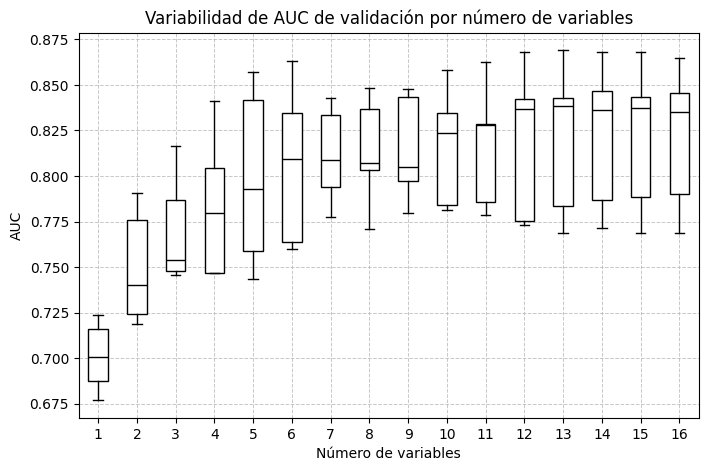

In [281]:
fsf.plot_results_val(results_val)

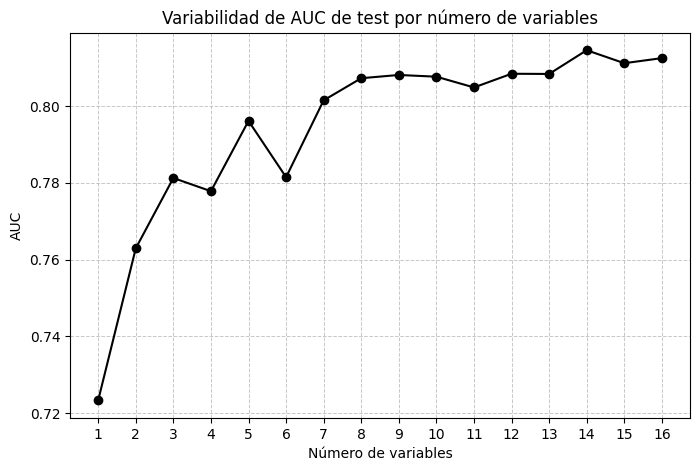

In [282]:
fsf.plot_results_test(results_test)

Elegiremos el modelo cuando tiene 7 variables

In [283]:
n_vars = 7
results_test[n_vars]['model_summary']

Variable  Coeficiente   std_err   z_value       p_value  \
0           status_account_woe    -0.933092  0.111857 -8.341813  0.000000e+00   
1                 duration_woe    -0.903332  0.181603 -4.974217  6.551203e-07   
2           credit_history_woe    -0.688452  0.196048 -3.511653  4.453294e-04   
3            credit_amount_woe    -0.796808  0.190919 -4.173537  2.999072e-05   
4            employee_time_woe    -0.892149  0.250994 -3.554459  3.787574e-04   
5                  purpose_woe    -1.061017  0.255759 -4.148510  3.346462e-05   
6  other_installment_plans_woe    -0.786315  0.281464 -2.793662  5.211499e-03   
7                   intercepto    -0.002991  0.092033 -0.032504  9.740702e-01   

        VIF  
0  1.063659  
1  1.065301  
2  1.115045  
3  1.053622  
4  1.044641  
5  1.022730  
6  1.070448  
7  1.056944

AUC del modelo

In [284]:
results_test[n_vars]['auc']

0.8015343915343915

### Sentido del negocio de las variables

In [285]:
def map_woe_cont_plot(cuantitative_col,woe_maps_cont, df):
    df_woe = df.copy()
    for col in cuantitative_col:
        # Instanciamos el parsed bins para esa variables
        parsed_bins = we.build_continuous_woe_map(woe_maps_cont[col])
        # mapeamos
        df_woe[col] = df_woe[col].apply(lambda x: we.map_continuous_woe(x,parsed_bins))
        # renombramos
        df_woe = df_woe.rename(columns={col:f'{col}'})
    return df_woe

woe_maps_cont_plot = {}
for col in cuantitative_col:
    optbin = OptimalBinning(name=col, dtype='numerical', max_n_prebins=5)
    optbin.fit(data_train[col], data_train['target'])
    optbin = optbin.binning_table.build()
    optbin = optbin.drop('Totals')
    optbin = optbin[optbin['Count']>0]
    woe_maps_cont_plot[col] = dict(zip(optbin['Bin'],optbin['Bin']))

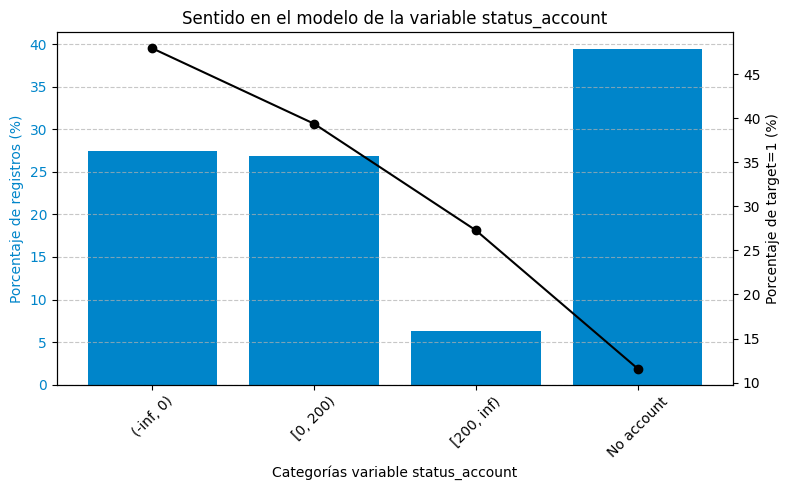

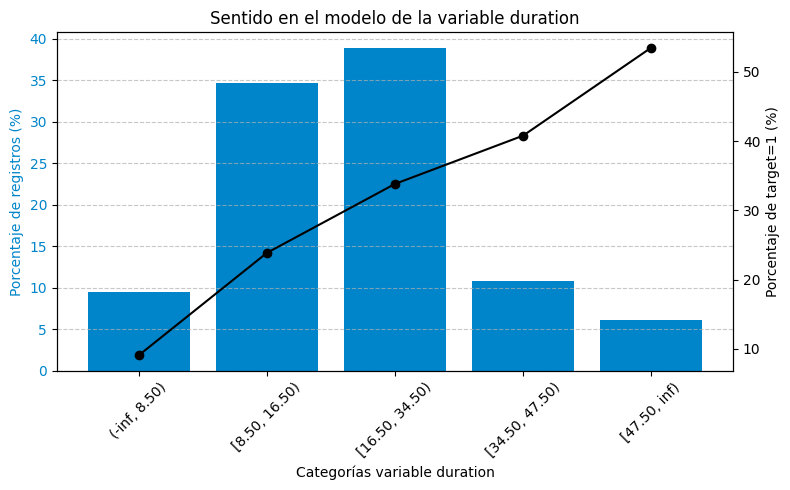

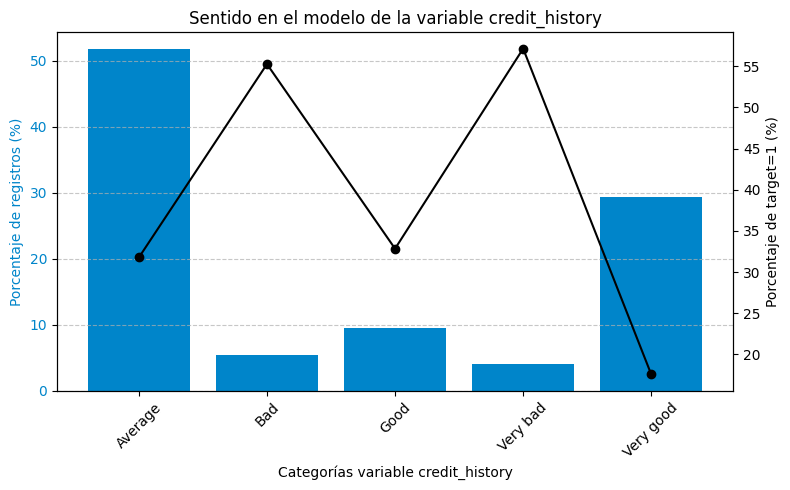

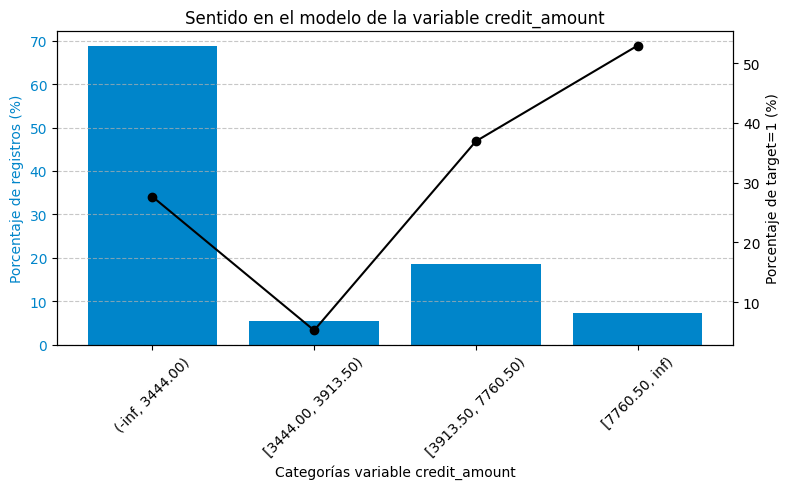

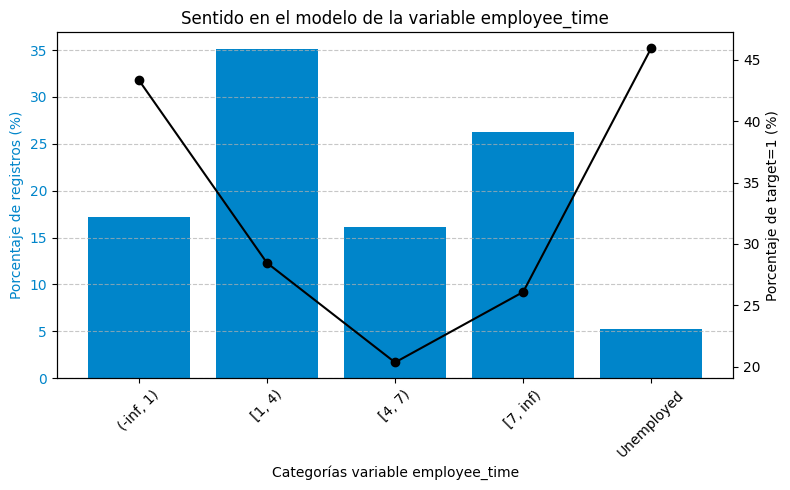

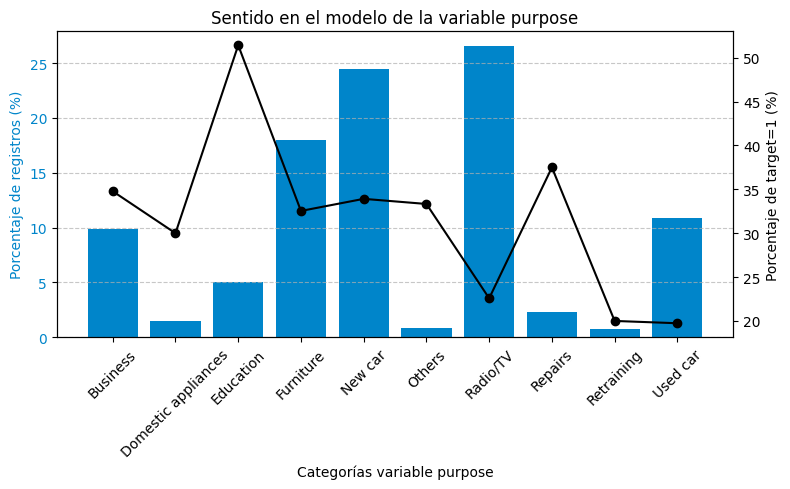

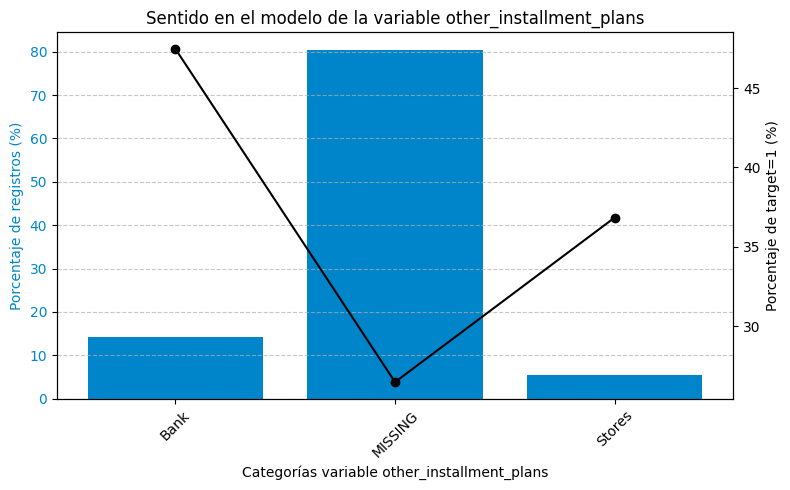

In [286]:
df_train_plot = df_train.copy()
df_train_plot = map_woe_cont_plot(cuantitative_col,woe_maps_cont_plot, df_train_plot)

for var in results_test[n_vars]['features']:
    var = var.replace('_woe','')
    fsf.plot_business_sense(df_train_plot, var, 'target')

### Mejoras en el modelo

Con el objetivo de mejorar el modelo y las monotonías, debemos realizar modificaciones.
- **credit_history**: Utilizando optimal binning, número máximo de bins = 3
- **purpose**: Utilizando optimal binning, número máximo de bins = 5
- **employee_time**: Forzar la union de las categorías [4,7) y [7,inf)
- **credit_amount**: Utilizando optimal binning, número máximo de bins = 3

In [287]:
# Generamos una copia de df_train para no afectar lo previo
df_train_v2 = df_train.copy()
df_test_v2 = df_test.copy()

### credit_amount

In [288]:
# Forzamos 'credit_amount' a 3 bins
col = 'credit_amount'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_prebins=3)
optbin.fit(df_train_v2[col], df_train_v2['target'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 3444.00)    481   0.687143        348    133    0.276507   
1       [3444.00, 3913.50)     38   0.054286         36      2    0.052632   
2           [3913.50, inf)    181   0.258571        106     75    0.414365   
3                  Special      0   0.000000          0      0    0.000000   
4                  Missing      0   0.000000          0      0    0.000000   
Totals                        700   1.000000        490    210    0.300000   

             WoE        IV        JS    IV_%  
0       0.114555  0.008806  0.001100    4.19  
1       2.043074  0.130646  0.013976   62.20  
2      -0.501347  0.070598  0.008733   33.61  
3            0.0  0.000000  0.000000    0.00  
4            0.0  0.000000  0.000000    0.00  
Totals            0.210049  0.023810  100.00

In [289]:
# Asignamos
df_train_v2['credit_amount'] = optbin.transform(df_train_v2['credit_amount'], metric='bins')
df_test_v2['credit_amount'] = optbin.transform(df_test_v2['credit_amount'], metric='bins')

### credit history

In [290]:
## Forzamos 'credit_history' a 3 bins
col = 'credit_history'
optbin = OptimalBinning(name=col, dtype='categorical', max_n_prebins=3)
optbin.fit(df_train_v2[col], df_train_v2['target'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df


Bin  Count  Count (%)  Non-event  Event  Event rate  \
0           [Very good]    205   0.292857        169     36    0.175610   
1       [Average, Good]    429   0.612857        292    137    0.319347   
2       [Bad, Very bad]     66   0.094286         29     37    0.560606   
3               Special      0   0.000000          0      0    0.000000   
4               Missing      0   0.000000          0      0    0.000000   
Totals                     700   1.000000        490    210    0.300000   

             WoE        IV        JS    IV_%  
0       0.699082  0.121269  0.014857   47.74  
1      -0.090525  0.005111  0.000639    2.01  
2       -1.09092  0.127645  0.015209   50.25  
3            0.0  0.000000  0.000000    0.00  
4            0.0  0.000000  0.000000    0.00  
Totals            0.254026  0.030705  100.00

In [291]:
# Asignamos
df_train_v2['credit_history'] = optbin.transform(df_train_v2['credit_history'], metric='bins')
df_test_v2['credit_history'] = optbin.transform(df_test_v2['credit_history'], metric='bins')

### purpose

In [292]:
## Forzamos 'purpose' a 5 bins
col = 'purpose'
optbin = OptimalBinning(name=col, dtype='categorical', max_n_prebins=5)
optbin.fit(df_train_v2[col], df_train_v2['target'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df


Bin  Count  Count (%)  Non-event  \
0                         [Used car, Retraining]     81   0.115714         65   
1                                     [Radio/TV]    186   0.265714        144   
2       [Domestic appliances, Furniture, Others]    142   0.202857         96   
3                   [New car, Business, Repairs]    256   0.365714        168   
4                                    [Education]     35   0.050000         17   
5                                        Special      0   0.000000          0   
6                                        Missing      0   0.000000          0   
Totals                                              700   1.000000        490   

        Event  Event rate       WoE        IV        JS    IV_%  
0          16    0.197531  0.554501  0.031309  0.003864   23.82  
1          42    0.225806  0.384846  0.036128  0.004488   27.48  
2          46    0.323944 -0.111591  0.002581  0.000322    1.96  
3          88    0.343750 -0.200671  0.015289  0.001908   11.63  
4          18    0.514286 -0.904456  0.046146  0.005579   35.10  
5           0    0.000000       0.0  0.000000  0.000000    0.00  
6           0    0.000000       0.0  0.000000  0.000000    0.00  
Totals    210    0.300000            0.131453  0.016162  100.00

In [293]:
# Asignamos
df_train_v2['purpose'] = optbin.transform(df_train_v2['purpose'], metric='bins')
df_test_v2['purpose'] = optbin.transform(df_test_v2['purpose'], metric='bins')

### employee_time

In [294]:
## Forzamos 'purpose' a 5 bins
col = 'employee_time'
optbin = OptimalBinning(name=col, dtype='categorical', max_n_prebins=3)
optbin.fit(df_train_v2[col], df_train_v2['target'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df


Bin  Count  Count (%)  Non-event  Event  \
0                      [[4, 7)]    113   0.161429         90     23   
1            [[7, inf), [1, 4)]    430   0.614286        312    118   
2       [(-inf, 1), Unemployed]    157   0.224286         88     69   
3                       Special      0   0.000000          0      0   
4                       Missing      0   0.000000          0      0   
Totals                             700   1.000000        490    210   

        Event rate       WoE        IV        JS    IV_%  
0         0.203540  0.517018  0.038337  0.004739   27.84  
1         0.274419  0.125021  0.009355  0.001169    6.79  
2         0.439490 -0.604068  0.089994  0.011081   65.36  
3         0.000000       0.0  0.000000  0.000000    0.00  
4         0.000000       0.0  0.000000  0.000000    0.00  
Totals    0.300000            0.137686  0.016989  100.00

Ya que el optimal binning no nos da lo que buscamos forzamos la monotonia juntando [4,7) y [7,inf)

In [295]:
new_employee_time = {'[1, 4)':'[1, 4)',
                     '[7, inf)':'[4,7),[7,inf)',
                     '(-inf, 1)':'(-inf, 1)',
                     '[4, 7)':'[4,7),[7,inf)',
                     'Unemployed':'Unemployed',
                    }

df_train_v2['employee_time'] = df_train_v2['employee_time'].map(new_employee_time)
df_test_v2['employee_time'] = df_test_v2['employee_time'].map(new_employee_time)

Una vez realizadas las modificaciones debemos recalcular el WoE para estas columnas, recodificar y obtener un nuevo modelo

In [296]:
# Modificamos el maps en las 3 columnas categóricas existentes ['credit_history','employee_time','purpose'] y 
# agregamos el mapeado para la nueva 'credit_amount'
woe_maps_disc_v2 = woe_maps_disc

categorical_cols_v2 = ['credit_history','employee_time','purpose','credit_amount']
for col in categorical_cols_v2:
    tabla = pd.crosstab(df_train_v2[col], df_train_v2['target'], normalize='columns')
    tabla['WoE'] = np.log(tabla[0] / tabla[1])
    tabla = tabla.reset_index()
    woe_maps_disc_v2[col] = dict(zip(tabla[col],tabla['WoE']))

# Removemos 'credit_amount' del mapeo de variables continuas
woe_maps_cont_v2 = woe_maps_cont.copy()
del woe_maps_cont_v2['credit_amount']

In [297]:
categorical_cols_v2 = ['status_account',
                    'credit_history',
                    'purpose',
                    'savings_account',
                    'employee_time',
                    'personal_status',
                    'other_guarantors',
                    'property',
                    'other_installment_plans',
                    'housing',
                    'job',
                    'telephone',
                    'foreign_worker',
                    'installment_rate',
                    'time_present_residence',
                    'number_credits',
                    'number_of_dependants',
                    'credit_amount'
]

cuantitative_col_v2 = ['duration', 'age']

In [298]:
# Una vez que ya tenemos mapeado nuevamente los WoE, creamos una 2da iteración para df_train_woe
# Creamos la copia para df_train
df_train_woe_v2 = df_train_v2.copy()
# Mapeamos aquellas variables discretas para df_train
df_train_woe_v2 = map_woe_disc(categorical_cols_v2,woe_maps_disc_v2, df_train_woe_v2)
# Mapeamos variables cuantitativas para df_train
df_train_woe_v2 = map_woe_cont(cuantitative_col_v2,woe_maps_cont_v2, df_train_woe_v2)

# Creamos la copia para df_test
df_test_woe_v2 = df_test_v2.copy()
# Mapeamos aquellas variables discretas para df_test
df_test_woe_v2 = map_woe_disc(categorical_cols_v2,woe_maps_disc_v2, df_test_woe_v2)
# Mapeamos variables cuantitativas para df_test
df_test_woe_v2 = map_woe_cont(cuantitative_col_v2,woe_maps_cont_v2, df_test_woe_v2)

Analizamos nuevamente los IV

In [299]:
# Calculamos IV para categoricas
inf_values_disc_v2 = {}
for col in categorical_cols_v2:
    tabla = pd.crosstab(df_train_v2[col], df_train_v2['target'], normalize='columns')
    tabla['WoE'] = np.log(tabla[0] / tabla[1])
    tabla['IV'] = (tabla[0] - tabla[1]) * tabla['WoE']
    inf_values_disc_v2[col]=tabla['IV'].sum()

inf_values_disc_v2 = pd.DataFrame([inf_values_disc_v2]).T.reset_index()
inf_values_disc_v2.columns=['variable','IV']
inf_values_disc_v2 = inf_values_disc_v2.sort_values('IV', ascending=False).reset_index(drop=True)
# inf_values_disc_v2

# Calculamos IV para continuas
inf_values_cont_v2 = {}
for col in cuantitative_col_v2:
    optbin = OptimalBinning(name=col, dtype='numerical', max_n_prebins=5)
    optbin.fit(df_train_v2[col], df_train_v2['target'])
    optbin = optbin.binning_table.build()
    inf_values_cont_v2[col] = optbin.loc['Totals','IV']

inf_values_cont_v2 = pd.DataFrame([inf_values_cont_v2]).T.reset_index()
inf_values_cont_v2.columns=['variable','IV']
inf_values_cont_v2 = inf_values_cont_v2.sort_values('IV', ascending=False).reset_index(drop=True)
#inf_values_cont_v2

inf_values_cont_v2['var_type'] = 'cuantitative'
inf_values_disc_v2['var_type'] = 'discrete'

# Juntamos todo y mostramos
inf_values_v2 = pd.concat([inf_values_cont_v2,inf_values_disc_v2], ignore_index=True)
inf_values_v2 = inf_values_v2.sort_values('IV',ascending = False).reset_index(drop=True)

# Filtramos aquellas que tengan in IV > 0.02
inf_values_v2 = inf_values_v2[inf_values_v2['IV']>0.02]
inf_values_v2


variable        IV      var_type
0            status_account  0.638775      discrete
1                  duration  0.275060  cuantitative
2            credit_history  0.254026      discrete
3           savings_account  0.233467      discrete
4             credit_amount  0.210049      discrete
5                  property  0.140196      discrete
6                   purpose  0.131453      discrete
7             employee_time  0.130678      discrete
8   other_installment_plans  0.116911      discrete
9                       age  0.105347  cuantitative
10                  housing  0.102040      discrete
11           foreign_worker  0.076739      discrete
12          personal_status  0.039194      discrete
13         installment_rate  0.033767      discrete
14         other_guarantors  0.026730      discrete
15                      job  0.022786      discrete

Revisamos correlación de Pearson

In [300]:
corr_matrix_v2 = df_train_woe_v2.corr(method='pearson')
# mask para quedarse solo con un triangulo de la matriz, tambien dejamos de lado la diagonal
mask = np.triu(np.ones(corr_matrix_v2.shape), k=1).astype(bool)

# filtramos y cambiamos el formato
corr_matrix_v2 = corr_matrix_v2.where(mask).stack().reset_index()
corr_matrix_v2.columns = ['var1', 'var2', 'value']

# Creamos una columna con el valor del valor absoluto
corr_matrix_v2['abs_value'] = np.abs(corr_matrix_v2['value'])

# Revisamos los valores
corr_matrix_v2[['value','abs_value']].describe()

value   abs_value
count  210.000000  210.000000
mean     0.014981    0.077576
std      0.103677    0.070196
min     -0.341082    0.000480
25%     -0.032116    0.024927
50%      0.014961    0.055647
75%      0.070978    0.106229
max      0.406836    0.406836

Generamos la lista final de variables

In [302]:
final_var_v2 = [var+'_woe' for var in inf_values_v2['variable'].tolist()]
final_var_v2

['status_account_woe',
 'duration_woe',
 'credit_history_woe',
 'savings_account_woe',
 'credit_amount_woe',
 'property_woe',
 'purpose_woe',
 'employee_time_woe',
 'other_installment_plans_woe',
 'age_woe',
 'housing_woe',
 'foreign_worker_woe',
 'personal_status_woe',
 'installment_rate_woe',
 'other_guarantors_woe',
 'job_woe']

### Modelización
Hacemos nuevamente el modelo luego de haber hecho las modificaciones

In [303]:
# Creamos las particiones X,y para train y test
X_train_v2, y_train_v2 = df_train_woe_v2[final_var_v2], df_train_woe_v2['target']
X_test_v2, y_test_v2 = df_test_woe_v2[final_var_v2], df_test_woe_v2['target']

# Reseteamos indices para que no hayan problemas
X_train_v2 = X_train_v2.reset_index(drop = True)
X_test_v2= X_test_v2.reset_index(drop = True)
y_train_v2 = y_train_v2.reset_index(drop = True)
y_test_v2= y_test_v2.reset_index(drop = True)

Entrenamiento del modelo mediante backward selector.

In [304]:
model_v2 = LogisticRegression(class_weight='balanced', random_state=seed)
results_val_v2, results_test_v2 = fsf.backward_selector(X_train_v2, y_train_v2, X_test_v2, y_test_v2, model_v2, '', cv_folds=5, seed=seed)

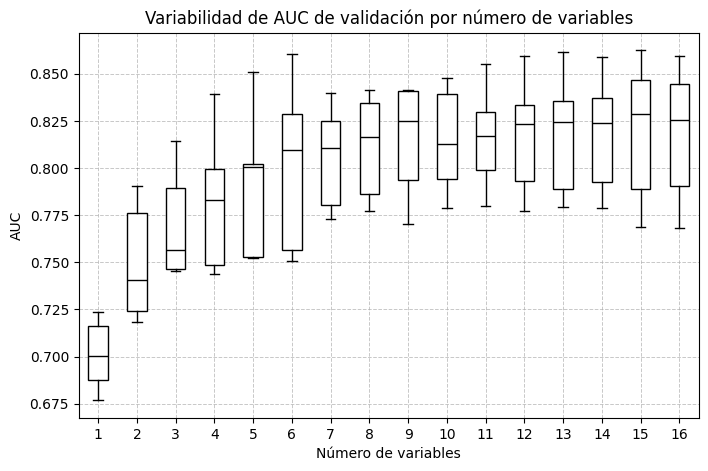

In [305]:
fsf.plot_results_val(results_val_v2)

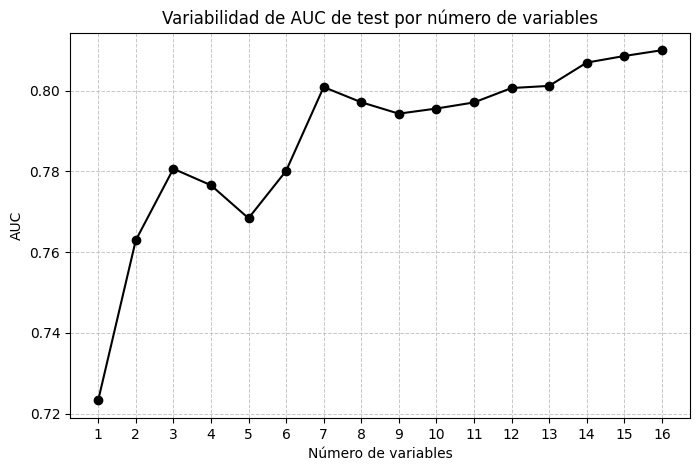

In [306]:
fsf.plot_results_test(results_test_v2)

Elegiremos el modelo cuando tiene 7 variables

In [307]:
n_vars = 7
results_test_v2[n_vars]['model_summary']

Variable  Coeficiente   std_err   z_value       p_value  \
0           status_account_woe    -0.925721  0.111393 -8.310381  0.000000e+00   
1                 duration_woe    -0.908236  0.180440 -5.033439  4.817583e-07   
2           credit_history_woe    -0.687545  0.196041 -3.507152  4.529308e-04   
3            credit_amount_woe    -0.777193  0.194402 -3.997871  6.391486e-05   
4                  purpose_woe    -1.061388  0.255857 -4.148365  3.348577e-05   
5            employee_time_woe    -0.821086  0.260254 -3.154939  1.605317e-03   
6  other_installment_plans_woe    -0.777843  0.282111 -2.757220  5.829511e-03   
7                   intercepto    -0.003374  0.091583 -0.036845  9.706085e-01   

        VIF  
0  1.066897  
1  1.058219  
2  1.120725  
3  1.047883  
4  1.025577  
5  1.054612  
6  1.075053  
7  1.057127

AUC del modelo

In [308]:
results_test_v2[n_vars]['auc']

0.800873015873016

### Sentido del negocio de las variables

In [310]:
woe_maps_cont_plot_v2 = {}
for col in cuantitative_col_v2:
    optbin = OptimalBinning(name=col, dtype='numerical', max_n_prebins=5)
    optbin.fit(df_train_v2[col], df_train_v2['target'])
    optbin = optbin.binning_table.build()
    optbin = optbin.drop('Totals')
    optbin = optbin[optbin['Count']>0]
    woe_maps_cont_plot_v2[col] = dict(zip(optbin['Bin'],optbin['Bin']))

In [ ]:
df_test_plot_v2 = df_test_v2.copy()
df_test_plot_v2 = map_woe_cont_plot(cuantitative_col_v2,woe_maps_cont_plot_v2, df_test_plot_v2)

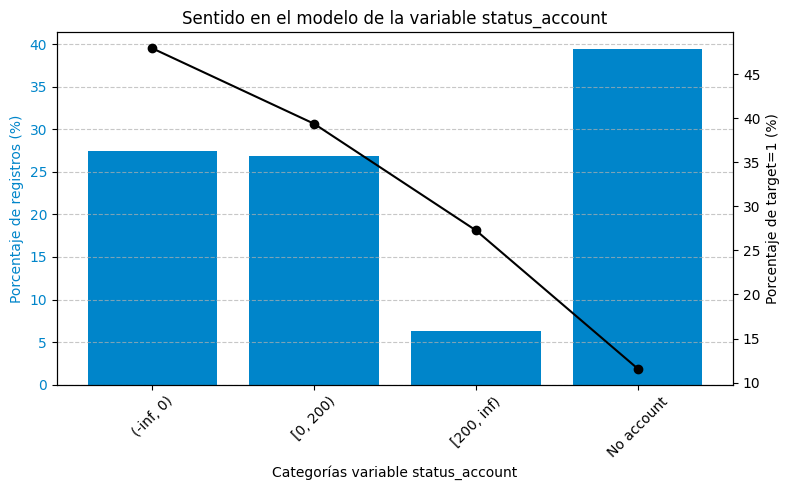

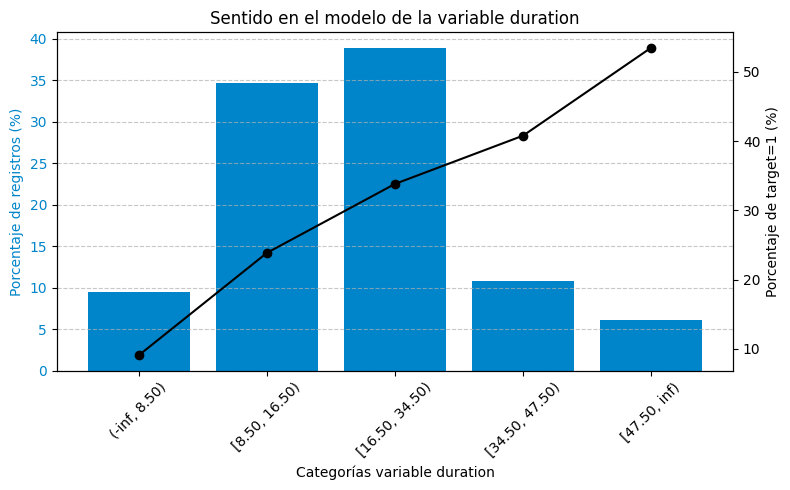

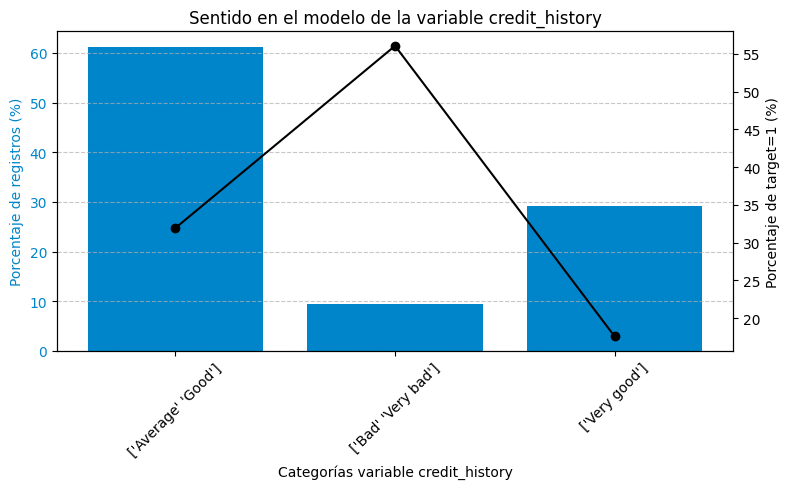

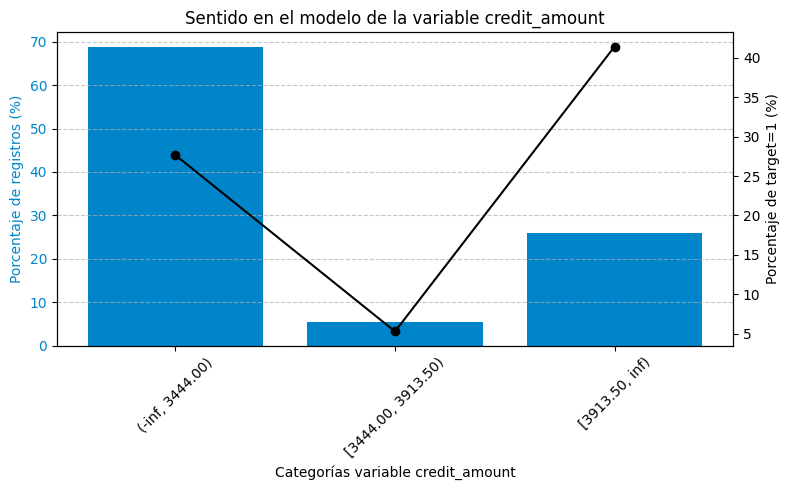

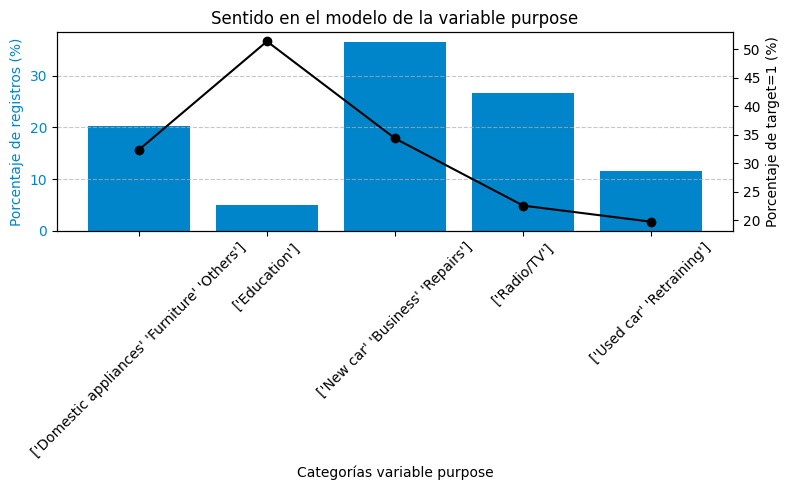

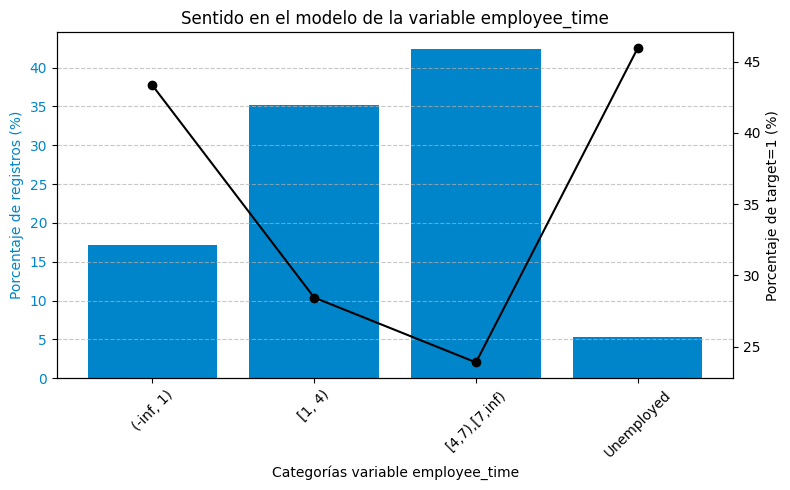

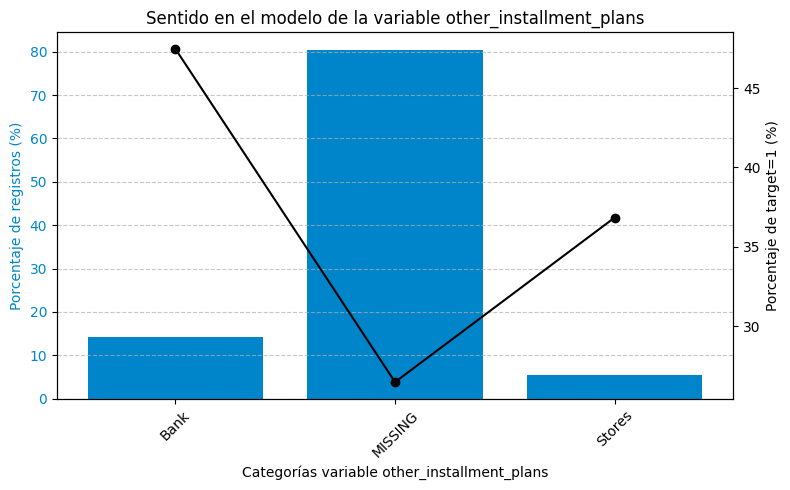

In [312]:
df_train_plot_v2 = df_train_v2.copy()
df_test_plot_v2 = df_test_v2.copy()

df_train_plot_v2 = map_woe_cont_plot(cuantitative_col_v2,woe_maps_cont_plot_v2, df_train_plot_v2)
df_test_plot_v2 = map_woe_cont_plot(cuantitative_col_v2,woe_maps_cont_plot_v2, df_test_plot_v2)

for var in results_test_v2[n_vars]['features']:
    var = var.replace('_woe','')
    fsf.plot_business_sense(df_train_plot_v2, var, 'target')

In [339]:
#df_train_plot_v3 = df_train_plot_v2.copy()
df_train_plot_v3['purpose'] = pd.Categorical(df_train_plot_v3['purpose']
                                                   ,categories=["['Education']", "['New car' 'Business' 'Repairs']",
                                                                "['Domestic appliances' 'Furniture' 'Others']",
                                                                "['Radio/TV']","['Used car' 'Retraining']"]
                                                   ,ordered=True
                                                )
#df_train_plot_v3['purpose'].unique()


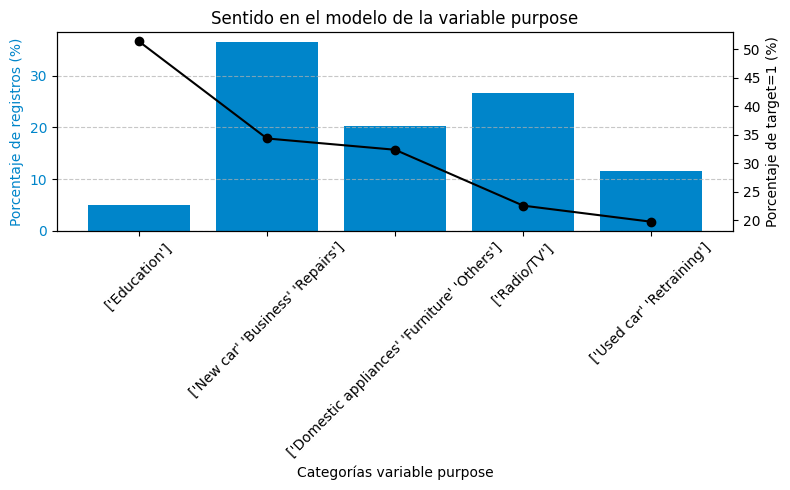

In [340]:
var = 'purpose'

fsf.plot_business_sense(df_train_plot_v3, var, 'target')

In [157]:
# Variación del AUC entre las 2 iteraciones
results_test_v2[n_vars]['auc']-results_test[n_vars]['auc']

-0.000661375661375585

Ya que la variación del AUC entre ambas iteraciones es casi nula, nos quedaremos con el 2do modelo, ya que tiene menos clases en las variables categóricas, y es mas explicativo.

In [341]:
results_test_v2[n_vars]['model_summary']

Variable  Coeficiente   std_err   z_value       p_value  \
0           status_account_woe    -0.925721  0.111393 -8.310381  0.000000e+00   
1                 duration_woe    -0.908236  0.180440 -5.033439  4.817583e-07   
2           credit_history_woe    -0.687545  0.196041 -3.507152  4.529308e-04   
3            credit_amount_woe    -0.777193  0.194402 -3.997871  6.391486e-05   
4                  purpose_woe    -1.061388  0.255857 -4.148365  3.348577e-05   
5            employee_time_woe    -0.821086  0.260254 -3.154939  1.605317e-03   
6  other_installment_plans_woe    -0.777843  0.282111 -2.757220  5.829511e-03   
7                   intercepto    -0.003374  0.091583 -0.036845  9.706085e-01   

        VIF  
0  1.066897  
1  1.058219  
2  1.120725  
3  1.047883  
4  1.025577  
5  1.054612  
6  1.075053  
7  1.057127

Construcción de score card

In [342]:
def score_parcial (woe,beta, a,n,factor,offset):
    return -(((woe*beta)+(a/n))*factor)+(offset/n)

# Establecemos las constantes
pdo = 20
odds = 16
score = 580

# Calculamos el factor
factor = pdo/np.log(2)

# Calculamos el offset
offset = score - (factor * np.log(odds))

# Instanciamos los coeficientes por los cuales tenemos que iterar
coefs = results_test_v2[n_vars]['model_summary'][['Variable','Coeficiente']].copy()
a = coefs[coefs['Variable']=='intercepto']['Coeficiente'].values[0].copy()
coefs = coefs[coefs['Variable']!='intercepto'].copy()
n=coefs.shape[0]


In [343]:
df_for_DR_PD = pd.concat([df_train_plot_v2,df_test_plot_v2],ignore_index=False)

In [344]:
score_card = []
for var in coefs['Variable'].tolist():
    score_class = {}
    beta = coefs[coefs['Variable']==var]['Coeficiente'].values[0]
    var = var.replace('_woe','')
    perc_pop_var = df_for_DR_PD[var].value_counts(normalize=True)
    
    if var in woe_maps_disc_v2:
        bins_woe = woe_maps_disc_v2[var]
    
        for bin_label,woe in bins_woe.items():
            def_rate = df_for_DR_PD[df_for_DR_PD[var]==bin_label]['target'].mean()
            def_rate = (100*def_rate).round(2)
            score_bin = score_parcial(woe,beta, a,n,factor,offset)
            score_bin = int(round(score_bin))
            perc_pop_bin = (perc_pop_var[bin_label]*100).round(2)
            
            score_class = {'predictor':var,
                          'group':bin_label,
                          'score_bin':score_bin,
                          'woe':round(woe,4),
                          'default_rate': def_rate,
                          'perc_pop':perc_pop_bin,
                          'coef':round(beta,4)
                        }
            score_card.append(score_class)
    elif var in woe_maps_cont_v2:
        bins_woe = woe_maps_cont_v2[var]
    
        for bin_label,woe in bins_woe.items():
            def_rate = df_for_DR_PD[df_for_DR_PD[var]==bin_label]['target'].mean()
            def_rate = (100*def_rate).round(2)            
            score_bin = score_parcial(woe,beta, a,n,factor,offset)
            score_bin = int(round(score_bin))
            perc_pop_bin = (perc_pop_var[bin_label]*100).round(2)
            score_class = {'predictor':var,
                          'group':bin_label,
                          'score_bin':score_bin,
                          'woe':round(woe,4),
                          'default_rate': def_rate,
                          'perc_pop':perc_pop_bin,
                          'coef':round(beta,4)
                        }
            score_card.append(score_class)

score_card = pd.DataFrame(score_card)
score_card = score_card.sort_values(by=['predictor','score_bin'],ascending = [False,True]).reset_index(drop=True)
score_card

predictor                                         group  \
0            status_account                                     (-inf, 0)   
1            status_account                                      [0, 200)   
2            status_account                                    [200, inf)   
3            status_account                                    No account   
4                   purpose                                 ['Education']   
5                   purpose              ['New car' 'Business' 'Repairs']   
6                   purpose  ['Domestic appliances' 'Furniture' 'Others']   
7                   purpose                                  ['Radio/TV']   
8                   purpose                     ['Used car' 'Retraining']   
9   other_installment_plans                                          Bank   
10  other_installment_plans                                        Stores   
11  other_installment_plans                                       MISSING   
12            employee_time                                    Unemployed   
13            employee_time                                     (-inf, 1)   
14            employee_time                                        [1, 4)   
15            employee_time                                 [4,7),[7,inf)   
16                 duration                                  [47.50, inf)   
17                 duration                                [34.50, 47.50)   
18                 duration                                [16.50, 34.50)   
19                 duration                                 [8.50, 16.50)   
20                 duration                                  (-inf, 8.50)   
21           credit_history                            ['Bad' 'Very bad']   
22           credit_history                            ['Average' 'Good']   
23           credit_history                                 ['Very good']   
24            credit_amount                                [3913.50, inf)   
25            credit_amount                               (-inf, 3444.00)   
26            credit_amount                            [3444.00, 3913.50)   

    score_bin     woe  default_rate  perc_pop    coef  
0          51 -0.7639         49.27      27.4 -0.9257  
1          60 -0.4152         39.03      26.9 -0.9257  
2          75  0.1335         22.22       6.3 -0.9257  
3         103  1.1841         11.68      39.4 -0.9257  
4          44 -0.9045         44.00       5.0 -1.0614  
5          65 -0.2007         37.11      35.3 -1.0614  
6          68 -0.1116         32.68      20.5 -1.0614  
7          83  0.3848         22.14      28.0 -1.0614  
8          88  0.5545         16.07      11.2 -1.0614  
9          55 -0.7462         41.01      13.9 -0.7778  
10         65 -0.3083         40.43       4.7 -0.7778  
11         75  0.1746         27.52      81.4 -0.7778  
12         55 -0.6848         37.10       6.2 -0.8211  
13         58 -0.5790         40.70      17.2 -0.8211  
14         73  0.0747         30.68      33.9 -0.8211  
15         79  0.3106         24.12      42.7 -0.8211  
16         46 -0.9871         56.25       6.4 -0.9082  
17         59 -0.4746         43.40      10.6 -0.9082  
18         67 -0.1761         32.24      39.7 -0.9082  
19         80  0.3126         23.60      33.9 -0.9082  
20        110  1.4553         10.64       9.4 -0.9082  
21         50 -1.0909         59.55       8.9 -0.6875  
22         70 -0.0905         31.88      61.8 -0.6875  
23         85  0.6991         17.06      29.3 -0.6875  
24         60 -0.5013         42.69      26.0 -0.7772  
25         74  0.1146         26.95      67.9 -0.7772  
26        117  2.0431          9.84       6.1 -0.7772

Modelo de PD, calcular el escore para cada cliente, y luego en base a eso calcular la probabilidad de default

In [345]:
# Generamos un diccionario para luego mapear
dict_var = {}
for var in score_card['predictor'].unique().tolist():
    score_bins = score_card[score_card['predictor']==var][['group','score_bin']].copy()
    score_bins = score_bins.set_index('group')['score_bin'].to_dict()
    dict_var[var] = score_bins

# Generamos el dataframe a mapear
pd_df = df_for_DR_PD[score_card['predictor'].unique().tolist()+['target']].copy()

# Mapeamos
for var in score_card['predictor'].unique().tolist():
    pd_df[var] = pd_df[var].map(dict_var[var])    

# Calculamos el score a cada cliente
pd_df['score'] = pd_df[score_card['predictor'].unique().tolist()].sum(axis=1)

In [ ]:
## Clusterizamos utilizando optimal binning
col = 'score'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_prebins=5)
optbin.fit(pd_df[col], pd_df['target'])

optbin_df = optbin.binning_table.build()
optbin_df = optbin_df.drop('Totals')
optbin_df = optbin_df[optbin_df['Count']>0]

optbin_df = optbin_df[['Bin','Count','Count (%)','Event rate']]
optbin_df['Event rate'] = (optbin_df['Event rate']*100).round(2)
optbin_df['Count (%)'] = (optbin_df['Count (%)']*100).round(2)
optbin_df

Bin  Count  Count (%)  Event rate
0    (-inf, 475.50)    207       20.7       64.73
1  [475.50, 495.50)    184       18.4       50.00
2  [495.50, 528.50)    260       26.0       21.54
3     [528.50, inf)    349       34.9        5.16

: 